# Initialization and some auxiliary functions

In [1]:
#import ipdb # alternative to pdb that works in jupyter notebook (pip3 install ipdb)
from IPython.core.debugger import set_trace
import os, subprocess, sys, re, time, inspect, logging, random, json, math
from pathlib import Path
from pynq import Overlay, allocate
#from pynq import GPIO
from threading import Thread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
logger = logging.getLogger()
logger.setLevel(logging.DEBUG) # logging.INFO)

#BENCHMARK_TOOL_DIR = Path('/home/xilinx/benchmark_files/scripts/')
#sys.path.append(str(BENCHMARK_TOOL_DIR))
#import compare_classification_methods_2 as benchmark_ccm

PROGRAMS_DIR = Path('/home/xilinx/programs')

from dma_receiver import DmaReceiver
from bram_loader import Bram_Loader
from continuous_monitoring_system_controller import ContinuousMonitoringSystemController
from riscv_instruction_decoder import get_riscv_instruction_name
from tcp_server import TCP_Server, get_my_ip
from console_io import Console_IO
import advanced_trace_filter
from anomaly_detection import Anomaly_Detection
from advanced_trace_filter import ATF_Watchpoints, ATF_MODE
from parse_objdump import parse_objdump

TCP_SERVER_PORT = 9093
# tcp server for communicating with display (e.g. ESP3248S035C, but really any TCP client that connects)
tcp_server = TCP_Server(host_ip='0.0.0.0', port=TCP_SERVER_PORT)

BASE_DIR = Path('/home/xilinx/design_files')
OUTPUT_DIR = Path('/home/xilinx/output_files')
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

base = Overlay(str(BASE_DIR / 'imported_design.bit'))

bram_loader = Bram_Loader(base.PYNQ_wrapper_blocks.bram_loader.axi_gpio_2)
console_io = Console_IO(
    base.PYNQ_wrapper_blocks.console_io.axi_dma_console_io,
    recv_buffer_capacity=10000,
    send_buffer_capacity=10000
    )

# the long name is because of using hierarchy in Vivado block design
cms_ctrl_axi_gpio = base.PYNQ_wrapper_blocks.continuous_monitoring_system_blocks.axi_gpio_to_cms_ctrl_interface.axi_gpio_cms_ctrl.channel1    
cms_ctrl = ContinuousMonitoringSystemController(cms_ctrl_axi_gpio)



INPUT_BUFFER_DTYPE_SIZE_IN_BYTES = 8
#FIFO_SIZE = 32768
# +4 because DMA seems to have it's own buffer it fills before dma.recvchannel.transfer is even called
#buffer_length = min( base.PYNQ_wrapper_blocks.continuous_monitoring_system_blocks.axi_dma_0.buffer_max_size // ITEM_BYTE_SIZE, FIFO_SIZE)# + 4) 
#buffer_length = 4_000_000 // 8 # 4MB in total
#buffer_length = 16_000_000 // 8 # 16MB in total
#buffer_length = 10240*10 // 8 
buffer_length = 50_000_000 // INPUT_BUFFER_DTYPE_SIZE_IN_BYTES # 50MB in total
print('buffer_length =', buffer_length)

input_buffer = allocate(shape=(buffer_length,), dtype='u8')
input_buffer_2 = allocate(shape=(buffer_length,), dtype='u8')

dma_rec = base.PYNQ_wrapper_blocks.continuous_monitoring_system_blocks.axi_dma_0.recvchannel

# https://pynq.readthedocs.io/en/v2.7.0/_modules/pynq/lib/axigpio.html
gpio_rst_n_out = base.PYNQ_wrapper_blocks.axi_gpio_0.channel1[0]
gpio_rst_n_console_input = base.PYNQ_wrapper_blocks.axi_gpio_0.channel1[1]
gpio_rst_n_console_output = base.PYNQ_wrapper_blocks.axi_gpio_0.channel1[2]
#gpio_en_cpu_reset_server_request_put_out = base.axi_gpio_0.channel1[1]
#gpio_pc_stream_m_axis_tlast_interval = base.axi_gpio_1.channel1

gpio_fifo_wr_count = base.PYNQ_wrapper_blocks.axi_gpio_0.channel2[0:16]
gpio_fifo_rd_count = base.PYNQ_wrapper_blocks.axi_gpio_0.channel2[16:32]

PERFORMANCE_EVENTS_FNAME = 'performance_event_names_selected.csv'
with open(PERFORMANCE_EVENTS_FNAME) as f:    
    PERFORMANCE_EVENTS_COUNT = len(f.readlines()) - 1
print(PERFORMANCE_EVENTS_COUNT)
PERFORMANCE_COUNTER_WIDTH = 7
PERFORMANCE_COUNTERS_OVERFLOW_MAP_WIDTH = PERFORMANCE_EVENTS_COUNT
PC_WIDTH = 64
INSTR_WIDTH = 32
CLK_COUNTER_WIDTH = 64
FIFO_FULL_TICKS_COUNT_WIDTH = 64
GP_REGISTER_WIDTH = 128
AXI_DATA_WIDTH = 1024
USED_AXI_BITS = 39*7+39+64+64+32+4*64
CLK_SPEED = 50_000_000
# how many items from AXI can be stored in PYNQ allocated buffer
BUFFER_ITEM_CAPACITY = buffer_length // AXI_DATA_WIDTH * 8 # bytes / bits * bits_per_byte

# input buffer has "u8" dtype which has 8 bytes per element
# 16 elements are needed to store a single 1024-bit item from FIFO
# variable below can be used to know location of the end of transferred data in the input buffer
# so we can copy it and initiate another transfer
INPUT_BUFFER_LOCATIONS_PER_ITEM = AXI_DATA_WIDTH / 8 / INPUT_BUFFER_DTYPE_SIZE_IN_BYTES

# theoretically with 16MB allocated and 1024-bit items we could set TLAST_INTERVAL to 125000
#TLAST_INTERVAL = BUFFER_ITEM_CAPACITY - 5000
TLAST_INTERVAL = 0 # axilite_tap based tlast (setting tlast when receive transfer is requested)

def print_dma_channel_status(channel):
    print('dma.running =', channel.running)
    print('dma.idle =', channel.idle)
    print('dma.error =', channel.error)
    print('status =', hex(channel._mmio.read(channel._offset + 4)))
    
def reset_cpu(delay=0.001):
    ''' AXI GPIO controlled reset, active-low. '''
    #gpio_en_cpu_reset_server_request_put_out.write(0)
    gpio_rst_n_out.write(0)
    time.sleep(delay)
    gpio_rst_n_out.write(1)
    time.sleep(delay)
    #gpio_en_cpu_reset_server_request_put_out.write(1)
    #time.sleep(delay)
    #gpio_en_cpu_reset_server_request_put_out.write(0)
    #time.sleep(delay)
    
def print_fifo_data_counts():
    print('gpio_fifo_wr_count =', gpio_fifo_wr_count.read())
    print('gpio_fifo_rd_count =', gpio_fifo_rd_count.read())
    
def instr_to_strings(instructions_integers):
    ''' Requires riscv-python-model installed.
    If network connection is available, "python3 -m pip install riscv-model.
    If not, then on separate machine with internet:
        python3 -m pip download riscv-model -d .  
    Then copy the downloaded .whl file to pynq and install with:
        python3 -m pip install <file.whl> -f ./ --no-index   
    Usage:
        instr_to_string([0xB60006F, 0xFE0791E3])
        '''
    instructions_string = ' 0x'.join(f'{ii:08X}' for ii in instructions_integers)
    return os.popen(f'riscv-machinsn-decode hexstring {instructions_string}').read().strip().split('\n')


####################################################################
# 

def read_performance_event_names(f_name):
    ''' Reads events names from file, these were collected from CHERI-Flute source code by using this script:
    https://github.com/michalmonday/Flute/blob/continuous_monitoring/builds/RV64ACDFIMSUxCHERI_Flute_verilator/vcd/read_vcd.py
    '''
    with open(f_name) as f:
        return [line.strip().split(',')[2] for line in f.readlines()[1:]]

def pop_n_bits_value(val, n):
    ''' pop_n_bits_value(0xFFFF, 4) returns tuple like: (0xFFF, 0xF) '''
    bits_value = val & ((1<<n)-1)
    return val >> n, bits_value

def parse_fifo_item(fifo_item):
    ''' Parses a single fifo item (e.g. 1024 bits) numerical value. 
        Single fifo item = {59bits padding, performance_counters805(7bits*115counters), instr32, clk_counter_delta64, pc64}
        Padding is used because only power of 2s can be used as size in fifo generator block (or axi in general?)'''
    perf_counters = []
    for i in range(PERFORMANCE_EVENTS_COUNT):
        fifo_item, perf_counter = pop_n_bits_value(fifo_item, PERFORMANCE_COUNTER_WIDTH)
        perf_counters.append(perf_counter)
    fifo_item, perf_counters_overflow_map = pop_n_bits_value(fifo_item, PERFORMANCE_COUNTERS_OVERFLOW_MAP_WIDTH)
    fifo_item, pc = pop_n_bits_value(fifo_item, PC_WIDTH)
    fifo_item, clk_counter = pop_n_bits_value(fifo_item, CLK_COUNTER_WIDTH)
    fifo_item, instr = pop_n_bits_value(fifo_item, INSTR_WIDTH)
    fifo_item, fifo_full_ticks_count = pop_n_bits_value(fifo_item, FIFO_FULL_TICKS_COUNT_WIDTH)
    fifo_item, gp_reg_A0 = pop_n_bits_value(fifo_item, 64)
    fifo_item, gp_reg_A1 = pop_n_bits_value(fifo_item, 64)
    fifo_item, gp_reg_A2 = pop_n_bits_value(fifo_item, 64)
    fifo_item, gp_reg_A3 = pop_n_bits_value(fifo_item, 64)
    gp_regs = {'A0':gp_reg_A0, 'A1':gp_reg_A1, 'A2':gp_reg_A2, 'A3':gp_reg_A3}
    
    return perf_counters, perf_counters_overflow_map, pc, clk_counter, instr, fifo_full_ticks_count, gp_regs

def get_dma_transfer(input_buffer, dma_rec=dma_rec, dont_wait=False):
    ''' Returns the number of transferred items, each having 512 bits. '''
    dma_rec.transfer(input_buffer)
    if dont_wait:
        return
    dma_rec.wait() # depends on tlast
    items_transferred = math.floor(dma_rec.transferred * 64 / AXI_DATA_WIDTH / 8)
    #print(f'items_transferred = {items_transferred}')
    return items_transferred

def parse_input_buffer(input_buffer, items_transferred, dont_decode=False):
    pcs = []
    instrs = []
    instr_names = []
    clk_counters = []
    events = []
    events_overflows = []
    fifo_full_ticks_counts = []
    all_gp_regs = {}
    chunks_per_item = math.ceil(AXI_DATA_WIDTH/64)
    start = 0
    end = chunks_per_item
    time_checkpoint = time.time()
    for i in range(items_transferred):
        if i != 0:
            start += chunks_per_item
            end += chunks_per_item
        time_checkpoint = time.time()
        fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little')
        print(f'{time.time() - time_checkpoint}s')
        perf_counters, perf_counters_overflow_map, pc, clk_counter, instr, fifo_full_ticks_count, gp_regs = parse_fifo_item(fifo_item)
        events.append(perf_counters)
        events_overflows.append(perf_counters_overflow_map)
        pcs.append(pc)
        clk_counters.append(clk_counter)
        instrs.append(instr)
        fifo_full_ticks_counts.append(fifo_full_ticks_count)
        
        if not all_gp_regs:
            all_gp_regs = {key:[] for key in gp_regs.keys()}

        for key, reg_list in gp_regs.items():
            all_gp_regs[key].append( reg_list )
        
        instr_names.append( get_riscv_instruction_name(instr) )
    if dont_decode:
        instr_strings = ['-'] * len(instrs)
    else:
        instr_strings = instr_to_strings(instrs)
    return events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs

input_buffer_all_transfers_copied = []
def collect_program_data(input_buffer, dont_decode=False, dont_wait=False, dont_parse=False, copy_collected=False, execution_time_limit=None):
    global dma_rec, input_buffer_all_transfers_copied, BUFFER_ITEM_CAPACITY
    
    if (execution_time_limit is not None) and dont_parse:
        raise Exception("Execution time can't be checked without parsing received data")
    
    all_events, all_events_overflows, all_pcs, all_clk_counters, all_instrs = [],[],[],[],[] 
    all_instr_names, all_instr_strings, all_fifo_full_ticks_counts = [],[],[]
    all_gp_regs = {}
    i = 0
    total_items = 0
    input_buffer_all_transfers_copied = []
    
    total_execution_clocks = 0
    while True:
        # transfer all collected data
        print(f'Initiating DMA transfer i={i}')
        items_transferred = get_dma_transfer(input_buffer, dma_rec)#, dont_wait=True)        
        i += 1
        
        total_items += items_transferred
        if dont_parse:
            print(f'Transfer {i} finished (not parsing), items_transferred={items_transferred}.')
            if copy_collected:
                print(f'Copying buffer to input_buffer_all_transfers_copied')
                
                input_buffer_all_transfers_copied.append( input_buffer[:int(BUFFER_ITEM_CAPACITY * INPUT_BUFFER_LOCATIONS_PER_ITEM+1)].copy() )
                print(f'Buffer was copied')
            
            # TODO: FIX, THIS IS GOING TO CAUSE PROBLEMS
            if (items_transferred) != TLAST_INTERVAL:
                print(f'All DMA transfers completed (no parsing), total_items={total_items}. It is assumed that all transfers completed because items_transferred ({items_transferred}) != TLAST_INTERVAL ({TLAST_INTERVAL}).')
                return None
            continue 
            
        print(f'Transfer {i} finished, items_transferred={items_transferred}, parsing...')
        # parse received data and turn it into pandas DataFrame
        events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=dont_decode)
        all_events.extend( events )
        all_events_overflows.extend( events_overflows )
        all_pcs.extend( pcs )
        all_clk_counters.extend( clk_counters )
        all_instrs.extend( instrs )
        all_instr_names.extend( instr_names )
        all_instr_strings.extend( instr_strings )
        all_fifo_full_ticks_counts.extend( fifo_full_ticks_counts )
        

        total_execution_clocks += sum(clk_counters[1:]) - sum(fifo_full_ticks_counts[1:])
        
        if not all_gp_regs:
            all_gp_regs = {key:[] for key in gp_regs.keys()}
            
        for key, reg_list in gp_regs.items():
            all_gp_regs[key].extend( reg_list )

        if instr_names[-1].lower() == 'wfi':
            break
            
        execution_time_ms = (total_execution_clocks / CLK_SPEED * 1000)
        if execution_time_limit < execution_time_ms:
            print(f'Execution time limit ({execution_time_limit}ms) was reached, tracing is stopped. (execution time={execution_time_ms}ms)')
            break
        print(f'execution_time_ms = {execution_time_ms}')
            
    print(f'All DMA transfers completed, total_items={total_items}, converting lists to dataframe...')
    df = pd.DataFrame(
        zip(all_pcs,all_clk_counters,all_instrs,all_instr_names,all_instr_strings,all_fifo_full_ticks_counts), 
        columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts']
    )    
    #set_trace()
    df = df.join( pd.DataFrame(all_gp_regs) )
    
    df['pc'] = df['pc'].apply(lambda x: f'{x:8X}')
    df['instr'] = df['instr'].apply(lambda x: f'{x:08X}')
    df_events = pd.DataFrame(all_events, columns=event_names)
    df = pd.concat([df, df_events], axis=1)
    print('Dataframe is ready')
    return df


def run_and_collect(stdin, input_buffer=input_buffer, dont_decode=False, dont_parse=False, copy_collected=False, execution_time_limit=None):
    ''' dont_decode=True saves time (otherwise instruction assembly string is created from hex instruction value) '''
    # set CPU into inactive state (active-low reset is set LOW)
    gpio_rst_n_out.write(0)
    # activate continous_monitoring_system in case if it's stopped by previously 
    # encountered "wait for interrupt" (WFI) instruction
    cms_ctrl.reset_wfi_wait()
    # send standard input into a buffer, this way it will be ready
    # immediately after CPU starts running the program
    console_io.send(stdin, end_byte=ord('\n')) # '\n' is hardcoded here specifically for "stack-mission.c" program
    reset_cpu()
    df = collect_program_data(input_buffer, dont_decode=dont_decode, dont_wait=False, dont_parse=dont_parse, copy_collected=copy_collected, execution_time_limit=execution_time_limit)
    stdout = console_io.read()
    return df, stdout
    
def get_performance_stats(df, clk_speed=50_000_000):
    halted_time = df['fifo_full_ticks_counts'][1:].sum() / clk_speed
    normal_run_time = df['clk_counter'][1:].sum() / clk_speed - halted_time
    performance_decrease = 100.0 - normal_run_time / (normal_run_time + halted_time) * 100
    return halted_time, normal_run_time, performance_decrease

def print_performance_stats(df):
    halted_time, normal_run_time, performance_decrease = get_performance_stats(df)
    print(f'normal_run_time = {normal_run_time}s')
    print(f'halted_time = {halted_time}s')
    print(f'performance_decrease = {performance_decrease}%')
    
def send_sensors_data_to_all_tcp_clients(df_sensors, sensors_to_send):
    msg_to_server = ''
    for i in range(df_sensors.shape[0]):
        for col in sensors_to_send: #df_sensors.columns:
            val = float(df_sensors[col].iloc[i]) / 60000.0
            msg_to_server += f'add_point:{col},{val}\n'
    #print(msg_to_server)
    tcp_server.send_to_all(msg_to_server) 

event_names = read_performance_event_names(PERFORMANCE_EVENTS_FNAME)

# mem = !cat /proc/meminfo | grep 'MemFree'
# print(mem)

# set processor into reset state
gpio_rst_n_out.write(0)

# load the default program
bram_loader.load(PROGRAMS_DIR / 'ECG/ecg.bin')

print('Initialization done')


/usr/local/share/pynq-venv/lib/python3.8/site-packages/pynq/overlay.py:681: UserWarning: Interrupt s2mm_introut not created: Could not find UIO device for interrupt pin for IRQ number 62
  warnings.warn('Interrupt {} not created: {}'.format(


buffer_length = 6250000
39
Initialization done


# Configuration of CMS

In [2]:
def setup_cms(cms_ctrl):
    # Triggerring (exact address must match to start/stop trace)
    cms_ctrl.set_trigger_trace_start_address(0x1000)
    cms_ctrl.set_trigger_trace_end_address(0x80000106)  
    cms_ctrl.set_trigger_trace_start_address_enabled(False)
    cms_ctrl.set_trigger_trace_end_address_enabled(False)

    # Filtering (any address between lower bound and upper bound will be collected)
    cms_ctrl.set_monitored_address_range_lower_bound(0x0FFF)     #(0x80000000)
    cms_ctrl.set_monitored_address_range_upper_bound(0x800000FF)
    cms_ctrl.set_monitored_address_range_lower_bound_enabled(False)
    cms_ctrl.set_monitored_address_range_upper_bound_enabled(False)
    
    # Allow further trace collection if last traced program used "wfi"
    # (wait for interrupt) instruction which stops the trace.
    cms_ctrl.reset_wfi_wait()
    cms_ctrl.set_tlast_interval(TLAST_INTERVAL)
    
    cms_ctrl.enable_halting_cpu()
    
    # Advanced trace filter (ATF) configuration
    cms_ctrl.reset_atf()
    
    # DIRECT MATCH ATF WATCHPOINTS (determining when data is collected):
    #cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x8000076c})
    #cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000760}) # ecg_baseline wait_ms
    #cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x800008B0}) # ecg_baseline wait_ms_2
    cms_ctrl.set_atf_mode(ATF_MODE.ANOMALY_DETECTION) # alternative: ATF_MODE.PATTERN_COLLECTION
    cms_ctrl.enable_atf()
    
setup_cms(cms_ctrl)

# TCP server setup
Functions that start with "rpc_" can be called from the Esp32 (with a display).

In [3]:
class MODE:
    ''' Operational mode, controlled by TCP client.
    This isn't any internal hardware mode, it is just for this PYNQ script, 
    and to allow the TCP client to control what should happen. '''
    # these can be used with bitwise operators (need to be careful if new modes are added)
    IDLE = 0
    TRAINING = 0b1
    TESTING = 0b10
    TRAINING_AND_TESTING = 0b11

def remove_too_varying_performance_events(events):
    events_copy = list(events)
    to_remove = ['Core__1_BUSY_NO_CONSUME']
    for ev in to_remove:
        index = event_names.index(ev)
        del events_copy[index]
    return events_copy

used_events = remove_too_varying_performance_events(event_names)

USED_PERFORMANCE_EVENTS_COUNT = len(used_events)
    
# declaration of some variables that are controlled by the client.
mode = MODE.IDLE    
anomaly_detection = Anomaly_Detection(USED_PERFORMANCE_EVENTS_COUNT) # model for anomaly detection
is_arbitrary_halt_active = False
loaded_program = 'ecg_baseline'
is_running = False
from advanced_trace_filter import ATF_Watchpoints
atf_watchpoints = ATF_Watchpoints(cms_ctrl)
atf_watchpoints.load_watchpoints()
atf_watchpoints.push_all_watchpoints_to_cms()

def list_subfolders_with_paths(path):
    ''' From: https://stackoverflow.com/a/59938961/4620679 '''
    return [f.path for f in os.scandir(path) if f.is_dir()]


#####################################################################
# API calls for the TCP server
def rpc_list_programs():
    ''' TCP server API.'''
    # key=main program name (dir name in programs) value=list of programs (e.g. ecg_baseline.bin, ecg_ino_leak.bin)
    programs = {}
    for path in list_subfolders_with_paths(str(PROGRAMS_DIR)):
        p_name = os.path.basename(path)
        programs[p_name] = sorted([f_name.split('.')[0] for f_name in os.listdir(path) if f_name.endswith(".bin")])
    return programs
    #response = {'programs':programs}
    #return json.dumps(response)

def rpc_list_objdumps():
    objdumps = {}
    for path in list_subfolders_with_paths(str(PROGRAMS_DIR)):
        p_name = os.path.basename(path)
        objdump_path = Path(path) / 'objdump'
        objdumps[p_name] = sorted([f_name.split('.')[0] for f_name in os.listdir(objdump_path) if f_name.endswith(".dump")])
    return objdumps

def rpc_get_objdump_data(category, objdump_fname):
    # {'_start': {'80000000': {'name': 'entry', 'type': 'entry'},
    #             '80000004': {'branch_destination': '<park>',
    #                          'name': 'BNEZ',
    #                          'type': 'branch'},
    #             '80000010': {'branch_destination': '<main>',
    #                          'name': 'J',
    #                          'type': 'branch'}},
    # 'main': {'80000038': {'name': 'entry', 'type': 'entry'},
    #           '80000088': {'branch_destination': '<main+0x6c>', 'name': 'BEQZ', 'type': 'branch'},
    #           '80000094': {'name': 'uart_gpio_puts', 'type': 'function'},    
    if not objdump_fname.endswith('.dump'):
        objdump_fname += '.dump'
        
    full_fname = PROGRAMS_DIR / Path(category) / f'objdump/{objdump_fname}'
    try:
        return parse_objdump(full_fname)
    except Exception as e:
        error_msg = f'ERROR: failed parsing "{full_fname}" file: ' + str(e)
        print(error_msg)
        return error_msg

def rpc_load_program(name):
    ''' TCP server API. '''
    global is_arbitrary_halt_active, loaded_program
    if not name.endswith('.bin'):
        name += '.bin'
    for dirpath, d_names, f_names in os.walk(str(PROGRAMS_DIR)):
        for f_name in f_names:
            if f_name != name:
                continue
            full_path = os.path.join(dirpath, name)
            gpio_rst_n_out.write(0)
            bram_loader.load(full_path)
            if is_arbitrary_halt_active:
                cms_ctrl.deactivate_arbitrary_halt()
                is_arbitrary_halt_active = False
            loaded_program = name.split('.')[0]
            return f"OK: loaded {name} program."
            #return json.dumps({'status_update': f'OK: ran {name} program'})
    return f"ERROR: didn't find {name} program"

def rpc_run():
    ''' TCP server API. '''
    global is_arbitrary_halt_active, is_running
    if not is_arbitrary_halt_active:
        reset_cpu()
    else:
        cms_ctrl.deactivate_arbitrary_halt()
        is_arbitrary_halt_active = False
    is_running = True
    return "OK"

def rpc_halt():
    ''' TCP server API. '''
    global is_arbitrary_halt_active, is_running
    if is_arbitrary_halt_active:
        return 'Program was halted anyway'
    is_arbitrary_halt_active = True
    cms_ctrl.activate_arbitrary_halt()
    is_running = False
    return 'CPU halted'
    
def rpc_enable_training():
    global mode
    mode |= MODE.TRAINING
    return mode
    
def rpc_disable_training():
    global mode
    mode &= ~MODE.TRAINING
    return mode

def rpc_enable_testing():
    global mode
    mode |= MODE.TESTING
    return mode

def rpc_disable_testing():
    global mode
    mode &= ~MODE.TESTING
    return mode

def rpc_reset_dataset():
    global anomaly_detection
    anomaly_detection.reset_dataset()
    return 'Dataset resetted'

def rpc_update_status():
    global anomaly_detection, mode, is_arbitrary_halt_active, loaded_program, is_running, atf_watchpoints
    return {'dataset_size' : anomaly_detection.get_dataset_size(),
            'mode' : mode,
            'is_halted' : is_arbitrary_halt_active,
            'loaded_program' : loaded_program,
            'is_running': is_running,
            'atf_watchpoints' : atf_watchpoints.get_watchpoints_as_strings()}

def rpc_set_atf_watchpoint(index, is_active, json_str_attributes_dict):
    global atf_watchpoints
    print(f'rpc_set_atf_watchpoint index={index} is_active={is_active} json_str_attributes_dict={json_str_attributes_dict}')
    try:
        attributes_dict = json.loads(json_str_attributes_dict)
    except Exception as e:
        error_msg == 'ERROR: rpc_set_atf_watchpoint: ' + str(e)
        print(error_msg)
        return error_msg
    atf_watchpoints.set_watchpoint(index, attributes_dict, is_active)
    return f"OK_{index}"

def rpc_atf_watchpoint_set_active(index, state):
    global atf_watchpoints
    print(f'rpc_atf_watchpoint_set_active index={index} state={state}')
    atf_watchpoints.set_watchpoint_active(int(index), state)
    
    
# all functions from this file that start with "rpc_"
all_rpcs = [func for name,func in inspect.getmembers(sys.modules[__name__]) if (inspect.isfunction(func) and name.startswith('rpc_'))]
tcp_server.register_rpcs(all_rpcs)

tcp_server.start()
print(f'TCP server can be accessed at: {get_my_ip()}:{TCP_SERVER_PORT}')

tcp_server.send_to_all(json.dumps({'status_update':{
    'pynq_restarted':True
}}))

New connection at ID 0 ('192.168.0.107', 62813)TCP server can be accessed at: 192.168.0.104:9093

client_id=0, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]


# Main operation
Code part below should run a loop that will collect program metrics and depending on the state set by the TCP client:
- update model with training data
- calculate similarity to trained model and update client about it
- update client with metrics collection status


Similarity data may sent to client may be:
- the number of anomalous items collected (e.g. with similarity < 0.9)
- average similarity since last update (not sure, this may just be a distraction from the number of anomalies which is the most important)


Metrics collection status may include:
- the number of collected items since last update
- performance rate (total_execution_time - halted_time / total_execution_time)

In [4]:
SENDING_INTERVAL = 0.8 # in seconds 
SIMILARITY_THRESHOLD = 0.88 # below 0.88 similarity = anomaly

chunks_per_item = math.ceil(AXI_DATA_WIDTH/64)
# CLK_LOCATION = PERFORMANCE_EVENTS_COUNT * PERFORMANCE_COUNTER_WIDTH + PERFORMANCE_COUNTERS_OVERFLOW_MAP_WIDTH + PC_WIDTH
# HALTED_CLK_LOCATION = CLK_LOCATION + CLK_COUNTER_WIDTH + INSTR_WIDTH

# variables below allow to interact with the thread running "operate" function
end_operate_thread = False
supress_print = False

#mode = MODE.TRAINING
#mode = MODE.TESTING
#mode = MODE.TRAINING_AND_TESTING

similarities = []

def send_update(similarities, items_since_last_send, clk_time_since_last_send, halted_time_since_last_send):
    number_of_anomalies = sum(1 for s in similarities if s < SIMILARITY_THRESHOLD)
    avg_sim_bot_1 = 1 if not similarities else np.mean( sorted(similarities)[:math.ceil(len(similarities)/100)] )
    avg_sim = 1 if not similarities else np.mean(similarities)
#     total_exec_time = clk_time_since_last_send + halted_time_since_last_send
#     print('total_exec_time =', total_exec_time)
#     print('clk_time_since_last_send =', clk_time_since_last_send)
#     print('halted_time_since_last_send =', halted_time_since_last_send)
    performance_rate = (1 - halted_time_since_last_send / (clk_time_since_last_send or 1)) # "or 1" prevents division by 0
    tcp_server.send_to_all(
        json.dumps({
            'status_update' : {
                'dataset_size' : anomaly_detection.get_dataset_size()
#                 'number_of_anomalies' : number_of_anomalies,
#                 'number_of_items'     : items_since_last_send,
#                 'performance_rate'    : performance_rate
            }, 
            'add_points' : {
                'Perf' : [performance_rate],
                #'Anomaly ratio' : [number_of_anomalies / (items_since_last_send or 1)],
                'Avg sim' : [avg_sim],
                'Avg sim bot-1%' : [avg_sim_bot_1],
                'Items collected' : [items_since_last_send]
            }
        })
    )
    
def operate():
    global end_operate_thread, supress_print
    # items received through DMA
    items_transferred = 0
    total_clk_time = 0
    total_halted_time = 0
    
    # metrics for client (display)
    items_since_last_send = 0
    clk_time_since_last_send = 0
    halted_time_since_last_send = 0
    last_send_time = time.time()
    while True:
        if end_operate_thread:
            print('Exiting thread')
            return
        if time.time() - last_send_time > SENDING_INTERVAL and mode != MODE.IDLE:
            send_update(similarities, items_since_last_send, clk_time_since_last_send, halted_time_since_last_send)
            similarities.clear()
            items_since_last_send = 0
            clk_time_since_last_send = 0
            halted_time_since_last_send = 0
            last_send_time = time.time()
        items_transferred = get_dma_transfer(input_buffer, dma_rec) - 1
        #events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
        if items_transferred:
            if not supress_print:
                print(items_transferred, end=', ')
        else:
            time.sleep(0.001)
            continue

    #     events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
    #     df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
    #     # all_gp_regs is a list of dicts, it is joined below into the main dataframe
    #     df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
    #     df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
    #     print( df.iloc[:items_transferred] )
        start = 0
        end = chunks_per_item
        processing_time_checkpoint = time.time()
        for i in range(items_transferred):
            fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little')            
    #         clk_count = (fifo_item >> CLK_LOCATION) & ((1 << 64)-1)
    #         halted_clk_count = (fifo_item >> HALTED_CLK_LOCATION) & ((1 << 64)-1)
            perf_counters, perf_counters_overflow_map, pc, clk_counter, instr, fifo_full_ticks_count, gp_regs = parse_fifo_item(fifo_item)

            #print(perf_counters)
            useful_perf_counters = remove_too_varying_performance_events(perf_counters)
            if mode & MODE.TESTING:
                similarity = anomaly_detection.get_max_cosine_similarity(useful_perf_counters)
                similarities.append(similarity)
            if mode & MODE.TRAINING:
                anomaly_detection.update_dataset(useful_perf_counters)

            
            total_clk_time += clk_counter
            total_halted_time += fifo_full_ticks_count
            
            if mode != MODE.IDLE:
                clk_time_since_last_send += clk_counter
                halted_time_since_last_send += fifo_full_ticks_count
                items_since_last_send += 1           
            
            start += chunks_per_item
            end += chunks_per_item
        items_transferred = 0
        if not supress_print:
            print(f'dataset size = {anomaly_detection.get_dataset_size()}', end=', ')
            print(f'processing time: {time.time() - processing_time_checkpoint}s')
#         time.sleep(1)

operate_thread = Thread(target=operate, daemon=True)
operate_thread.start()

#print(f'Total clk_count = {total_clk_time / CLK_SPEED}s')
#print(f'Total halted_time = {total_halted_time / CLK_SPEED}s')

client_id=0, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]
client_id=0, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[1,true]}}
Calling rpc_atf_watchpoint_set_active with args=[1, True]
rpc_atf_watchpoint_set_active index=1 state=True
client_id=0, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[2,true]}}
Calling rpc_atf_watchpoint_set_active with args=[2, True]
rpc_atf_watchpoint_set_active index=2 state=True
client_id=0, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[2,false]}}
Calling rpc_atf_watchpoint_set_active with args=[2, False]
rpc_atf_watchpoint_set_active index=2 state=False
client_id=0, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[1,false]}}
Calling rpc_atf_watchpoint_set_active with args=[1, False]
rpc_atf_watchpoint_set_active index=1 state=False
client_id=0, data_str={"RPC":{"function

1, dataset size = 2, processing time: 0.0007994174957275391s
1, dataset size = 2, processing time: 0.000804901123046875s
1, dataset size = 2, processing time: 0.0007965564727783203s
client_id=0, data_str={"RPC":{"function_name":"rpc_set_atf_watchpoint","function_args":[0,true,"{\"GP\":\"0\",\"PC\":\"800007ec\"}"]}}
Calling rpc_set_atf_watchpoint with args=[0, True, '{"GP":"0","PC":"800007ec"}']
rpc_set_atf_watchpoint index=0 is_active=True json_str_attributes_dict={"GP":"0","PC":"800007ec"}
1, dataset size = 3, processing time: 0.0011353492736816406s
1, dataset size = 3, processing time: 0.0007970333099365234s
1, dataset size = 3, processing time: 0.0031359195709228516s
1, dataset size = 3, processing time: 0.0008413791656494141s
1, dataset size = 3, processing time: 0.0007846355438232422s
1, dataset size = 3, processing time: 0.0007905960083007812s
1, dataset size = 3, processing time: 0.0007932186126708984s
1, dataset size = 3, processing time: 0.0007879734039306641s
1, dataset size 

1, dataset size = 10, processing time: 0.0008623600006103516s
1, dataset size = 10, processing time: 0.0007860660552978516s
1, dataset size = 10, processing time: 0.0007925033569335938s
1, dataset size = 10, processing time: 0.0008141994476318359s
1, dataset size = 10, processing time: 0.0007777214050292969s
1, dataset size = 10, processing time: 0.0007855892181396484s
1, dataset size = 10, processing time: 0.0007748603820800781s
1, dataset size = 10, processing time: 0.0007786750793457031s
1, dataset size = 10, processing time: 0.0007786750793457031s
1, dataset size = 10, processing time: 0.0007741451263427734s
1, dataset size = 10, processing time: 0.0008053779602050781s
1, dataset size = 10, processing time: 0.0023543834686279297s
1, dataset size = 10, processing time: 0.0007915496826171875s
1, dataset size = 10, processing time: 0.0008068084716796875s
1, dataset size = 10, processing time: 0.0007827281951904297s
1, dataset size = 10, processing time: 0.0007789134979248047s
1, datas

1, dataset size = 10, processing time: 0.0007872581481933594s
1, dataset size = 10, processing time: 0.0008587837219238281s
1, dataset size = 10, processing time: 0.0007882118225097656s
1, dataset size = 10, processing time: 0.0007762908935546875s
1, dataset size = 10, processing time: 0.0007627010345458984s
1, dataset size = 10, processing time: 0.0007786750793457031s
1, dataset size = 10, processing time: 0.0008027553558349609s
1, dataset size = 10, processing time: 0.0007708072662353516s
1, dataset size = 10, processing time: 0.0008397102355957031s
1, dataset size = 10, processing time: 0.0008282661437988281s
1, dataset size = 10, processing time: 0.0007727146148681641s
1, dataset size = 10, processing time: 0.0007708072662353516s
1, dataset size = 10, processing time: 0.0007724761962890625s
1, dataset size = 10, processing time: 0.0007815361022949219s
1, dataset size = 10, processing time: 0.0007693767547607422s
1, dataset size = 10, processing time: 0.0008280277252197266s
1, datas

2, dataset size = 10, processing time: 0.0012221336364746094s
1, dataset size = 10, processing time: 0.0007903575897216797s
1, dataset size = 10, processing time: 0.0007824897766113281s
1, dataset size = 10, processing time: 0.0007781982421875s
1, dataset size = 10, processing time: 0.0007688999176025391s
1, dataset size = 10, processing time: 0.0007758140563964844s
1, dataset size = 10, processing time: 0.0007781982421875s
1, dataset size = 10, processing time: 0.0007796287536621094s
1, dataset size = 10, processing time: 0.0007829666137695312s
1, dataset size = 10, processing time: 0.0007805824279785156s
1, dataset size = 10, processing time: 0.0007731914520263672s
1, dataset size = 10, processing time: 0.0007753372192382812s
1, dataset size = 10, processing time: 0.0007677078247070312s
1, dataset size = 10, processing time: 0.0007774829864501953s
1, dataset size = 10, processing time: 0.0007736682891845703s
1, dataset size = 10, processing time: 0.00077056884765625s
1, dataset size 

2, dataset size = 10, processing time: 0.0013532638549804688s
1, dataset size = 10, processing time: 0.0008559226989746094s
1, dataset size = 10, processing time: 0.0007853507995605469s
1, dataset size = 10, processing time: 0.0007848739624023438s
1, dataset size = 10, processing time: 0.0007853507995605469s
1, dataset size = 10, processing time: 0.0007643699645996094s
1, dataset size = 10, processing time: 0.0007827281951904297s
1, dataset size = 10, processing time: 0.0007865428924560547s
1, dataset size = 10, processing time: 0.0007827281951904297s
1, dataset size = 10, processing time: 0.0007767677307128906s
1, dataset size = 10, processing time: 0.0007724761962890625s
1, dataset size = 10, processing time: 0.0007760524749755859s
1, dataset size = 10, processing time: 0.0007750988006591797s
1, dataset size = 10, processing time: 0.0007834434509277344s
1, dataset size = 10, processing time: 0.0007772445678710938s
1, dataset size = 10, processing time: 0.0007739067077636719s
1, datas

1, dataset size = 13, processing time: 0.0008444786071777344s
1, dataset size = 13, processing time: 0.0008807182312011719s
1, dataset size = 13, processing time: 0.0007603168487548828s
1, dataset size = 13, processing time: 0.0006892681121826172s
1, dataset size = 13, processing time: 0.0007753372192382812s
1, dataset size = 13, processing time: 0.0016329288482666016s
1, dataset size = 13, processing time: 0.0007839202880859375s
1, dataset size = 13, processing time: 0.0007843971252441406s
1, dataset size = 13, processing time: 0.0007812976837158203s
1, dataset size = 13, processing time: 0.0008015632629394531s
1, dataset size = 13, processing time: 0.0007739067077636719s
1, dataset size = 13, processing time: 0.0007789134979248047s
1, dataset size = 13, processing time: 0.0008237361907958984s
1, dataset size = 13, processing time: 0.0007770061492919922s
1, dataset size = 13, processing time: 0.0007679462432861328s
1, dataset size = 13, processing time: 0.0007760524749755859s
1, datas

1, dataset size = 14, processing time: 0.00079345703125s
1, dataset size = 14, processing time: 0.0009558200836181641s
1, dataset size = 14, processing time: 0.0007979869842529297s
1, dataset size = 14, processing time: 0.0007486343383789062s
1, dataset size = 14, processing time: 0.0008463859558105469s
1, dataset size = 14, processing time: 0.0008029937744140625s
1, dataset size = 14, processing time: 0.0007874965667724609s
1, dataset size = 14, processing time: 0.0007758140563964844s
1, dataset size = 14, processing time: 0.0007748603820800781s
1, dataset size = 14, processing time: 0.0007932186126708984s
1, dataset size = 14, processing time: 0.0009360313415527344s
1, dataset size = 14, processing time: 0.0007736682891845703s
1, dataset size = 14, processing time: 0.0007801055908203125s
1, dataset size = 14, processing time: 0.000827789306640625s
1, dataset size = 14, processing time: 0.0007729530334472656s
1, dataset size = 14, processing time: 0.0007660388946533203s
1, dataset siz

1, dataset size = 17, processing time: 0.003049135208129883s
1, dataset size = 17, processing time: 0.0007829666137695312s
1, dataset size = 17, processing time: 0.000782012939453125s
1, dataset size = 17, processing time: 0.0008642673492431641s
1, dataset size = 17, processing time: 0.0007860660552978516s
1, dataset size = 17, processing time: 0.0007882118225097656s
1, dataset size = 17, processing time: 0.000789642333984375s
1, dataset size = 17, processing time: 0.0007851123809814453s
1, dataset size = 17, processing time: 0.0007808208465576172s
1, dataset size = 17, processing time: 0.0007801055908203125s
1, dataset size = 17, processing time: 0.0008296966552734375s
1, dataset size = 17, processing time: 0.0008406639099121094s
1, dataset size = 17, processing time: 0.0007908344268798828s
1, dataset size = 17, processing time: 0.0007903575897216797s
client_id=0, data_str={"RPC":{"function_name":"rpc_disable_training"}}
Calling rpc_disable_training with args=[]
1, dataset size = 17, 

1, dataset size = 11, processing time: 0.0007889270782470703s
1, dataset size = 11, processing time: 0.0010547637939453125s
1, dataset size = 11, processing time: 0.000774383544921875s
1, dataset size = 11, processing time: 0.0007648468017578125s
1, dataset size = 11, processing time: 0.0007650852203369141s
1, dataset size = 11, processing time: 0.0007612705230712891s
1, dataset size = 11, processing time: 0.0007729530334472656s
1, dataset size = 11, processing time: 0.0007555484771728516s
1, dataset size = 11, processing time: 0.0007662773132324219s
1, dataset size = 11, processing time: 0.0008251667022705078s
1, dataset size = 11, processing time: 0.0007634162902832031s
1, dataset size = 11, processing time: 0.0007703304290771484s
1, dataset size = 11, processing time: 0.0007627010345458984s
1, dataset size = 11, processing time: 0.0007736682891845703s
1, dataset size = 11, processing time: 0.0007746219635009766s
1, dataset size = 11, processing time: 0.0007684230804443359s
1, datase

1, dataset size = 13, processing time: 0.0008652210235595703s
1, dataset size = 13, processing time: 0.0008058547973632812s
1, dataset size = 13, processing time: 0.0007767677307128906s
1, dataset size = 13, processing time: 0.0007624626159667969s
1, dataset size = 13, processing time: 0.0007627010345458984s
1, dataset size = 13, processing time: 0.0007636547088623047s
1, dataset size = 13, processing time: 0.0007741451263427734s
1, dataset size = 13, processing time: 0.0007538795471191406s
1, dataset size = 13, processing time: 0.0007584095001220703s
1, dataset size = 13, processing time: 0.0007543563842773438s
1, dataset size = 13, processing time: 0.0007617473602294922s
1, dataset size = 13, processing time: 0.0007653236389160156s
1, dataset size = 13, processing time: 0.0007586479187011719s
1, dataset size = 13, processing time: 0.0007574558258056641s
1, dataset size = 13, processing time: 0.0007622241973876953s
1, dataset size = 13, processing time: 0.000766754150390625s
1, datase

1, dataset size = 15, processing time: 0.003016233444213867s
1, dataset size = 15, processing time: 0.0008513927459716797s
1, dataset size = 15, processing time: 0.0007834434509277344s
1, dataset size = 15, processing time: 0.0008287429809570312s
1, dataset size = 15, processing time: 0.0007843971252441406s
1, dataset size = 15, processing time: 0.0007853507995605469s
client_id=0, data_str={"RPC":{"function_name":"rpc_disable_training"}}
Calling rpc_disable_training with args=[]
1, dataset size = 15, processing time: 0.000759124755859375s
1, dataset size = 15, processing time: 0.0007488727569580078s
client_id=0, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
1, dataset size = 15, processing time: 0.0007460117340087891s
client_id=0, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg_info_leak"]}}
Calling rpc_load_program with args=['ecg_info_leak']
client_id=0, data_str={"RPC":{"function_name":"rpc_enable_testing"}}
C

1, dataset size = 15, processing time: 0.0028204917907714844s
1, dataset size = 15, processing time: 0.0019898414611816406s
1, dataset size = 15, processing time: 0.001787424087524414s
1, dataset size = 15, processing time: 0.0016548633575439453s
1, dataset size = 15, processing time: 0.0017039775848388672s
1, dataset size = 15, processing time: 0.004014492034912109s
1, dataset size = 15, processing time: 0.003964900970458984s
1, dataset size = 15, processing time: 0.0016760826110839844s
1, dataset size = 15, processing time: 0.0016813278198242188s
1, dataset size = 15, processing time: 0.001668691635131836s
1, dataset size = 15, processing time: 0.0017042160034179688s
1, dataset size = 15, processing time: 0.0016880035400390625s
1, dataset size = 15, processing time: 0.0018024444580078125s
1, dataset size = 15, processing time: 0.0016989707946777344s
1, dataset size = 15, processing time: 0.0016663074493408203s
1, dataset size = 15, processing time: 0.0016651153564453125s
1, dataset s

1, dataset size = 15, processing time: 0.006500959396362305s
1, dataset size = 15, processing time: 0.0016644001007080078s
1, dataset size = 15, processing time: 0.003051280975341797s
1, dataset size = 15, processing time: 0.002779245376586914s
1, dataset size = 15, processing time: 0.0016639232635498047s
1, dataset size = 15, processing time: 0.0027396678924560547s
1, dataset size = 15, processing time: 0.00170135498046875s
1, dataset size = 15, processing time: 0.0017132759094238281s
1, dataset size = 15, processing time: 0.004111528396606445s
1, dataset size = 15, processing time: 0.001737356185913086s
1, dataset size = 15, processing time: 0.002626657485961914s
1, dataset size = 15, processing time: 0.0016720294952392578s
1, dataset size = 15, processing time: 0.004033088684082031s
1, dataset size = 15, processing time: 0.0028200149536132812s
1, dataset size = 15, processing time: 0.004013538360595703s
1, dataset size = 15, processing time: 0.004170894622802734s
1, dataset size = 1

1, dataset size = 15, processing time: 0.00620579719543457s
1, dataset size = 15, processing time: 0.0017740726470947266s
1, dataset size = 15, processing time: 0.012915849685668945s
1, dataset size = 15, processing time: 0.0033500194549560547s
1, dataset size = 15, processing time: 0.004214286804199219s
1, dataset size = 15, processing time: 0.002744913101196289s
1, dataset size = 15, processing time: 0.0041348934173583984s
1, dataset size = 15, processing time: 0.002803325653076172s
1, dataset size = 15, processing time: 0.002824544906616211s
1, dataset size = 15, processing time: 0.002825498580932617s
1, dataset size = 15, processing time: 0.0016913414001464844s
1, dataset size = 15, processing time: 0.0016889572143554688s
1, dataset size = 15, processing time: 0.0027441978454589844s
1, dataset size = 15, processing time: 0.001672506332397461s
1, dataset size = 15, processing time: 0.0016820430755615234s
1, dataset size = 15, processing time: 0.0017495155334472656s
1, dataset size =

1, dataset size = 15, processing time: 0.007163286209106445s
1, dataset size = 15, processing time: 0.005497455596923828s
1, dataset size = 15, processing time: 0.001969575881958008s
1, dataset size = 15, processing time: 0.002764463424682617s
1, dataset size = 15, processing time: 0.004029273986816406s
1, dataset size = 15, processing time: 0.004191398620605469s
1, dataset size = 15, processing time: 0.00275421142578125s
1, dataset size = 15, processing time: 0.0027475357055664062s
1, dataset size = 15, processing time: 0.0016682147979736328s
1, dataset size = 15, processing time: 0.0017266273498535156s
1, dataset size = 15, processing time: 0.0017046928405761719s
1, dataset size = 15, processing time: 0.0016689300537109375s
1, dataset size = 15, processing time: 0.0016970634460449219s
1, dataset size = 15, processing time: 0.0016667842864990234s
1, dataset size = 15, processing time: 0.0016508102416992188s
1, dataset size = 15, processing time: 0.00409388542175293s
1, dataset size = 

2, dataset size = 15, processing time: 0.005136013031005859s
1, dataset size = 15, processing time: 0.0017130374908447266s
1, dataset size = 15, processing time: 0.00315093994140625s
1, dataset size = 15, processing time: 0.0028154850006103516s
1, dataset size = 15, processing time: 0.0017006397247314453s
1, dataset size = 15, processing time: 0.0016715526580810547s
1, dataset size = 15, processing time: 0.0016672611236572266s
1, dataset size = 15, processing time: 0.001678466796875s
1, dataset size = 15, processing time: 0.0016639232635498047s
1, dataset size = 15, processing time: 0.0016639232635498047s
1, dataset size = 15, processing time: 0.002535581588745117s
1, dataset size = 15, processing time: 0.0016636848449707031s
1, dataset size = 15, processing time: 0.0016632080078125s
1, dataset size = 15, processing time: 0.003972291946411133s
1, dataset size = 15, processing time: 0.0016999244689941406s
1, dataset size = 15, processing time: 0.001653909683227539s
1, dataset size = 15,

1, dataset size = 15, processing time: 0.00609898567199707s
1, dataset size = 15, processing time: 0.0016491413116455078s
1, dataset size = 15, processing time: 0.002798318862915039s
1, dataset size = 15, processing time: 0.001734018325805664s
1, dataset size = 15, processing time: 0.002952098846435547s
1, dataset size = 15, processing time: 0.002725362777709961s
1, dataset size = 15, processing time: 0.0027556419372558594s
1, dataset size = 15, processing time: 0.0016696453094482422s
1, dataset size = 15, processing time: 0.0040361881256103516s
1, dataset size = 15, processing time: 0.0036094188690185547s
1, dataset size = 15, processing time: 0.0016775131225585938s
1, dataset size = 15, processing time: 0.0016720294952392578s
1, dataset size = 15, processing time: 0.0039653778076171875s
1, dataset size = 15, processing time: 0.001667022705078125s
1, dataset size = 15, processing time: 0.0017199516296386719s
1, dataset size = 15, processing time: 0.003931760787963867s
1, dataset size 

1, dataset size = 15, processing time: 0.0017604827880859375s
1, dataset size = 15, processing time: 0.0016522407531738281s
1, dataset size = 15, processing time: 0.004098653793334961s
1, dataset size = 15, processing time: 0.004010438919067383s
1, dataset size = 15, processing time: 0.002768278121948242s
1, dataset size = 15, processing time: 0.0017273426055908203s
1, dataset size = 15, processing time: 0.001695394515991211s
1, dataset size = 15, processing time: 0.002736806869506836s
1, dataset size = 15, processing time: 0.0017900466918945312s
1, dataset size = 15, processing time: 0.0016674995422363281s
1, dataset size = 15, processing time: 0.001657247543334961s
1, dataset size = 15, processing time: 0.001474618911743164s
1, dataset size = 15, processing time: 0.003988027572631836s
1, dataset size = 15, processing time: 0.0016641616821289062s
1, dataset size = 15, processing time: 0.0041201114654541016s
1, dataset size = 15, processing time: 0.0016505718231201172s
1, dataset size 

1, dataset size = 15, processing time: 0.0027990341186523438s
1, dataset size = 15, processing time: 0.003949880599975586s
1, dataset size = 15, processing time: 0.001539468765258789s
1, dataset size = 15, processing time: 0.002927064895629883s
1, dataset size = 15, processing time: 0.0028040409088134766s
1, dataset size = 15, processing time: 0.0016713142395019531s
1, dataset size = 15, processing time: 0.0040836334228515625s
1, dataset size = 15, processing time: 0.0016603469848632812s
1, dataset size = 15, processing time: 0.0016810894012451172s
1, dataset size = 15, processing time: 0.0016558170318603516s
1, dataset size = 15, processing time: 0.0016646385192871094s
1, dataset size = 15, processing time: 0.0016620159149169922s
1, dataset size = 15, processing time: 0.0017321109771728516s
1, dataset size = 15, processing time: 0.0016498565673828125s
1, dataset size = 15, processing time: 0.001653432846069336s
1, dataset size = 15, processing time: 0.0016586780548095703s
1, dataset s

2, dataset size = 15, processing time: 0.002899169921875s
1, dataset size = 15, processing time: 0.003007650375366211s
1, dataset size = 15, processing time: 0.0039675235748291016s
1, dataset size = 15, processing time: 0.0027921199798583984s
1, dataset size = 15, processing time: 0.0027878284454345703s
1, dataset size = 15, processing time: 0.002954244613647461s
1, dataset size = 15, processing time: 0.002813100814819336s
1, dataset size = 15, processing time: 0.0016710758209228516s
1, dataset size = 15, processing time: 0.003969669342041016s
1, dataset size = 15, processing time: 0.004065990447998047s
1, dataset size = 15, processing time: 0.0016677379608154297s
1, dataset size = 15, processing time: 0.0016596317291259766s
1, dataset size = 15, processing time: 0.0016489028930664062s
1, dataset size = 15, processing time: 0.003989219665527344s
1, dataset size = 15, processing time: 0.0038499832153320312s
1, dataset size = 15, processing time: 0.001729726791381836s
1, dataset size = 1

1, dataset size = 15, processing time: 0.0017821788787841797s
1, dataset size = 15, processing time: 0.0018389225006103516s
1, dataset size = 15, processing time: 0.0041027069091796875s
1, dataset size = 15, processing time: 0.004094362258911133s
1, dataset size = 15, processing time: 0.0027434825897216797s
1, dataset size = 15, processing time: 0.001758575439453125s
1, dataset size = 15, processing time: 0.0016582012176513672s
1, dataset size = 15, processing time: 0.0017108917236328125s
1, dataset size = 15, processing time: 0.0016574859619140625s
1, dataset size = 15, processing time: 0.0016603469848632812s
1, dataset size = 15, processing time: 0.002790689468383789s
1, dataset size = 15, processing time: 0.0016624927520751953s
1, dataset size = 15, processing time: 0.0028939247131347656s
1, dataset size = 15, processing time: 0.0027375221252441406s
1, dataset size = 15, processing time: 0.0016629695892333984s
1, dataset size = 15, processing time: 0.0016586780548095703s
1, dataset 

1, dataset size = 15, processing time: 0.009922027587890625s
1, dataset size = 15, processing time: 0.0016164779663085938s
1, dataset size = 15, processing time: 0.003987789154052734s
1, dataset size = 15, processing time: 0.001667022705078125s
1, dataset size = 15, processing time: 0.002817869186401367s
1, dataset size = 15, processing time: 0.0029489994049072266s
1, dataset size = 15, processing time: 0.0016689300537109375s
1, dataset size = 15, processing time: 0.0016620159149169922s
1, dataset size = 15, processing time: 0.0016613006591796875s
1, dataset size = 15, processing time: 0.0016622543334960938s
1, dataset size = 15, processing time: 0.0017271041870117188s
1, dataset size = 15, processing time: 0.003930091857910156s
1, dataset size = 15, processing time: 0.0016605854034423828s
1, dataset size = 15, processing time: 0.0017137527465820312s
1, dataset size = 15, processing time: 0.0016510486602783203s
1, dataset size = 15, processing time: 0.0016503334045410156s
1, dataset si

2, dataset size = 15, processing time: 0.005490779876708984s
1, dataset size = 15, processing time: 0.0017304420471191406s
1, dataset size = 15, processing time: 0.004081010818481445s
1, dataset size = 15, processing time: 0.0027332305908203125s
1, dataset size = 15, processing time: 0.0027303695678710938s
1, dataset size = 15, processing time: 0.0016639232635498047s
1, dataset size = 15, processing time: 0.0027379989624023438s
1, dataset size = 15, processing time: 0.0016560554504394531s
1, dataset size = 15, processing time: 0.0016515254974365234s
1, dataset size = 15, processing time: 0.00165557861328125s
1, dataset size = 15, processing time: 0.00413203239440918s
1, dataset size = 15, processing time: 0.0016613006591796875s
1, dataset size = 15, processing time: 0.0016522407531738281s
1, dataset size = 15, processing time: 0.0017175674438476562s
1, dataset size = 15, processing time: 0.0018723011016845703s
1, dataset size = 15, processing time: 0.001642465591430664s
1, dataset size

1, dataset size = 15, processing time: 0.006485939025878906s
1, dataset size = 15, processing time: 0.0016713142395019531s
1, dataset size = 15, processing time: 0.0015773773193359375s
1, dataset size = 15, processing time: 0.0027458667755126953s
1, dataset size = 15, processing time: 0.0027256011962890625s
1, dataset size = 15, processing time: 0.004122018814086914s
1, dataset size = 15, processing time: 0.0016794204711914062s
1, dataset size = 15, processing time: 0.0017201900482177734s
1, dataset size = 15, processing time: 0.0017118453979492188s
1, dataset size = 15, processing time: 0.0016851425170898438s
1, dataset size = 15, processing time: 0.0027396678924560547s
1, dataset size = 15, processing time: 0.0016717910766601562s
1, dataset size = 15, processing time: 0.0016841888427734375s
1, dataset size = 15, processing time: 0.0016660690307617188s
1, dataset size = 15, processing time: 0.001712799072265625s
1, dataset size = 15, processing time: 0.004180908203125s
1, dataset size

2, dataset size = 15, processing time: 0.004801034927368164s
1, dataset size = 15, processing time: 0.0030736923217773438s
1, dataset size = 15, processing time: 0.0016646385192871094s
1, dataset size = 15, processing time: 0.0016667842864990234s
1, dataset size = 15, processing time: 0.0016727447509765625s
1, dataset size = 15, processing time: 0.0016872882843017578s
1, dataset size = 15, processing time: 0.003939390182495117s
1, dataset size = 15, processing time: 0.002734661102294922s
1, dataset size = 15, processing time: 0.0016674995422363281s
1, dataset size = 15, processing time: 0.0016562938690185547s
1, dataset size = 15, processing time: 0.0016515254974365234s
1, dataset size = 15, processing time: 0.0027832984924316406s
1, dataset size = 15, processing time: 0.0016922950744628906s
1, dataset size = 15, processing time: 0.0016589164733886719s
1, dataset size = 15, processing time: 0.00165557861328125s
1, dataset size = 15, processing time: 0.004121303558349609s
1, dataset siz

1, dataset size = 15, processing time: 0.0008075237274169922s
1, dataset size = 15, processing time: 0.0007996559143066406s
1, dataset size = 15, processing time: 0.000797271728515625s
1, dataset size = 15, processing time: 0.0007958412170410156s
1, dataset size = 15, processing time: 0.0007965564727783203s
1, dataset size = 15, processing time: 0.0008032321929931641s
1, dataset size = 15, processing time: 0.0007996559143066406s
1, dataset size = 15, processing time: 0.0008003711700439453s
1, dataset size = 15, processing time: 0.0008003711700439453s
1, dataset size = 15, processing time: 0.0008406639099121094s
1, dataset size = 15, processing time: 0.0008769035339355469s
1, dataset size = 15, processing time: 0.0008630752563476562s
1, dataset size = 15, processing time: 0.002392292022705078s
1, dataset size = 15, processing time: 0.000804901123046875s
1, dataset size = 15, processing time: 0.0007946491241455078s
1, dataset size = 15, processing time: 0.002323150634765625s
1, dataset s

1, dataset size = 16, processing time: 0.0007750988006591797s
1, dataset size = 16, processing time: 0.0032477378845214844s
1, dataset size = 16, processing time: 0.0024077892303466797s
1, dataset size = 16, processing time: 0.0008280277252197266s
1, dataset size = 16, processing time: 0.0008373260498046875s
1, dataset size = 16, processing time: 0.0007750988006591797s
1, dataset size = 16, processing time: 0.0007810592651367188s
1, dataset size = 16, processing time: 0.0007770061492919922s
1, dataset size = 16, processing time: 0.0007765293121337891s
1, dataset size = 16, processing time: 0.0007755756378173828s
1, dataset size = 16, processing time: 0.0007808208465576172s
1, dataset size = 16, processing time: 0.000789642333984375s
1, dataset size = 16, processing time: 0.0007774829864501953s
1, dataset size = 16, processing time: 0.0008909702301025391s
1, dataset size = 16, processing time: 0.0007774829864501953s
1, dataset size = 16, processing time: 0.0007791519165039062s
1, datase

1, dataset size = 18, processing time: 0.0007774829864501953s
1, dataset size = 18, processing time: 0.0007894039154052734s
1, dataset size = 18, processing time: 0.002580404281616211s
1, dataset size = 18, processing time: 0.0007698535919189453s
1, dataset size = 18, processing time: 0.0007729530334472656s
1, dataset size = 18, processing time: 0.000762939453125s
1, dataset size = 18, processing time: 0.0007710456848144531s
1, dataset size = 18, processing time: 0.0007998943328857422s
1, dataset size = 18, processing time: 0.0007631778717041016s
1, dataset size = 18, processing time: 0.0007717609405517578s
1, dataset size = 18, processing time: 0.0007631778717041016s
1, dataset size = 18, processing time: 0.0007655620574951172s
1, dataset size = 18, processing time: 0.0007686614990234375s
1, dataset size = 18, processing time: 0.0007665157318115234s
1, dataset size = 18, processing time: 0.0007631778717041016s
1, dataset size = 18, processing time: 0.0007565021514892578s
1, dataset si

1, dataset size = 18, processing time: 0.0008099079132080078s
1, dataset size = 18, processing time: 0.0007874965667724609s
1, dataset size = 18, processing time: 0.0007600784301757812s
1, dataset size = 18, processing time: 0.0007622241973876953s
1, dataset size = 18, processing time: 0.0007982254028320312s
1, dataset size = 18, processing time: 0.0008270740509033203s
1, dataset size = 18, processing time: 0.0007653236389160156s
1, dataset size = 18, processing time: 0.0007600784301757812s
1, dataset size = 18, processing time: 0.0007679462432861328s
1, dataset size = 18, processing time: 0.0007596015930175781s
1, dataset size = 18, processing time: 0.0007648468017578125s
1, dataset size = 18, processing time: 0.0007631778717041016s
1, dataset size = 18, processing time: 0.0008103847503662109s
1, dataset size = 18, processing time: 0.0007636547088623047s
1, dataset size = 18, processing time: 0.0008866786956787109s
1, dataset size = 18, processing time: 0.0007727146148681641s
1, datas

1, dataset size = 18, processing time: 0.0007753372192382812s
1, dataset size = 18, processing time: 0.0007786750793457031s
1, dataset size = 18, processing time: 0.0007851123809814453s
1, dataset size = 18, processing time: 0.0007603168487548828s
1, dataset size = 18, processing time: 0.0007648468017578125s
1, dataset size = 18, processing time: 0.0007643699645996094s
1, dataset size = 18, processing time: 0.0007617473602294922s
1, dataset size = 18, processing time: 0.0007643699645996094s
1, dataset size = 18, processing time: 0.0007536411285400391s
1, dataset size = 18, processing time: 0.0007677078247070312s
1, dataset size = 18, processing time: 0.0007593631744384766s
1, dataset size = 18, processing time: 0.000762939453125s
1, dataset size = 18, processing time: 0.0007572174072265625s
1, dataset size = 18, processing time: 0.0007555484771728516s
1, dataset size = 18, processing time: 0.000762939453125s
1, dataset size = 18, processing time: 0.0007619857788085938s
1, dataset size 

1, dataset size = 18, processing time: 0.0007894039154052734s
1, dataset size = 18, processing time: 0.0007929801940917969s
1, dataset size = 18, processing time: 0.0007698535919189453s
1, dataset size = 18, processing time: 0.000766754150390625s
1, dataset size = 18, processing time: 0.0007638931274414062s
1, dataset size = 18, processing time: 0.0007674694061279297s
1, dataset size = 18, processing time: 0.0007634162902832031s
1, dataset size = 18, processing time: 0.0007715225219726562s
1, dataset size = 18, processing time: 0.0007736682891845703s
1, dataset size = 18, processing time: 0.0007824897766113281s
1, dataset size = 18, processing time: 0.000759124755859375s
1, dataset size = 18, processing time: 0.0007622241973876953s
1, dataset size = 18, processing time: 0.0007588863372802734s
1, dataset size = 18, processing time: 0.000759124755859375s
1, dataset size = 18, processing time: 0.0009508132934570312s
1, dataset size = 18, processing time: 0.0007534027099609375s
1, dataset 

1, dataset size = 18, processing time: 0.0008084774017333984s
1, dataset size = 18, processing time: 0.0007846355438232422s
1, dataset size = 18, processing time: 0.0008194446563720703s
1, dataset size = 18, processing time: 0.0007841587066650391s
1, dataset size = 18, processing time: 0.0007731914520263672s
1, dataset size = 18, processing time: 0.0007665157318115234s
1, dataset size = 18, processing time: 0.0007612705230712891s
1, dataset size = 18, processing time: 0.0007655620574951172s
1, dataset size = 18, processing time: 0.0007600784301757812s
1, dataset size = 18, processing time: 0.0007700920104980469s
1, dataset size = 18, processing time: 0.0007710456848144531s
1, dataset size = 18, processing time: 0.0007674694061279297s
1, dataset size = 18, processing time: 0.0007567405700683594s
1, dataset size = 18, processing time: 0.0007643699645996094s
1, dataset size = 18, processing time: 0.0007586479187011719s
1, dataset size = 18, processing time: 0.0007596015930175781s
1, datas

1, dataset size = 18, processing time: 0.0007784366607666016s
1, dataset size = 18, processing time: 0.0008053779602050781s
1, dataset size = 18, processing time: 0.0008137226104736328s
1, dataset size = 18, processing time: 0.0007610321044921875s
1, dataset size = 18, processing time: 0.0007784366607666016s
1, dataset size = 18, processing time: 0.0007603168487548828s
1, dataset size = 18, processing time: 0.0007739067077636719s
1, dataset size = 18, processing time: 0.0007536411285400391s
1, dataset size = 18, processing time: 0.0007574558258056641s
1, dataset size = 18, processing time: 0.0008194446563720703s
1, dataset size = 18, processing time: 0.0007650852203369141s
1, dataset size = 18, processing time: 0.0007586479187011719s
1, dataset size = 18, processing time: 0.0007665157318115234s
1, dataset size = 18, processing time: 0.0007617473602294922s
1, dataset size = 18, processing time: 0.0007588863372802734s
1, dataset size = 18, processing time: 0.0008020401000976562s
1, datas

1, dataset size = 18, processing time: 0.0008044242858886719s
1, dataset size = 18, processing time: 0.0008006095886230469s
1, dataset size = 18, processing time: 0.0008723735809326172s
1, dataset size = 18, processing time: 0.000759124755859375s
1, dataset size = 18, processing time: 0.0007724761962890625s
1, dataset size = 18, processing time: 0.0007638931274414062s
1, dataset size = 18, processing time: 0.0007734298706054688s
1, dataset size = 18, processing time: 0.0007693767547607422s
1, dataset size = 18, processing time: 0.0007684230804443359s
1, dataset size = 18, processing time: 0.0007569789886474609s
1, dataset size = 18, processing time: 0.0007636547088623047s
1, dataset size = 18, processing time: 0.0007650852203369141s
1, dataset size = 18, processing time: 0.0007596015930175781s
1, dataset size = 18, processing time: 0.0007619857788085938s
1, dataset size = 18, processing time: 0.0007619857788085938s
1, dataset size = 18, processing time: 0.0007598400115966797s
1, datase

1, dataset size = 18, processing time: 0.0007810592651367188s
1, dataset size = 18, processing time: 0.0007784366607666016s
1, dataset size = 18, processing time: 0.0008194446563720703s
1, dataset size = 18, processing time: 0.0007607936859130859s
1, dataset size = 18, processing time: 0.0007650852203369141s
1, dataset size = 18, processing time: 0.0008192062377929688s
1, dataset size = 18, processing time: 0.0007572174072265625s
1, dataset size = 18, processing time: 0.0008184909820556641s
1, dataset size = 18, processing time: 0.0007612705230712891s
1, dataset size = 18, processing time: 0.0007612705230712891s
1, dataset size = 18, processing time: 0.0007598400115966797s
1, dataset size = 18, processing time: 0.0007650852203369141s
1, dataset size = 18, processing time: 0.0008881092071533203s
1, dataset size = 18, processing time: 0.0007643699645996094s
1, dataset size = 18, processing time: 0.0007593631744384766s
1, dataset size = 18, processing time: 0.0007615089416503906s
1, datas

1, dataset size = 18, processing time: 0.0007677078247070312s
1, dataset size = 18, processing time: 0.0007913112640380859s
1, dataset size = 18, processing time: 0.0007431507110595703s
1, dataset size = 18, processing time: 0.0007748603820800781s
1, dataset size = 18, processing time: 0.00077056884765625s
1, dataset size = 18, processing time: 0.0007746219635009766s
1, dataset size = 18, processing time: 0.0007736682891845703s
1, dataset size = 18, processing time: 0.0007596015930175781s
1, dataset size = 18, processing time: 0.0007643699645996094s
1, dataset size = 18, processing time: 0.0007634162902832031s
1, dataset size = 18, processing time: 0.0007882118225097656s
1, dataset size = 18, processing time: 0.0007612705230712891s
1, dataset size = 18, processing time: 0.0008213520050048828s
1, dataset size = 18, processing time: 0.0007596015930175781s
1, dataset size = 18, processing time: 0.000766754150390625s
1, dataset size = 18, processing time: 0.0007638931274414062s
1, dataset 

1, dataset size = 18, processing time: 0.0007772445678710938s
1, dataset size = 18, processing time: 0.0008625984191894531s
1, dataset size = 18, processing time: 0.0007760524749755859s
1, dataset size = 18, processing time: 0.0007669925689697266s
1, dataset size = 18, processing time: 0.0007612705230712891s
1, dataset size = 18, processing time: 0.0007586479187011719s
1, dataset size = 18, processing time: 0.0007624626159667969s
1, dataset size = 18, processing time: 0.0009808540344238281s
1, dataset size = 18, processing time: 0.0007700920104980469s
1, dataset size = 18, processing time: 0.0007662773132324219s
1, dataset size = 18, processing time: 0.0007650852203369141s
1, dataset size = 18, processing time: 0.0007612705230712891s
1, dataset size = 18, processing time: 0.0007624626159667969s
1, dataset size = 18, processing time: 0.0007679462432861328s
1, dataset size = 18, processing time: 0.0008218288421630859s
1, dataset size = 18, processing time: 0.0007598400115966797s
1, datas

1, dataset size = 18, processing time: 0.0008056163787841797s
1, dataset size = 18, processing time: 0.0008835792541503906s
1, dataset size = 18, processing time: 0.0007815361022949219s
1, dataset size = 18, processing time: 0.0007624626159667969s
1, dataset size = 18, processing time: 0.0007650852203369141s
1, dataset size = 18, processing time: 0.0007596015930175781s
1, dataset size = 18, processing time: 0.0008835792541503906s
1, dataset size = 18, processing time: 0.0007598400115966797s
1, dataset size = 18, processing time: 0.0007579326629638672s
1, dataset size = 18, processing time: 0.0007598400115966797s
1, dataset size = 18, processing time: 0.0007686614990234375s
1, dataset size = 18, processing time: 0.0007987022399902344s
1, dataset size = 18, processing time: 0.0007655620574951172s
1, dataset size = 18, processing time: 0.00077056884765625s
1, dataset size = 18, processing time: 0.0007660388946533203s
1, dataset size = 18, processing time: 0.0007655620574951172s
1, dataset

1, dataset size = 18, processing time: 0.0007741451263427734s
1, dataset size = 18, processing time: 0.0007920265197753906s
1, dataset size = 18, processing time: 0.0008089542388916016s
1, dataset size = 18, processing time: 0.0008056163787841797s
1, dataset size = 18, processing time: 0.0008385181427001953s
1, dataset size = 18, processing time: 0.0007619857788085938s
1, dataset size = 18, processing time: 0.000759124755859375s
1, dataset size = 18, processing time: 0.0007646083831787109s
1, dataset size = 18, processing time: 0.0007598400115966797s
1, dataset size = 18, processing time: 0.0007729530334472656s
1, dataset size = 18, processing time: 0.0007865428924560547s
1, dataset size = 18, processing time: 0.0007576942443847656s
1, dataset size = 18, processing time: 0.0007596015930175781s
1, dataset size = 18, processing time: 0.0007870197296142578s
1, dataset size = 18, processing time: 0.0007636547088623047s
1, dataset size = 18, processing time: 0.000762939453125s
1, dataset si

2, dataset size = 18, processing time: 0.0015208721160888672s
1, dataset size = 18, processing time: 0.0007882118225097656s
1, dataset size = 18, processing time: 0.0007703304290771484s
1, dataset size = 18, processing time: 0.0007588863372802734s
1, dataset size = 18, processing time: 0.0007717609405517578s
1, dataset size = 18, processing time: 0.0007557868957519531s
1, dataset size = 18, processing time: 0.0007588863372802734s
1, dataset size = 18, processing time: 0.0007753372192382812s
1, dataset size = 18, processing time: 0.0008244514465332031s
1, dataset size = 18, processing time: 0.000762939453125s
1, dataset size = 18, processing time: 0.0007696151733398438s
1, dataset size = 18, processing time: 0.000762939453125s
1, dataset size = 18, processing time: 0.0007643699645996094s
1, dataset size = 18, processing time: 0.0007655620574951172s
1, dataset size = 18, processing time: 0.0007596015930175781s
1, dataset size = 18, processing time: 0.0007622241973876953s
1, dataset size 

1, dataset size = 18, processing time: 0.0007872581481933594s
1, dataset size = 18, processing time: 0.0007798671722412109s
1, dataset size = 18, processing time: 0.0007164478302001953s
1, dataset size = 18, processing time: 0.0007684230804443359s
1, dataset size = 18, processing time: 0.0009505748748779297s
1, dataset size = 18, processing time: 0.000762939453125s
1, dataset size = 18, processing time: 0.0007600784301757812s
1, dataset size = 18, processing time: 0.0007598400115966797s
1, dataset size = 18, processing time: 0.0007579326629638672s
1, dataset size = 18, processing time: 0.0007822513580322266s
1, dataset size = 18, processing time: 0.0007584095001220703s
1, dataset size = 18, processing time: 0.0007557868957519531s
1, dataset size = 18, processing time: 0.0007586479187011719s
1, dataset size = 18, processing time: 0.0007724761962890625s
1, dataset size = 18, processing time: 0.0008127689361572266s
1, dataset size = 18, processing time: 0.0007522106170654297s
1, dataset s

1, dataset size = 18, processing time: 0.0007538795471191406s
2, dataset size = 18, processing time: 0.0011754035949707031s
1, dataset size = 18, processing time: 0.0007338523864746094s
1, dataset size = 18, processing time: 0.0007283687591552734s
1, dataset size = 18, processing time: 0.0007224082946777344s
1, dataset size = 18, processing time: 0.0007195472717285156s
1, dataset size = 18, processing time: 0.0007233619689941406s
1, dataset size = 18, processing time: 0.0007200241088867188s
1, dataset size = 18, processing time: 0.0007297992706298828s
1, dataset size = 18, processing time: 0.0007240772247314453s
1, dataset size = 18, processing time: 0.0007233619689941406s
1, dataset size = 18, processing time: 0.0007250308990478516s
1, dataset size = 18, processing time: 0.0029387474060058594s
1, dataset size = 18, processing time: 0.0007236003875732422s
1, dataset size = 18, processing time: 0.0007188320159912109s
1, dataset size = 18, processing time: 0.0007212162017822266s
1, datas

1, dataset size = 18, processing time: 0.0007588863372802734s
1, dataset size = 18, processing time: 0.0068552494049072266s
1, dataset size = 18, processing time: 0.0007505416870117188s
1, dataset size = 18, processing time: 0.0007338523864746094s
1, dataset size = 18, processing time: 0.0007202625274658203s
1, dataset size = 18, processing time: 0.0007252693176269531s
1, dataset size = 18, processing time: 0.0007266998291015625s
1, dataset size = 18, processing time: 0.0007257461547851562s
1, dataset size = 18, processing time: 0.0007557868957519531s
1, dataset size = 18, processing time: 0.0007266998291015625s
1, dataset size = 18, processing time: 0.0007240772247314453s
1, dataset size = 18, processing time: 0.0007314682006835938s
1, dataset size = 18, processing time: 0.00072479248046875s
1, dataset size = 18, processing time: 0.000728607177734375s
1, dataset size = 18, processing time: 0.0007262229919433594s
1, dataset size = 18, processing time: 0.0007333755493164062s
1, dataset 

1, dataset size = 18, processing time: 0.0007948875427246094s
1, dataset size = 18, processing time: 0.0007932186126708984s
1, dataset size = 18, processing time: 0.0007827281951904297s
1, dataset size = 18, processing time: 0.0007698535919189453s
1, dataset size = 18, processing time: 0.0007719993591308594s
1, dataset size = 18, processing time: 0.0007767677307128906s
1, dataset size = 18, processing time: 0.0008499622344970703s
1, dataset size = 18, processing time: 0.0007669925689697266s
1, dataset size = 18, processing time: 0.0007786750793457031s
1, dataset size = 18, processing time: 0.0007746219635009766s
1, dataset size = 18, processing time: 0.0007772445678710938s
1, dataset size = 18, processing time: 0.0007638931274414062s
1, dataset size = 18, processing time: 0.0007679462432861328s
1, dataset size = 18, processing time: 0.0007636547088623047s
1, dataset size = 18, processing time: 0.0007691383361816406s
1, dataset size = 18, processing time: 0.0008099079132080078s
1, datas

1, dataset size = 18, processing time: 0.0008070468902587891s
1, dataset size = 18, processing time: 0.0007822513580322266s
1, dataset size = 18, processing time: 0.0007877349853515625s
1, dataset size = 18, processing time: 0.0007672309875488281s
1, dataset size = 18, processing time: 0.0007750988006591797s
1, dataset size = 18, processing time: 0.0007734298706054688s
1, dataset size = 18, processing time: 0.0008232593536376953s
1, dataset size = 18, processing time: 0.0007772445678710938s
1, dataset size = 18, processing time: 0.0007748603820800781s
1, dataset size = 18, processing time: 0.000766754150390625s
1, dataset size = 18, processing time: 0.0007679462432861328s
1, dataset size = 18, processing time: 0.0007681846618652344s
1, dataset size = 18, processing time: 0.0007736682891845703s
1, dataset size = 18, processing time: 0.0007734298706054688s
1, dataset size = 18, processing time: 0.0007658004760742188s
1, dataset size = 18, processing time: 0.0007693767547607422s
1, datase

1, dataset size = 18, processing time: 0.0008635520935058594s
1, dataset size = 18, processing time: 0.0007827281951904297s
1, dataset size = 18, processing time: 0.006503582000732422s
1, dataset size = 18, processing time: 0.0008001327514648438s
1, dataset size = 18, processing time: 0.0008683204650878906s
1, dataset size = 18, processing time: 0.0008084774017333984s
1, dataset size = 18, processing time: 0.0008521080017089844s
1, dataset size = 18, processing time: 0.0023620128631591797s
1, dataset size = 18, processing time: 0.0007734298706054688s
1, dataset size = 18, processing time: 0.0007719993591308594s
1, dataset size = 18, processing time: 0.0007729530334472656s
1, dataset size = 18, processing time: 0.0007817745208740234s
1, dataset size = 18, processing time: 0.0007719993591308594s
1, dataset size = 18, processing time: 0.0007674694061279297s
1, dataset size = 18, processing time: 0.0007679462432861328s
1, dataset size = 18, processing time: 0.000774383544921875s
1, dataset

1, dataset size = 18, processing time: 0.0008151531219482422s
1, dataset size = 18, processing time: 0.0008065700531005859s
1, dataset size = 18, processing time: 0.0007827281951904297s
1, dataset size = 18, processing time: 0.0007753372192382812s
1, dataset size = 18, processing time: 0.0007631778717041016s
1, dataset size = 18, processing time: 0.0007719993591308594s
1, dataset size = 18, processing time: 0.0007712841033935547s
1, dataset size = 18, processing time: 0.0007319450378417969s
1, dataset size = 18, processing time: 0.0007724761962890625s
1, dataset size = 18, processing time: 0.0008311271667480469s
1, dataset size = 18, processing time: 0.0007724761962890625s
1, dataset size = 18, processing time: 0.0007729530334472656s
1, dataset size = 18, processing time: 0.0007696151733398438s
1, dataset size = 18, processing time: 0.0007724761962890625s
1, dataset size = 18, processing time: 0.0007715225219726562s
1, dataset size = 18, processing time: 0.00077056884765625s
1, dataset

1, dataset size = 18, processing time: 0.0007877349853515625s
1, dataset size = 18, processing time: 0.0008792877197265625s
1, dataset size = 18, processing time: 0.000782012939453125s
1, dataset size = 18, processing time: 0.0007746219635009766s
1, dataset size = 18, processing time: 0.0007762908935546875s
1, dataset size = 18, processing time: 0.0008499622344970703s
1, dataset size = 18, processing time: 0.0007686614990234375s
1, dataset size = 18, processing time: 0.0007665157318115234s
1, dataset size = 18, processing time: 0.0007777214050292969s
1, dataset size = 18, processing time: 0.0007886886596679688s
1, dataset size = 18, processing time: 0.0008130073547363281s
1, dataset size = 18, processing time: 0.0007739067077636719s
1, dataset size = 18, processing time: 0.0008213520050048828s
1, dataset size = 18, processing time: 0.0007708072662353516s
1, dataset size = 18, processing time: 0.0007650852203369141s
1, dataset size = 18, processing time: 0.0007812976837158203s
client_id

1, dataset size = 18, processing time: 0.008461952209472656s
1, dataset size = 18, processing time: 0.0007765293121337891s
1, dataset size = 18, processing time: 0.0007874965667724609s
1, dataset size = 18, processing time: 0.0007915496826171875s
1, dataset size = 18, processing time: 0.0007691383361816406s
1, dataset size = 18, processing time: 0.0007717609405517578s
1, dataset size = 18, processing time: 0.0007824897766113281s
1, dataset size = 18, processing time: 0.0007731914520263672s
1, dataset size = 18, processing time: 0.0007770061492919922s
1, dataset size = 18, processing time: 0.0007741451263427734s
1, dataset size = 18, processing time: 0.0007214546203613281s
1, dataset size = 18, processing time: 0.0007672309875488281s
1, dataset size = 18, processing time: 0.0008420944213867188s
1, dataset size = 18, processing time: 0.0008218288421630859s
1, dataset size = 18, processing time: 0.0007693767547607422s
1, dataset size = 18, processing time: 0.0007724761962890625s
1, datase

1, dataset size = 18, processing time: 0.0007941722869873047s
1, dataset size = 18, processing time: 0.0007781982421875s
1, dataset size = 18, processing time: 0.0007781982421875s
1, dataset size = 18, processing time: 0.0007767677307128906s
1, dataset size = 18, processing time: 0.0007777214050292969s
1, dataset size = 18, processing time: 0.0007739067077636719s
1, dataset size = 18, processing time: 0.0007746219635009766s
1, dataset size = 18, processing time: 0.000774383544921875s
1, dataset size = 18, processing time: 0.0007715225219726562s
1, dataset size = 18, processing time: 0.0007672309875488281s
1, dataset size = 18, processing time: 0.0007753372192382812s
1, dataset size = 18, processing time: 0.0007710456848144531s
1, dataset size = 18, processing time: 0.0007734298706054688s
1, dataset size = 18, processing time: 0.0007717609405517578s
1, dataset size = 18, processing time: 0.0007619857788085938s
1, dataset size = 18, processing time: 0.0007672309875488281s
1, dataset size

1, dataset size = 18, processing time: 0.0007901191711425781s
1, dataset size = 18, processing time: 0.0008215904235839844s
1, dataset size = 18, processing time: 0.0007781982421875s
1, dataset size = 18, processing time: 0.0007793903350830078s
1, dataset size = 18, processing time: 0.0008263587951660156s
1, dataset size = 18, processing time: 0.0007779598236083984s
1, dataset size = 18, processing time: 0.0007719993591308594s
1, dataset size = 18, processing time: 0.0007674694061279297s
1, dataset size = 18, processing time: 0.0007660388946533203s
1, dataset size = 18, processing time: 0.0007712841033935547s
1, dataset size = 18, processing time: 0.0008139610290527344s
1, dataset size = 18, processing time: 0.0007648468017578125s
1, dataset size = 18, processing time: 0.0007669925689697266s
1, dataset size = 18, processing time: 0.0007648468017578125s
1, dataset size = 18, processing time: 0.0007691383361816406s
1, dataset size = 18, processing time: 0.0007627010345458984s
1, dataset 

1, dataset size = 18, processing time: 0.0008018016815185547s
1, dataset size = 18, processing time: 0.0007824897766113281s
1, dataset size = 18, processing time: 0.0007617473602294922s
1, dataset size = 18, processing time: 0.0011696815490722656s
1, dataset size = 18, processing time: 0.0007658004760742188s
1, dataset size = 18, processing time: 0.0007784366607666016s
1, dataset size = 18, processing time: 0.0007746219635009766s
1, dataset size = 18, processing time: 0.0007839202880859375s
1, dataset size = 18, processing time: 0.0024073123931884766s
1, dataset size = 18, processing time: 0.0007748603820800781s
1, dataset size = 18, processing time: 0.0007872581481933594s
1, dataset size = 18, processing time: 0.0008411407470703125s
1, dataset size = 18, processing time: 0.0007772445678710938s
1, dataset size = 18, processing time: 0.0007917881011962891s
1, dataset size = 18, processing time: 0.0007841587066650391s
1, dataset size = 18, processing time: 0.0007917881011962891s
1, datas

1, dataset size = 18, processing time: 0.0007870197296142578s
1, dataset size = 18, processing time: 0.0007913112640380859s
1, dataset size = 18, processing time: 0.0007908344268798828s
1, dataset size = 18, processing time: 0.0007605552673339844s
1, dataset size = 18, processing time: 0.0007665157318115234s
1, dataset size = 18, processing time: 0.0008530616760253906s
1, dataset size = 18, processing time: 0.0007731914520263672s
1, dataset size = 18, processing time: 0.0007712841033935547s
1, dataset size = 18, processing time: 0.0007712841033935547s
1, dataset size = 18, processing time: 0.0007834434509277344s
1, dataset size = 18, processing time: 0.0007848739624023438s
1, dataset size = 18, processing time: 0.0007915496826171875s
1, dataset size = 18, processing time: 0.0008499622344970703s
1, dataset size = 18, processing time: 0.0022592544555664062s
1, dataset size = 18, processing time: 0.0025758743286132812s
1, dataset size = 18, processing time: 0.0015864372253417969s
1, datas

1, dataset size = 18, processing time: 0.0008997917175292969s
1, dataset size = 18, processing time: 0.0007781982421875s
1, dataset size = 18, processing time: 0.0007870197296142578s
1, dataset size = 18, processing time: 0.0007789134979248047s
1, dataset size = 18, processing time: 0.0008525848388671875s
1, dataset size = 18, processing time: 0.0007736682891845703s
1, dataset size = 18, processing time: 0.0008242130279541016s
1, dataset size = 18, processing time: 0.0007967948913574219s
1, dataset size = 18, processing time: 0.0007832050323486328s
1, dataset size = 18, processing time: 0.0007722377777099609s
1, dataset size = 18, processing time: 0.0007789134979248047s
1, dataset size = 18, processing time: 0.0007822513580322266s
1, dataset size = 18, processing time: 0.0008690357208251953s
1, dataset size = 18, processing time: 0.0008423328399658203s
1, dataset size = 18, processing time: 0.000766754150390625s
1, dataset size = 18, processing time: 0.0007758140563964844s
1, dataset s

1, dataset size = 18, processing time: 0.0007958412170410156s
1, dataset size = 18, processing time: 0.0007781982421875s
1, dataset size = 18, processing time: 0.0007812976837158203s
1, dataset size = 18, processing time: 0.0007696151733398438s
1, dataset size = 18, processing time: 0.0007755756378173828s
1, dataset size = 18, processing time: 0.0008065700531005859s
1, dataset size = 18, processing time: 0.0007648468017578125s
1, dataset size = 18, processing time: 0.0007727146148681641s
1, dataset size = 18, processing time: 0.0007684230804443359s
1, dataset size = 18, processing time: 0.0007777214050292969s
1, dataset size = 18, processing time: 0.0008301734924316406s
1, dataset size = 18, processing time: 0.0007669925689697266s
1, dataset size = 18, processing time: 0.0007901191711425781s
1, dataset size = 18, processing time: 0.0007762908935546875s
1, dataset size = 18, processing time: 0.0007784366607666016s
1, dataset size = 18, processing time: 0.0007789134979248047s
1, dataset 

1, dataset size = 18, processing time: 0.0007810592651367188s
1, dataset size = 18, processing time: 0.0007796287536621094s
1, dataset size = 18, processing time: 0.0007648468017578125s
1, dataset size = 18, processing time: 0.0007596015930175781s
1, dataset size = 18, processing time: 0.0007584095001220703s
1, dataset size = 18, processing time: 0.0007822513580322266s
1, dataset size = 18, processing time: 0.0008451938629150391s
1, dataset size = 18, processing time: 0.0007648468017578125s
1, dataset size = 18, processing time: 0.0007739067077636719s
1, dataset size = 18, processing time: 0.0007643699645996094s
1, dataset size = 18, processing time: 0.0007672309875488281s
1, dataset size = 18, processing time: 0.0007853507995605469s
1, dataset size = 18, processing time: 0.0008544921875s
1, dataset size = 18, processing time: 0.0007684230804443359s
1, dataset size = 18, processing time: 0.0007967948913574219s
1, dataset size = 18, processing time: 0.0007703304290771484s
1, dataset siz

1, dataset size = 18, processing time: 0.0008075237274169922s
1, dataset size = 18, processing time: 0.000804901123046875s
1, dataset size = 18, processing time: 0.00078582763671875s
1, dataset size = 18, processing time: 0.0007736682891845703s
1, dataset size = 18, processing time: 0.0007681846618652344s
1, dataset size = 18, processing time: 0.0007762908935546875s
1, dataset size = 18, processing time: 0.0007779598236083984s
1, dataset size = 18, processing time: 0.0007772445678710938s
1, dataset size = 18, processing time: 0.0007696151733398438s
1, dataset size = 18, processing time: 0.0007712841033935547s
1, dataset size = 18, processing time: 0.0007691383361816406s
1, dataset size = 18, processing time: 0.0007734298706054688s
1, dataset size = 18, processing time: 0.0007679462432861328s
1, dataset size = 18, processing time: 0.0007650852203369141s
1, dataset size = 18, processing time: 0.0007762908935546875s
1, dataset size = 18, processing time: 0.0007696151733398438s
1, dataset 

1, dataset size = 18, processing time: 0.0008184909820556641s
1, dataset size = 18, processing time: 0.0008008480072021484s
1, dataset size = 18, processing time: 0.0007777214050292969s
1, dataset size = 18, processing time: 0.0007796287536621094s
1, dataset size = 18, processing time: 0.0007762908935546875s
1, dataset size = 18, processing time: 0.0007619857788085938s
1, dataset size = 18, processing time: 0.0007762908935546875s
1, dataset size = 18, processing time: 0.00077056884765625s
1, dataset size = 18, processing time: 0.0007741451263427734s
1, dataset size = 18, processing time: 0.0007777214050292969s
1, dataset size = 18, processing time: 0.0007770061492919922s
1, dataset size = 18, processing time: 0.0007679462432861328s
1, dataset size = 18, processing time: 0.0007715225219726562s
1, dataset size = 18, processing time: 0.0007698535919189453s
1, dataset size = 18, processing time: 0.000774383544921875s
1, dataset size = 18, processing time: 0.0007736682891845703s
1, dataset 

1, dataset size = 18, processing time: 0.0007836818695068359s
1, dataset size = 18, processing time: 0.0007960796356201172s
1, dataset size = 18, processing time: 0.0007696151733398438s
1, dataset size = 18, processing time: 0.0007734298706054688s
1, dataset size = 18, processing time: 0.0007772445678710938s
1, dataset size = 18, processing time: 0.0007746219635009766s
1, dataset size = 18, processing time: 0.0008232593536376953s
1, dataset size = 18, processing time: 0.0008196830749511719s
1, dataset size = 18, processing time: 0.0007658004760742188s
1, dataset size = 18, processing time: 0.0007779598236083984s
1, dataset size = 18, processing time: 0.0008533000946044922s
1, dataset size = 18, processing time: 0.0007679462432861328s
1, dataset size = 18, processing time: 0.0007691383361816406s
1, dataset size = 18, processing time: 0.0007669925689697266s
1, dataset size = 18, processing time: 0.0007753372192382812s
1, dataset size = 18, processing time: 0.0007638931274414062s
1, datas

1, dataset size = 18, processing time: 0.00081634521484375s
1, dataset size = 18, processing time: 0.0007977485656738281s
1, dataset size = 18, processing time: 0.0008232593536376953s
1, dataset size = 18, processing time: 0.0007691383361816406s
1, dataset size = 18, processing time: 0.0007631778717041016s
1, dataset size = 18, processing time: 0.0008242130279541016s
1, dataset size = 18, processing time: 0.0007686614990234375s
1, dataset size = 18, processing time: 0.0007703304290771484s
1, dataset size = 18, processing time: 0.0007693767547607422s
1, dataset size = 18, processing time: 0.0007710456848144531s
1, dataset size = 18, processing time: 0.0007729530334472656s
1, dataset size = 18, processing time: 0.0007741451263427734s
1, dataset size = 18, processing time: 0.0007655620574951172s
1, dataset size = 18, processing time: 0.000774383544921875s
1, dataset size = 18, processing time: 0.0007615089416503906s
1, dataset size = 18, processing time: 0.0007998943328857422s
1, dataset 

1, dataset size = 18, processing time: 0.0008263587951660156s
1, dataset size = 18, processing time: 0.0008432865142822266s
1, dataset size = 18, processing time: 0.0007841587066650391s
1, dataset size = 18, processing time: 0.0028886795043945312s
1, dataset size = 18, processing time: 0.0007848739624023438s
1, dataset size = 18, processing time: 0.0007712841033935547s
1, dataset size = 18, processing time: 0.0007696151733398438s
1, dataset size = 18, processing time: 0.0007712841033935547s
1, dataset size = 18, processing time: 0.0008018016815185547s
1, dataset size = 18, processing time: 0.0007810592651367188s
1, dataset size = 18, processing time: 0.0008411407470703125s
1, dataset size = 18, processing time: 0.0007758140563964844s
1, dataset size = 18, processing time: 0.0007693767547607422s
1, dataset size = 18, processing time: 0.0007674694061279297s
1, dataset size = 18, processing time: 0.0007719993591308594s
1, dataset size = 18, processing time: 0.0007715225219726562s
1, datas

1, dataset size = 18, processing time: 0.0007956027984619141s
1, dataset size = 18, processing time: 0.0007915496826171875s
1, dataset size = 18, processing time: 0.002529144287109375s
1, dataset size = 18, processing time: 0.0023686885833740234s
1, dataset size = 18, processing time: 0.0007729530334472656s
1, dataset size = 18, processing time: 0.0007824897766113281s
1, dataset size = 18, processing time: 0.0007715225219726562s
1, dataset size = 18, processing time: 0.0007781982421875s
1, dataset size = 18, processing time: 0.0007779598236083984s
1, dataset size = 18, processing time: 0.0007684230804443359s
1, dataset size = 18, processing time: 0.0007727146148681641s
1, dataset size = 18, processing time: 0.0007739067077636719s
1, dataset size = 18, processing time: 0.0007648468017578125s
1, dataset size = 18, processing time: 0.0007674694061279297s
1, dataset size = 18, processing time: 0.0007669925689697266s
1, dataset size = 18, processing time: 0.0007677078247070312s
1, dataset s

1, dataset size = 18, processing time: 0.0008094310760498047s
1, dataset size = 18, processing time: 0.0008003711700439453s
1, dataset size = 18, processing time: 0.0007817745208740234s
1, dataset size = 18, processing time: 0.0007681846618652344s
1, dataset size = 18, processing time: 0.000762939453125s
1, dataset size = 18, processing time: 0.0007700920104980469s
1, dataset size = 18, processing time: 0.00077056884765625s
1, dataset size = 18, processing time: 0.0007650852203369141s
1, dataset size = 18, processing time: 0.0007753372192382812s
1, dataset size = 18, processing time: 0.0007724761962890625s
1, dataset size = 18, processing time: 0.0007760524749755859s
1, dataset size = 18, processing time: 0.0008189678192138672s
1, dataset size = 18, processing time: 0.0007736682891845703s
1, dataset size = 18, processing time: 0.0007691383361816406s
1, dataset size = 18, processing time: 0.0007708072662353516s
1, dataset size = 18, processing time: 0.0007658004760742188s
1, dataset siz

1, dataset size = 18, processing time: 0.0007920265197753906s
1, dataset size = 18, processing time: 0.0007684230804443359s
1, dataset size = 18, processing time: 0.0007984638214111328s
1, dataset size = 18, processing time: 0.0007731914520263672s
1, dataset size = 18, processing time: 0.0007722377777099609s
1, dataset size = 18, processing time: 0.0007696151733398438s
1, dataset size = 18, processing time: 0.0007698535919189453s
1, dataset size = 18, processing time: 0.0007722377777099609s
1, dataset size = 18, processing time: 0.0007736682891845703s
1, dataset size = 18, processing time: 0.0007755756378173828s
1, dataset size = 18, processing time: 0.0007658004760742188s
1, dataset size = 18, processing time: 0.0007727146148681641s
1, dataset size = 18, processing time: 0.0007717609405517578s
1, dataset size = 18, processing time: 0.0007638931274414062s
1, dataset size = 18, processing time: 0.0007746219635009766s
1, dataset size = 18, processing time: 0.0007741451263427734s
1, datas

client_id=1, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[2,true]}}
Calling rpc_atf_watchpoint_set_active with args=[2, True]
rpc_atf_watchpoint_set_active index=2 state=True
client_id=1, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[2,false]}}
Calling rpc_atf_watchpoint_set_active with args=[2, False]
rpc_atf_watchpoint_set_active index=2 state=False
client_id=1, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[1,true]}}
Calling rpc_atf_watchpoint_set_active with args=[1, True]
rpc_atf_watchpoint_set_active index=1 state=True
client_id=1, data_str={"RPC":{"function_name":"rpc_run"}}
Calling rpc_run with args=[]
2, dataset size = 18, processing time: 0.0040857791900634766s
1, dataset size = 18, processing time: 0.004032135009765625s
1, dataset size = 18, processing time: 0.003987312316894531s
1, dataset size = 18, processing time: 0.002747774124145508s
1, dataset size = 18, process

1, dataset size = 18, processing time: 0.0027399063110351562s
1, dataset size = 18, processing time: 0.0017654895782470703s
1, dataset size = 18, processing time: 0.005919456481933594s
1, dataset size = 18, processing time: 0.004067659378051758s
1, dataset size = 18, processing time: 0.003938436508178711s
1, dataset size = 18, processing time: 0.002752065658569336s
1, dataset size = 18, processing time: 0.002766132354736328s
1, dataset size = 18, processing time: 0.004087686538696289s
1, dataset size = 18, processing time: 0.004033327102661133s
1, dataset size = 18, processing time: 0.0016720294952392578s
1, dataset size = 18, processing time: 0.0028154850006103516s
1, dataset size = 18, processing time: 0.0028028488159179688s
1, dataset size = 18, processing time: 0.001745462417602539s
1, dataset size = 18, processing time: 0.002743959426879883s
1, dataset size = 18, processing time: 0.0027837753295898438s
1, dataset size = 18, processing time: 0.0016884803771972656s
1, dataset size =

1, dataset size = 18, processing time: 0.006278276443481445s
1, dataset size = 18, processing time: 0.001642465591430664s
1, dataset size = 18, processing time: 0.0016574859619140625s
1, dataset size = 18, processing time: 0.0027446746826171875s
1, dataset size = 18, processing time: 0.004160881042480469s
1, dataset size = 18, processing time: 0.002768278121948242s
1, dataset size = 18, processing time: 0.004007101058959961s
1, dataset size = 18, processing time: 0.004050016403198242s
1, dataset size = 18, processing time: 0.0028002262115478516s
1, dataset size = 18, processing time: 0.003930807113647461s
1, dataset size = 18, processing time: 0.0027620792388916016s
1, dataset size = 18, processing time: 0.003861665725708008s
1, dataset size = 18, processing time: 0.004010438919067383s
1, dataset size = 18, processing time: 0.0027360916137695312s
1, dataset size = 18, processing time: 0.0027740001678466797s
1, dataset size = 18, processing time: 0.002808094024658203s
1, dataset size = 

1, dataset size = 18, processing time: 0.0016789436340332031s
1, dataset size = 18, processing time: 0.0017893314361572266s
1, dataset size = 18, processing time: 0.004035234451293945s
1, dataset size = 18, processing time: 0.004012346267700195s
1, dataset size = 18, processing time: 0.002743959426879883s
1, dataset size = 18, processing time: 0.002757549285888672s
1, dataset size = 18, processing time: 0.0039520263671875s
1, dataset size = 18, processing time: 0.003996133804321289s
1, dataset size = 18, processing time: 0.0027511119842529297s
1, dataset size = 18, processing time: 0.0027854442596435547s
1, dataset size = 18, processing time: 0.002758026123046875s
1, dataset size = 18, processing time: 0.0016779899597167969s
1, dataset size = 18, processing time: 0.0027420520782470703s
1, dataset size = 18, processing time: 0.0016536712646484375s
1, dataset size = 18, processing time: 0.003953218460083008s
1, dataset size = 18, processing time: 0.0040776729583740234s
1, dataset size = 

1, dataset size = 18, processing time: 0.011271953582763672s
1, dataset size = 18, processing time: 0.001661062240600586s
1, dataset size = 18, processing time: 0.0016977787017822266s
1, dataset size = 18, processing time: 0.003958225250244141s
1, dataset size = 18, processing time: 0.00273895263671875s
1, dataset size = 18, processing time: 0.00399470329284668s
1, dataset size = 18, processing time: 0.002763032913208008s
1, dataset size = 18, processing time: 0.002967357635498047s
1, dataset size = 18, processing time: 0.0028116703033447266s
1, dataset size = 18, processing time: 0.004036664962768555s
1, dataset size = 18, processing time: 0.0027451515197753906s
1, dataset size = 18, processing time: 0.0016736984252929688s
1, dataset size = 18, processing time: 0.002741098403930664s
1, dataset size = 18, processing time: 0.0027496814727783203s
1, dataset size = 18, processing time: 0.0029296875s
1, dataset size = 18, processing time: 0.004124164581298828s
1, dataset size = 18, process

1, dataset size = 18, processing time: 0.0016715526580810547s
1, dataset size = 18, processing time: 0.0016281604766845703s
1, dataset size = 18, processing time: 0.003958225250244141s
1, dataset size = 18, processing time: 0.004086494445800781s
1, dataset size = 18, processing time: 0.002725839614868164s
1, dataset size = 18, processing time: 0.002758026123046875s
1, dataset size = 18, processing time: 0.0027451515197753906s
1, dataset size = 18, processing time: 0.0017549991607666016s
1, dataset size = 18, processing time: 0.002804994583129883s
1, dataset size = 18, processing time: 0.003994464874267578s
1, dataset size = 18, processing time: 0.0026006698608398438s
1, dataset size = 18, processing time: 0.002771615982055664s
1, dataset size = 18, processing time: 0.0027594566345214844s
1, dataset size = 18, processing time: 0.0016903877258300781s
1, dataset size = 18, processing time: 0.002751588821411133s
1, dataset size = 18, processing time: 0.002791881561279297s
1, dataset size =

1, dataset size = 18, processing time: 0.001999378204345703s
1, dataset size = 18, processing time: 0.001850128173828125s
1, dataset size = 18, processing time: 0.002796649932861328s
1, dataset size = 18, processing time: 0.001665353775024414s
1, dataset size = 18, processing time: 0.0027484893798828125s
1, dataset size = 18, processing time: 0.0017566680908203125s
1, dataset size = 18, processing time: 0.003911018371582031s
1, dataset size = 18, processing time: 0.0028183460235595703s
1, dataset size = 18, processing time: 0.00397491455078125s
1, dataset size = 18, processing time: 0.0041582584381103516s
1, dataset size = 18, processing time: 0.002816915512084961s
1, dataset size = 18, processing time: 0.0027418136596679688s
1, dataset size = 18, processing time: 0.0016674995422363281s
1, dataset size = 18, processing time: 0.0016696453094482422s
1, dataset size = 18, processing time: 0.0041692256927490234s
1, dataset size = 18, processing time: 0.0027353763580322266s
1, dataset size 

1, dataset size = 18, processing time: 0.0016422271728515625s
1, dataset size = 18, processing time: 0.0035581588745117188s
1, dataset size = 18, processing time: 0.0028104782104492188s
1, dataset size = 18, processing time: 0.002707242965698242s
1, dataset size = 18, processing time: 0.004073143005371094s
1, dataset size = 18, processing time: 0.0040624141693115234s
1, dataset size = 18, processing time: 0.001726388931274414s
1, dataset size = 18, processing time: 0.003921985626220703s
1, dataset size = 18, processing time: 0.002748250961303711s
1, dataset size = 18, processing time: 0.0030303001403808594s
1, dataset size = 18, processing time: 0.0028083324432373047s
1, dataset size = 18, processing time: 0.0027544498443603516s
1, dataset size = 18, processing time: 0.0028123855590820312s
1, dataset size = 18, processing time: 0.004058361053466797s
1, dataset size = 18, processing time: 0.00406193733215332s
1, dataset size = 18, processing time: 0.0027599334716796875s
1, dataset size 

1, dataset size = 18, processing time: 0.0017447471618652344s
1, dataset size = 18, processing time: 0.0016241073608398438s
1, dataset size = 18, processing time: 0.0027768611907958984s
1, dataset size = 18, processing time: 0.0017969608306884766s
1, dataset size = 18, processing time: 0.002724170684814453s
1, dataset size = 18, processing time: 0.0027320384979248047s
1, dataset size = 18, processing time: 0.0027463436126708984s
1, dataset size = 18, processing time: 0.0030257701873779297s
1, dataset size = 18, processing time: 0.0027992725372314453s
1, dataset size = 18, processing time: 0.0027289390563964844s
1, dataset size = 18, processing time: 0.005580425262451172s
1, dataset size = 18, processing time: 0.0016407966613769531s
1, dataset size = 18, processing time: 0.0016405582427978516s
1, dataset size = 18, processing time: 0.0016355514526367188s
1, dataset size = 18, processing time: 0.0018336772918701172s
1, dataset size = 18, processing time: 0.0025920867919921875s
1, dataset

1, dataset size = 18, processing time: 0.005700588226318359s
2, dataset size = 18, processing time: 0.002942323684692383s
1, dataset size = 18, processing time: 0.004031658172607422s
1, dataset size = 18, processing time: 0.004035234451293945s
1, dataset size = 18, processing time: 0.0027909278869628906s
1, dataset size = 18, processing time: 0.003977060317993164s
1, dataset size = 18, processing time: 0.002730846405029297s
1, dataset size = 18, processing time: 0.0016796588897705078s
1, dataset size = 18, processing time: 0.0027582645416259766s
1, dataset size = 18, processing time: 0.002749919891357422s
1, dataset size = 18, processing time: 0.001706838607788086s
1, dataset size = 18, processing time: 0.0028200149536132812s
1, dataset size = 18, processing time: 0.003940105438232422s
1, dataset size = 18, processing time: 0.003053903579711914s
1, dataset size = 18, processing time: 0.00409388542175293s
1, dataset size = 18, processing time: 0.002735137939453125s
1, dataset size = 18,

1, dataset size = 18, processing time: 0.0016713142395019531s
1, dataset size = 18, processing time: 0.004091739654541016s
1, dataset size = 18, processing time: 0.0027740001678466797s
1, dataset size = 18, processing time: 0.0027687549591064453s
1, dataset size = 18, processing time: 0.003943204879760742s
1, dataset size = 18, processing time: 0.0030374526977539062s
1, dataset size = 18, processing time: 0.0040531158447265625s
1, dataset size = 18, processing time: 0.0027456283569335938s
1, dataset size = 18, processing time: 0.00275421142578125s
1, dataset size = 18, processing time: 0.002750396728515625s
1, dataset size = 18, processing time: 0.0041730403900146484s
1, dataset size = 18, processing time: 0.0028162002563476562s
1, dataset size = 18, processing time: 0.002742290496826172s
1, dataset size = 18, processing time: 0.0027570724487304688s
1, dataset size = 18, processing time: 0.0016999244689941406s
1, dataset size = 18, processing time: 0.0027604103088378906s
1, dataset siz

1, dataset size = 18, processing time: 0.007328033447265625s
1, dataset size = 18, processing time: 0.0017025470733642578s
1, dataset size = 18, processing time: 0.001650094985961914s
1, dataset size = 18, processing time: 0.001756906509399414s
1, dataset size = 18, processing time: 0.0027687549591064453s
1, dataset size = 18, processing time: 0.0018680095672607422s
1, dataset size = 18, processing time: 0.002744913101196289s
1, dataset size = 18, processing time: 0.002755880355834961s
1, dataset size = 18, processing time: 0.0027387142181396484s
1, dataset size = 18, processing time: 0.002774477005004883s
1, dataset size = 18, processing time: 0.00419306755065918s
1, dataset size = 18, processing time: 0.0027399063110351562s
1, dataset size = 18, processing time: 0.002748250961303711s
1, dataset size = 18, processing time: 0.0027434825897216797s
1, dataset size = 18, processing time: 0.001676797866821289s
1, dataset size = 18, processing time: 0.0027246475219726562s
1, dataset size = 

1, dataset size = 18, processing time: 0.0016636848449707031s
1, dataset size = 18, processing time: 0.0017077922821044922s
1, dataset size = 18, processing time: 0.0028047561645507812s
1, dataset size = 18, processing time: 0.004044532775878906s
1, dataset size = 18, processing time: 0.0027799606323242188s
1, dataset size = 18, processing time: 0.0027282238006591797s
1, dataset size = 18, processing time: 0.0027391910552978516s
1, dataset size = 18, processing time: 0.0016851425170898438s
1, dataset size = 18, processing time: 0.0027573108673095703s
1, dataset size = 18, processing time: 0.0016694068908691406s
1, dataset size = 18, processing time: 0.003048419952392578s
1, dataset size = 18, processing time: 0.0028200149536132812s
1, dataset size = 18, processing time: 0.004004478454589844s
1, dataset size = 18, processing time: 0.0027849674224853516s
1, dataset size = 18, processing time: 0.0029430389404296875s
1, dataset size = 18, processing time: 0.0027379989624023438s
1, dataset 

1, dataset size = 18, processing time: 0.006613254547119141s
1, dataset size = 18, processing time: 0.001645803451538086s
1, dataset size = 18, processing time: 0.003930330276489258s
1, dataset size = 18, processing time: 0.003966808319091797s
1, dataset size = 18, processing time: 0.0027256011962890625s
1, dataset size = 18, processing time: 0.002743244171142578s
1, dataset size = 18, processing time: 0.002905607223510742s
1, dataset size = 18, processing time: 0.0028030872344970703s
1, dataset size = 18, processing time: 0.002810239791870117s
1, dataset size = 18, processing time: 0.0027539730072021484s
1, dataset size = 18, processing time: 0.0016055107116699219s
1, dataset size = 18, processing time: 0.0040547847747802734s
1, dataset size = 18, processing time: 0.0027844905853271484s
1, dataset size = 18, processing time: 0.0027971267700195312s
1, dataset size = 18, processing time: 0.0028116703033447266s
1, dataset size = 18, processing time: 0.00404667854309082s
1, dataset size =

1, dataset size = 18, processing time: 0.002723217010498047s
2, dataset size = 18, processing time: 0.002867460250854492s
1, dataset size = 18, processing time: 0.004212379455566406s
1, dataset size = 18, processing time: 0.0016796588897705078s
1, dataset size = 18, processing time: 0.0027594566345214844s
1, dataset size = 18, processing time: 0.002815723419189453s
1, dataset size = 18, processing time: 0.0016715526580810547s
1, dataset size = 18, processing time: 0.0027518272399902344s
1, dataset size = 18, processing time: 0.002742290496826172s
1, dataset size = 18, processing time: 0.0016908645629882812s
1, dataset size = 18, processing time: 0.0016641616821289062s
1, dataset size = 18, processing time: 0.0028162002563476562s
1, dataset size = 18, processing time: 0.00410771369934082s
1, dataset size = 18, processing time: 0.0027408599853515625s
1, dataset size = 18, processing time: 0.002739429473876953s
1, dataset size = 18, processing time: 0.0027544498443603516s
1, dataset size 

1, dataset size = 18, processing time: 0.0017015933990478516s
1, dataset size = 18, processing time: 0.0016314983367919922s
1, dataset size = 18, processing time: 0.003950834274291992s
1, dataset size = 18, processing time: 0.0040471553802490234s
1, dataset size = 18, processing time: 0.002726316452026367s
1, dataset size = 18, processing time: 0.002824068069458008s
1, dataset size = 18, processing time: 0.004109621047973633s
1, dataset size = 18, processing time: 0.004204750061035156s
1, dataset size = 18, processing time: 0.0027327537536621094s
1, dataset size = 18, processing time: 0.002734661102294922s
1, dataset size = 18, processing time: 0.0016515254974365234s
1, dataset size = 18, processing time: 0.0027408599853515625s
1, dataset size = 18, processing time: 0.004106044769287109s
1, dataset size = 18, processing time: 0.002712726593017578s
1, dataset size = 18, processing time: 0.0027544498443603516s
1, dataset size = 18, processing time: 0.0027451515197753906s
1, dataset size 

1, dataset size = 18, processing time: 0.01038360595703125s
1, dataset size = 18, processing time: 0.0015461444854736328s
1, dataset size = 18, processing time: 0.0014271736145019531s
1, dataset size = 18, processing time: 0.0027620792388916016s
1, dataset size = 18, processing time: 0.0017063617706298828s
1, dataset size = 18, processing time: 0.002813577651977539s
1, dataset size = 18, processing time: 0.0016646385192871094s
1, dataset size = 18, processing time: 0.0016918182373046875s
1, dataset size = 18, processing time: 0.002755403518676758s
1, dataset size = 18, processing time: 0.002739429473876953s
1, dataset size = 18, processing time: 0.002722024917602539s
1, dataset size = 18, processing time: 0.004132270812988281s
1, dataset size = 18, processing time: 0.0017042160034179688s
1, dataset size = 18, processing time: 0.0027370452880859375s
1, dataset size = 18, processing time: 0.002740621566772461s
1, dataset size = 18, processing time: 0.004091501235961914s
1, dataset size =

1, dataset size = 18, processing time: 0.0017504692077636719s
1, dataset size = 18, processing time: 0.0016257762908935547s
1, dataset size = 18, processing time: 0.004016399383544922s
1, dataset size = 18, processing time: 0.003969669342041016s
1, dataset size = 18, processing time: 0.002795696258544922s
1, dataset size = 18, processing time: 0.002788066864013672s
1, dataset size = 18, processing time: 0.002750873565673828s
1, dataset size = 18, processing time: 0.004109382629394531s
1, dataset size = 18, processing time: 0.0027458667755126953s
1, dataset size = 18, processing time: 0.002748250961303711s
1, dataset size = 18, processing time: 0.001726388931274414s
1, dataset size = 18, processing time: 0.003926515579223633s
1, dataset size = 18, processing time: 0.004055976867675781s
1, dataset size = 18, processing time: 0.002741098403930664s
1, dataset size = 18, processing time: 0.0027251243591308594s
1, dataset size = 18, processing time: 0.002749204635620117s
1, dataset size = 18

1, dataset size = 18, processing time: 0.0016815662384033203s
1, dataset size = 18, processing time: 0.0016324520111083984s
1, dataset size = 18, processing time: 0.0027806758880615234s
1, dataset size = 18, processing time: 0.004207134246826172s
1, dataset size = 18, processing time: 0.002794504165649414s
1, dataset size = 18, processing time: 0.0027496814727783203s
1, dataset size = 18, processing time: 0.002735614776611328s
1, dataset size = 18, processing time: 0.003958463668823242s
1, dataset size = 18, processing time: 0.004136800765991211s
1, dataset size = 18, processing time: 0.0027327537536621094s
1, dataset size = 18, processing time: 0.002790689468383789s
1, dataset size = 18, processing time: 0.002748727798461914s
1, dataset size = 18, processing time: 0.004093170166015625s
1, dataset size = 18, processing time: 0.0039899349212646484s
1, dataset size = 18, processing time: 0.0016734600067138672s
1, dataset size = 18, processing time: 0.0027742385864257812s
1, dataset size 

1, dataset size = 18, processing time: 0.0016603469848632812s
1, dataset size = 18, processing time: 0.0018846988677978516s
1, dataset size = 18, processing time: 0.0041234493255615234s
1, dataset size = 18, processing time: 0.002753019332885742s
1, dataset size = 18, processing time: 0.002755880355834961s
1, dataset size = 18, processing time: 0.004022836685180664s
1, dataset size = 18, processing time: 0.003882884979248047s
1, dataset size = 18, processing time: 0.0017256736755371094s
1, dataset size = 18, processing time: 0.0028171539306640625s
1, dataset size = 18, processing time: 0.0027320384979248047s
1, dataset size = 18, processing time: 0.0016632080078125s
1, dataset size = 18, processing time: 0.00275421142578125s
1, dataset size = 18, processing time: 0.002748250961303711s
1, dataset size = 18, processing time: 0.0017066001892089844s
1, dataset size = 18, processing time: 0.003934144973754883s
1, dataset size = 18, processing time: 0.002797365188598633s
1, dataset size = 18

1, dataset size = 18, processing time: 0.002742290496826172s
1, dataset size = 18, processing time: 0.0018129348754882812s
1, dataset size = 18, processing time: 0.0016665458679199219s
1, dataset size = 18, processing time: 0.0032761096954345703s
1, dataset size = 18, processing time: 0.0027549266815185547s
1, dataset size = 18, processing time: 0.002814769744873047s
1, dataset size = 18, processing time: 0.0027451515197753906s
1, dataset size = 18, processing time: 0.0029969215393066406s
1, dataset size = 18, processing time: 0.0027472972869873047s
1, dataset size = 18, processing time: 0.002753019332885742s
1, dataset size = 18, processing time: 0.002762317657470703s
1, dataset size = 18, processing time: 0.0017423629760742188s
1, dataset size = 18, processing time: 0.004168033599853516s
1, dataset size = 18, processing time: 0.00400543212890625s
1, dataset size = 18, processing time: 0.0027544498443603516s
1, dataset size = 18, processing time: 0.002766847610473633s
1, dataset size 

1, dataset size = 18, processing time: 0.004126787185668945s
1, dataset size = 18, processing time: 0.0017213821411132812s
1, dataset size = 18, processing time: 0.003981351852416992s
1, dataset size = 18, processing time: 0.003095388412475586s
1, dataset size = 18, processing time: 0.002791166305541992s
1, dataset size = 18, processing time: 0.002743959426879883s
1, dataset size = 18, processing time: 0.0027475357055664062s
1, dataset size = 18, processing time: 0.003972768783569336s
1, dataset size = 18, processing time: 0.0016045570373535156s
1, dataset size = 18, processing time: 0.003958940505981445s
1, dataset size = 18, processing time: 0.0028018951416015625s
1, dataset size = 18, processing time: 0.0039577484130859375s
1, dataset size = 18, processing time: 0.0027446746826171875s
1, dataset size = 18, processing time: 0.0040416717529296875s
1, dataset size = 18, processing time: 0.002746105194091797s
1, dataset size = 18, processing time: 0.0016887187957763672s
1, dataset size 

1, dataset size = 18, processing time: 0.007238626480102539s
1, dataset size = 18, processing time: 0.0016968250274658203s
1, dataset size = 18, processing time: 0.0016558170318603516s
1, dataset size = 18, processing time: 0.0028069019317626953s
1, dataset size = 18, processing time: 0.0016002655029296875s
1, dataset size = 18, processing time: 0.0027277469635009766s
1, dataset size = 18, processing time: 0.001861572265625s
1, dataset size = 18, processing time: 0.0027332305908203125s
1, dataset size = 18, processing time: 0.0027322769165039062s
1, dataset size = 18, processing time: 0.004082679748535156s
1, dataset size = 18, processing time: 0.0028121471405029297s
1, dataset size = 18, processing time: 0.004049062728881836s
1, dataset size = 18, processing time: 0.0027365684509277344s
1, dataset size = 18, processing time: 0.003951549530029297s
1, dataset size = 18, processing time: 0.0027396678924560547s
1, dataset size = 18, processing time: 0.0027496814727783203s
1, dataset size 

1, dataset size = 18, processing time: 0.002740621566772461s
1, dataset size = 18, processing time: 0.002053976058959961s
1, dataset size = 18, processing time: 0.002142190933227539s
1, dataset size = 18, processing time: 0.002809762954711914s
1, dataset size = 18, processing time: 0.0016014575958251953s
1, dataset size = 18, processing time: 0.0027549266815185547s
1, dataset size = 18, processing time: 0.003978252410888672s
1, dataset size = 18, processing time: 0.002544879913330078s
1, dataset size = 18, processing time: 0.001873016357421875s
1, dataset size = 18, processing time: 0.00392460823059082s
1, dataset size = 18, processing time: 0.0027348995208740234s
1, dataset size = 18, processing time: 0.003039121627807617s
1, dataset size = 18, processing time: 0.0030019283294677734s
1, dataset size = 18, processing time: 0.002725839614868164s
1, dataset size = 18, processing time: 0.0027446746826171875s
1, dataset size = 18, processing time: 0.002808809280395508s
1, dataset size = 18

1, dataset size = 18, processing time: 0.0027399063110351562s
1, dataset size = 18, processing time: 0.0031375885009765625s
1, dataset size = 18, processing time: 0.0017843246459960938s
1, dataset size = 18, processing time: 0.0016472339630126953s
1, dataset size = 18, processing time: 0.0017249584197998047s
1, dataset size = 18, processing time: 0.0015957355499267578s
1, dataset size = 18, processing time: 0.0016222000122070312s
1, dataset size = 18, processing time: 0.0017914772033691406s
1, dataset size = 18, processing time: 0.0020821094512939453s
1, dataset size = 18, processing time: 0.002733945846557617s
1, dataset size = 18, processing time: 0.0027108192443847656s
1, dataset size = 18, processing time: 0.003921031951904297s
1, dataset size = 18, processing time: 0.003969907760620117s
1, dataset size = 18, processing time: 0.004051923751831055s
1, dataset size = 18, processing time: 0.0027871131896972656s
1, dataset size = 18, processing time: 0.0025277137756347656s
1, dataset s

1, dataset size = 18, processing time: 0.0069866180419921875s
1, dataset size = 18, processing time: 0.0017132759094238281s
1, dataset size = 18, processing time: 0.0016391277313232422s
1, dataset size = 18, processing time: 0.004013538360595703s
1, dataset size = 18, processing time: 0.002781391143798828s
1, dataset size = 18, processing time: 0.003938198089599609s
1, dataset size = 18, processing time: 0.00406193733215332s
1, dataset size = 18, processing time: 0.002725839614868164s
1, dataset size = 18, processing time: 0.0016775131225585938s
1, dataset size = 18, processing time: 0.004000663757324219s
1, dataset size = 18, processing time: 0.002655029296875s
1, dataset size = 18, processing time: 0.0027496814727783203s
1, dataset size = 18, processing time: 0.0027337074279785156s
1, dataset size = 18, processing time: 0.002742290496826172s
1, dataset size = 18, processing time: 0.004038810729980469s
1, dataset size = 18, processing time: 0.0017426013946533203s
1, dataset size = 18,

1, dataset size = 18, processing time: 0.0025167465209960938s
1, dataset size = 18, processing time: 0.006561756134033203s
1, dataset size = 18, processing time: 0.0027735233306884766s
1, dataset size = 18, processing time: 0.0027277469635009766s
1, dataset size = 18, processing time: 0.0017528533935546875s
1, dataset size = 18, processing time: 0.0027840137481689453s
1, dataset size = 18, processing time: 0.0028150081634521484s
1, dataset size = 18, processing time: 0.00401759147644043s
1, dataset size = 18, processing time: 0.0028247833251953125s
1, dataset size = 18, processing time: 0.0027277469635009766s
1, dataset size = 18, processing time: 0.002737760543823242s
1, dataset size = 18, processing time: 0.003979682922363281s
1, dataset size = 18, processing time: 0.0014903545379638672s
1, dataset size = 18, processing time: 0.0024597644805908203s
1, dataset size = 18, processing time: 0.0028121471405029297s
1, dataset size = 18, processing time: 0.003972053527832031s
1, dataset siz

1, dataset size = 18, processing time: 0.005644559860229492s
1, dataset size = 18, processing time: 0.001649618148803711s
1, dataset size = 18, processing time: 0.0015156269073486328s
1, dataset size = 18, processing time: 0.0028090476989746094s
1, dataset size = 18, processing time: 0.0015935897827148438s
1, dataset size = 18, processing time: 0.0027379989624023438s
1, dataset size = 18, processing time: 0.002756357192993164s
1, dataset size = 18, processing time: 0.002630949020385742s
1, dataset size = 18, processing time: 0.003983974456787109s
1, dataset size = 18, processing time: 0.002734661102294922s
1, dataset size = 18, processing time: 0.002743959426879883s
1, dataset size = 18, processing time: 0.002819061279296875s
1, dataset size = 18, processing time: 0.004041194915771484s
1, dataset size = 18, processing time: 0.002743244171142578s
1, dataset size = 18, processing time: 0.003981590270996094s
1, dataset size = 18, processing time: 0.003945589065551758s
1, dataset size = 18

1, dataset size = 18, processing time: 0.009233236312866211s
1, dataset size = 18, processing time: 0.0017294883728027344s
1, dataset size = 18, processing time: 0.004068136215209961s
1, dataset size = 18, processing time: 0.0039825439453125s
1, dataset size = 18, processing time: 0.0027370452880859375s
1, dataset size = 18, processing time: 0.003977298736572266s
1, dataset size = 18, processing time: 0.002796173095703125s
1, dataset size = 18, processing time: 0.00412440299987793s
1, dataset size = 18, processing time: 0.0027284622192382812s
1, dataset size = 18, processing time: 0.003985881805419922s
1, dataset size = 18, processing time: 0.0027425289154052734s
1, dataset size = 18, processing time: 0.003008604049682617s
1, dataset size = 18, processing time: 0.003992319107055664s
1, dataset size = 18, processing time: 0.0016651153564453125s
1, dataset size = 18, processing time: 0.002745389938354492s
1, dataset size = 18, processing time: 0.0027353763580322266s
1, dataset size = 18,

1, dataset size = 18, processing time: 0.0020780563354492188s
1, dataset size = 18, processing time: 0.0016319751739501953s
1, dataset size = 18, processing time: 0.0018777847290039062s
1, dataset size = 18, processing time: 0.003928422927856445s
1, dataset size = 18, processing time: 0.002712726593017578s
1, dataset size = 18, processing time: 0.0027658939361572266s
1, dataset size = 18, processing time: 0.0017290115356445312s
1, dataset size = 18, processing time: 0.003420114517211914s
1, dataset size = 18, processing time: 0.002741575241088867s
1, dataset size = 18, processing time: 0.0016863346099853516s
1, dataset size = 18, processing time: 0.0027589797973632812s
1, dataset size = 18, processing time: 0.0027458667755126953s
1, dataset size = 18, processing time: 0.0017364025115966797s
1, dataset size = 18, processing time: 0.0028035640716552734s
1, dataset size = 18, processing time: 0.0027387142181396484s
1, dataset size = 18, processing time: 0.00404810905456543s
1, dataset siz

2, dataset size = 18, processing time: 0.005419731140136719s
1, dataset size = 18, processing time: 0.0014986991882324219s
1, dataset size = 18, processing time: 0.002742290496826172s
1, dataset size = 18, processing time: 0.0015888214111328125s
1, dataset size = 18, processing time: 0.0027692317962646484s
1, dataset size = 18, processing time: 0.0027544498443603516s
1, dataset size = 18, processing time: 0.004141330718994141s
1, dataset size = 18, processing time: 0.0016429424285888672s
1, dataset size = 18, processing time: 0.0017366409301757812s
1, dataset size = 18, processing time: 0.003189563751220703s
1, dataset size = 18, processing time: 0.0034399032592773438s
1, dataset size = 18, processing time: 0.0036728382110595703s
1, dataset size = 18, processing time: 0.0036420822143554688s
1, dataset size = 18, processing time: 0.002768993377685547s
1, dataset size = 18, processing time: 0.003989219665527344s
1, dataset size = 18, processing time: 0.0015113353729248047s
1, dataset siz

2, dataset size = 18, processing time: 0.003299713134765625s
1, dataset size = 18, processing time: 0.0027649402618408203s
1, dataset size = 18, processing time: 0.003960847854614258s
1, dataset size = 18, processing time: 0.0027413368225097656s
1, dataset size = 18, processing time: 0.0015037059783935547s
1, dataset size = 18, processing time: 0.003972768783569336s
1, dataset size = 18, processing time: 0.0040509700775146484s
1, dataset size = 18, processing time: 0.00272369384765625s
1, dataset size = 18, processing time: 0.0027456283569335938s
1, dataset size = 18, processing time: 0.002742767333984375s
1, dataset size = 18, processing time: 0.004077434539794922s
1, dataset size = 18, processing time: 0.0027396678924560547s
1, dataset size = 18, processing time: 0.0028107166290283203s
1, dataset size = 18, processing time: 0.00394439697265625s
1, dataset size = 18, processing time: 0.002740621566772461s
1, dataset size = 18, processing time: 0.004055500030517578s
1, dataset size = 1

1, dataset size = 18, processing time: 0.00279998779296875s
2, dataset size = 18, processing time: 0.0029540061950683594s
1, dataset size = 18, processing time: 0.00411677360534668s
1, dataset size = 18, processing time: 0.002791881561279297s
1, dataset size = 18, processing time: 0.0027971267700195312s
1, dataset size = 18, processing time: 0.002739429473876953s
1, dataset size = 18, processing time: 0.002748727798461914s
1, dataset size = 18, processing time: 0.0040094852447509766s
1, dataset size = 18, processing time: 0.0035636425018310547s
1, dataset size = 18, processing time: 0.002739429473876953s
1, dataset size = 18, processing time: 0.003936290740966797s
1, dataset size = 18, processing time: 0.0028035640716552734s
1, dataset size = 18, processing time: 0.002881765365600586s
1, dataset size = 18, processing time: 0.003956317901611328s
1, dataset size = 18, processing time: 0.0027358531951904297s
1, dataset size = 18, processing time: 0.002725362777709961s
1, dataset size = 18

1, dataset size = 18, processing time: 0.0028247833251953125s
1, dataset size = 18, processing time: 0.007892370223999023s
1, dataset size = 18, processing time: 0.001642465591430664s
1, dataset size = 18, processing time: 0.003987312316894531s
1, dataset size = 18, processing time: 0.003996849060058594s
1, dataset size = 18, processing time: 0.002786397933959961s
1, dataset size = 18, processing time: 0.0027985572814941406s
1, dataset size = 18, processing time: 0.0027501583099365234s
1, dataset size = 18, processing time: 0.002956867218017578s
1, dataset size = 18, processing time: 0.0027513504028320312s
1, dataset size = 18, processing time: 0.002735137939453125s
1, dataset size = 18, processing time: 0.0027976036071777344s
1, dataset size = 18, processing time: 0.002951383590698242s
1, dataset size = 18, processing time: 0.004050731658935547s
1, dataset size = 18, processing time: 0.0027289390563964844s
1, dataset size = 18, processing time: 0.0016584396362304688s
1, dataset size =

1, dataset size = 18, processing time: 0.0016622543334960938s
1, dataset size = 18, processing time: 0.0016777515411376953s
1, dataset size = 18, processing time: 0.004058361053466797s
1, dataset size = 18, processing time: 0.0038340091705322266s
1, dataset size = 18, processing time: 0.0027735233306884766s
1, dataset size = 18, processing time: 0.004001617431640625s
1, dataset size = 18, processing time: 0.0027315616607666016s
1, dataset size = 18, processing time: 0.0016620159149169922s
1, dataset size = 18, processing time: 0.003926515579223633s
1, dataset size = 18, processing time: 0.0041103363037109375s
1, dataset size = 18, processing time: 0.0027899742126464844s
1, dataset size = 18, processing time: 0.0027434825897216797s
1, dataset size = 18, processing time: 0.002751588821411133s
1, dataset size = 18, processing time: 0.003994464874267578s
1, dataset size = 18, processing time: 0.0040700435638427734s
1, dataset size = 18, processing time: 0.003977537155151367s
1, dataset siz

2, dataset size = 18, processing time: 0.005513668060302734s
1, dataset size = 18, processing time: 0.0027763843536376953s
1, dataset size = 18, processing time: 0.0027129650115966797s
1, dataset size = 18, processing time: 0.0027446746826171875s
1, dataset size = 18, processing time: 0.0029985904693603516s
1, dataset size = 18, processing time: 0.002730846405029297s
1, dataset size = 18, processing time: 0.0027310848236083984s
1, dataset size = 18, processing time: 0.0016629695892333984s
1, dataset size = 18, processing time: 0.0030863285064697266s
1, dataset size = 18, processing time: 0.0027990341186523438s
1, dataset size = 18, processing time: 0.002734661102294922s
1, dataset size = 18, processing time: 0.002767801284790039s
1, dataset size = 18, processing time: 0.0027434825897216797s
1, dataset size = 18, processing time: 0.001695394515991211s
1, dataset size = 18, processing time: 0.0017116069793701172s
1, dataset size = 18, processing time: 0.0027282238006591797s
1, dataset si

1, dataset size = 18, processing time: 0.0027980804443359375s
1, dataset size = 18, processing time: 0.001734018325805664s
1, dataset size = 18, processing time: 0.002064943313598633s
1, dataset size = 18, processing time: 0.0030739307403564453s
1, dataset size = 18, processing time: 0.002736806869506836s
1, dataset size = 18, processing time: 0.0027608871459960938s
1, dataset size = 18, processing time: 0.001741647720336914s
1, dataset size = 18, processing time: 0.0028138160705566406s
1, dataset size = 18, processing time: 0.0027451515197753906s
1, dataset size = 18, processing time: 0.0016987323760986328s
1, dataset size = 18, processing time: 0.002736330032348633s
1, dataset size = 18, processing time: 0.0027549266815185547s
1, dataset size = 18, processing time: 0.0017001628875732422s
1, dataset size = 18, processing time: 0.002816915512084961s
1, dataset size = 18, processing time: 0.002808809280395508s
1, dataset size = 18, processing time: 0.004077911376953125s
1, dataset size 

1, dataset size = 18, processing time: 0.0007386207580566406s
1, dataset size = 18, processing time: 0.0008168220520019531s
1, dataset size = 18, processing time: 0.0007421970367431641s
1, dataset size = 18, processing time: 0.0007274150848388672s
1, dataset size = 18, processing time: 0.0007221698760986328s
1, dataset size = 18, processing time: 0.0007236003875732422s
1, dataset size = 18, processing time: 0.0008702278137207031s
1, dataset size = 18, processing time: 0.0007147789001464844s
1, dataset size = 18, processing time: 0.0007181167602539062s
1, dataset size = 18, processing time: 0.0007212162017822266s
1, dataset size = 18, processing time: 0.0007245540618896484s
1, dataset size = 18, processing time: 0.0007224082946777344s
1, dataset size = 18, processing time: 0.0007193088531494141s
1, dataset size = 18, processing time: 0.0007238388061523438s
1, dataset size = 18, processing time: 0.0007195472717285156s
1, dataset size = 18, processing time: 0.0007176399230957031s
1, datas

In [15]:
similarities

[]

In [ ]:
reset_cpu()

In [8]:
cms_ctrl.activate_arbitrary_halt()

In [ ]:
cms_ctrl.deactivate_arbitrary_halt()

In [28]:
end_operate_thread = True

Exiting thread


In [6]:
supress_print = True

In [ ]:
cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x800007EC}) # wait_ms location in ecg_baseline.bin

In [ ]:
cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000760}) # wait_ms location in ecg_baseline.bin

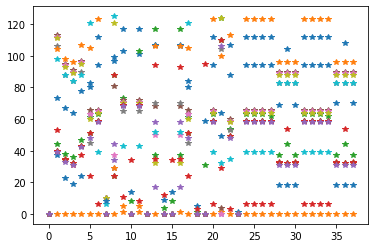

client_id=4, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=4, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg"]}}
Calling rpc_load_program with args=['ecg']
New connection at ID 5 ('192.168.0.107', 57469)
client_id=5, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]
Client ('192.168.0.107', 59135) has disconnected
client_id=5, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[1,false]}}
Calling rpc_atf_watchpoint_set_active with args=[1, False]
rpc_atf_watchpoint_set_active index=1 state=False
client_id=5, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[0,true]}}
Calling rpc_atf_watchpoint_set_active with args=[0, True]
rpc_atf_watchpoint_set_active index=0 state=True
client_id=5, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=5, data_str

In [19]:
plt.plot(anomaly_detection.dataset.T, linestyle='', marker="*")

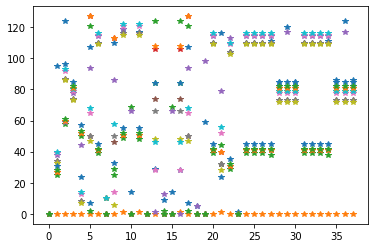

In [20]:
plt.plot(anomaly_detection.dataset.T, linestyle='', marker="*")

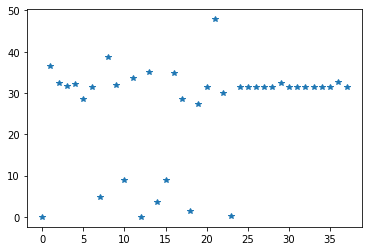

In [17]:
plt.plot(anomaly_detection.dataset.std(axis=0), linestyle='', marker="*")

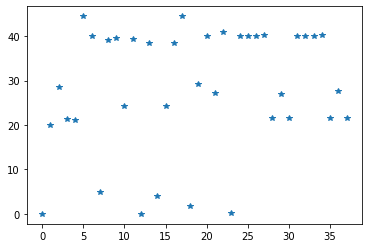

client_id=5, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[1,false]}}
Calling rpc_atf_watchpoint_set_active with args=[1, False]
rpc_atf_watchpoint_set_active index=1 state=False
client_id=5, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[0,true]}}
Calling rpc_atf_watchpoint_set_active with args=[0, True]
rpc_atf_watchpoint_set_active index=0 state=True
client_id=5, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=5, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg"]}}
Calling rpc_load_program with args=['ecg']
client_id=5, data_str={"RPC":{"function_name":"rpc_reset_dataset"}}
Calling rpc_reset_dataset with args=[]
New connection at ID 6 ('192.168.0.107', 52803)
client_id=6, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]
Client ('192.168.0.107', 57469) has disconnected
New connection at ID 

client_id=20, data_str={"RPC":{"function_name":"rpc_run"}}
Calling rpc_run with args=[]
client_id=20, data_str={"RPC":{"function_name":"rpc_halt"}}
Calling rpc_halt with args=[]
client_id=20, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=20, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg"]}}
Calling rpc_load_program with args=['ecg']
client_id=20, data_str={"RPC":{"function_name":"rpc_run"}}
Calling rpc_run with args=[]
client_id=20, data_str={"RPC":{"function_name":"rpc_enable_testing"}}
Calling rpc_enable_testing with args=[]
Client ('192.168.0.107', 63307) has disconnectedClient ('192.168.0.107', 49413) has disconnected
Client ('192.168.0.107', 63464) has disconnected
Client ('192.168.0.107', 64253) has disconnected
Client ('192.168.0.107', 55932) has disconnectedClient ('192.168.0.107', 61382) has disconnected

Client ('192.168.0.107', 58911) has disconnected
Client ('192.168.0.107', 64660) has dis

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/xilinx/jupyter_notebooks/tcp_server.py", line 166, in send_worker
    client.socket.send(data)
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xilinx/jupyter_notebooks/tcp_server.py", line 171, in send_worker
    self.connections.pop(client_id)
KeyError: -1


Error sending data to client -1: [Errno 104] Connection reset by peer
New connection at ID 31 ('192.168.0.107', 65521)
client_id=31, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]
New connection at ID 32 ('192.168.0.107', 57100)
client_id=32, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]


In [21]:
plt.plot(anomaly_detection.dataset.std(axis=0), linestyle='', marker="*")

NameError: name 'performance_event_names' is not defined

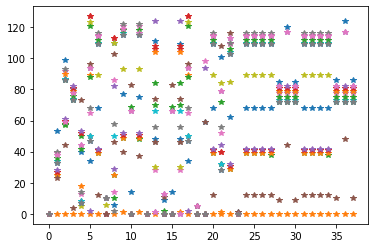

In [5]:
plt.plot(anomaly_detection.dataset.T, linestyle='', marker="*")

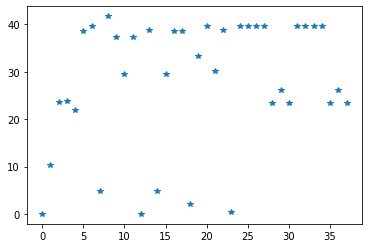

In [6]:
plt.plot(anomaly_detection.dataset.std(axis=0), linestyle='', marker="*")

In [9]:
pd.DataFrame(anomaly_detection.dataset, columns=used_events)

,Core__TRAP,Core__BRANCH,Core__JAL,Core__JALR,Core__AUIPC,Core__LOAD,Core__STORE,Core__SERIAL_SHIFT,Core__LOAD_WAIT,Core__STORE_WAIT,...,AXI4_Slave__AR_FLIT,AXI4_Slave__R_FLIT,AXI4_Slave__R_FLIT_FINAL,AXI4_Master__AW_FLIT,AXI4_Master__W_FLIT,AXI4_Master__W_FLIT_FINAL,AXI4_Master__B_FLIT,AXI4_Master__AR_FLIT,AXI4_Master__R_FLIT,AXI4_Master__R_FLIT_FINAL
0,0.0,53.0,99.0,80.0,40.0,34.0,68.0,0.0,110.0,77.0,...,85.0,120.0,85.0,68.0,68.0,68.0,68.0,86.0,124.0,86.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,25.0,58.0,79.0,50.0,121.0,39.0,0.0,25.0,49.0,...,79.0,79.0,79.0,39.0,39.0,39.0,38.0,79.0,79.0,79.0
3,0.0,27.0,60.0,81.0,52.0,127.0,41.0,0.0,113.0,51.0,...,81.0,81.0,81.0,41.0,41.0,41.0,41.0,81.0,81.0,81.0
4,0.0,38.0,59.0,78.0,44.0,94.0,114.0,10.0,82.0,119.0,...,82.0,117.0,82.0,114.0,114.0,114.0,114.0,82.0,117.0,82.0
5,0.0,34.0,87.0,74.0,8.0,50.0,110.0,10.0,46.0,116.0,...,73.0,73.0,73.0,110.0,110.0,110.0,110.0,73.0,73.0,73.0
6,0.0,39.0,92.0,79.0,13.0,65.0,115.0,10.0,14.0,121.0,...,78.0,78.0,78.0,115.0,115.0,115.0,115.0,78.0,78.0,78.0
7,0.0,40.0,93.0,80.0,14.0,68.0,116.0,10.0,58.0,122.0,...,79.0,79.0,79.0,116.0,116.0,116.0,116.0,79.0,79.0,79.0
8,0.0,25.0,86.0,73.0,5.0,123.0,89.0,6.0,110.0,93.0,...,72.0,72.0,72.0,89.0,89.0,89.0,89.0,72.0,72.0,72.0
9,0.0,34.0,87.0,74.0,8.0,50.0,110.0,10.0,50.0,116.0,...,73.0,73.0,73.0,110.0,110.0,110.0,110.0,73.0,73.0,73.0


In [36]:
anomaly_detection.dataset[0]

array([  0., 113.,  95.,  91.,  97.,  66.,  66.,  10.,  81.,  72.,   0.,
        36.,  72.,   0.,  68.,   0.,   0.,  68.,  66.,   0.,   0.,  66.,
         4.,  60.,   0.,  66.,  66.,  66.,  66.,  90.,  90.,  90.,  66.,
        66.,  66.,  66.,  90.,  90.,  90.])

In [22]:
1

1

client_id=32, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]


In [132]:
def send_test(val):
    tcp_server.send_to_all(
        json.dumps({
            'add_points' : {
                'test' : [val]
            }
        })
    )
    
for i in range(5):
    send_test(1)
    time.sleep(0.1)
    send_test(0)
    time.sleep(0.1)

#send_test(0)
#send_test(1)


In [130]:
send_test(0)

In [131]:
send_test(1)

In [ ]:
anomaly_detection.get_dataset_size()

# Advanced trace filter (ATF) testing

In [2]:
gpio_rst_n_out.write(0)

seeds = [
      #177711519189312448730221354182231558637597247368997856568353600156165082445924819823086537219813803655034425629222957323519789380881194761015097109113643492436494853351158801548809156587381022653656419362316880053721686257530213295492302669648879908944155843661259355247416136342707255439323305353187196384197

    #     97081571863202119540470995029932637987382626048125687395340616282408632421277679546841495729477368094495309346930269433005263784085567995676967413458616276771557870749853558953668198221519854005958192694960818014644861142877940285940418374394054218041391691990482562200656727048780580334389685158025765443103,
#     72988107250237495920102714721503671840119863320115041683284531007689094102132598416320545594765641915178544865414967713102711085720852615743397925981381353282342725210089676502129828507026310241957836986390459284800711987057378064364236224455662089777969480543544087753566469674185432144927462598143211900517,
#     106738977566983570110852620103400377292300453533011930141192199599635355298019566489684667006901891008645206022308884524698672777156607193011201304696737478287933507774884537488656010294279259572309150944453315991769055525611886872257222021232796393976378766870457343819513999607183988917017181317401129555928,
#     169792675614791427976691633934932484586471498037900305609681272694122116775948066266882052337887995216909734192970940273795107953077453183798027110768376688442875847747615398585154418296643575223613186058178239082384113881177527628936523102969662509304773940933200420209467102324760081730668971104131876503488
      
 #     2052950319899599258844377867017230206378980133563126191904312393062443451669541340282095508
    ]            
#reset_all_seeds_and_ranges()

#values_dict = {'pc': 0x80000000, 'A0': 0x80000000, 'A1': 0x80000000, 'A2': 0x80000000, 'A3': 0x80000000}


#for i, seed in enumerate(seeds):
#    cms_ctrl.set_atf_seed(seed, i, seed_bit_width=1024)

#cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=512, upper_bound=512)



In [12]:
#cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000198, 'A0':1000})
seed,mask,range_ = cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000760, 'A0': 1000})
#cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000760, 'A0':1000})

#cms_ctrl.set_atf_match_watchpoint(1, {'pc':0x80000760, 'A0':8})
#seed,mask,range_ = cms_ctrl.set_atf_match_watchpoint(1, {'pc':0x80000760}) # one direct match watchpoint per seed address only

# TODO: add masks={} to "set_atf_match_watchpoint"
#cms_ctrl.set_atf_match_watchpoint(1, {'pc':0x80000104, 'A0':0xFFFFFFFF}, masks={'A0': 0b11})

In [162]:
from continuous_monitoring_system_controller import create_seed_mask_and_range_for_values

In [25]:
cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000760})

(2147485536, 18446744073709551615, 64)

In [32]:
cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000048, 'A0':1000}, masks={'A0': 0b11}))

(2147483720, 18446744073709551615, 64)

In [43]:
reset_all_seeds_and_ranges()

In [ ]:
seed,mask,range_ = create_seed_mask_and_range_for_values({'pc':0x80000760, 'A0':1000})
print(f'{seed:b} 0x{seed:X}')
print(f'{mask:b} 0x{mask:X}')
print(range_)

In [39]:
cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=520, upper_bound=521)
cms_ctrl.set_atf_range(seed_address=0, range_address=1, lower_bound=499, upper_bound=499)

In [13]:
cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=506, upper_bound=506)

In [4]:
cms_ctrl.set_atf_mode(ATF_MODE.ANOMALY_DETECTION)
cms_ctrl.set_atf_mode(ATF_MODE.PATTERN_COLLECTION)

In [85]:
cms_ctrl.disable_atf()

In [16]:
cms_ctrl.disable_halting_cpu()

In [32]:
gpio_rst_n_out.write(0)
cms_ctrl.enable_halting_cpu()
#cms_ctrl.disable_halting_cpu()
bram_loader.load(PROGRAMS_DIR / 'ECG/ecg_baseline.bin')

In [36]:
gpio_rst_n_out.write(0)
cms_ctrl.enable_halting_cpu()
bram_loader.load(PROGRAMS_DIR / 'ECG/ecg_info_leak.bin')

In [31]:
gpio_rst_n_out.write(0)

In [41]:
reset_cpu()

In [40]:
items_transferred = get_dma_transfer(input_buffer, dma_rec) - 1 
items_transferred

0

In [24]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# all_gp_regs is a list of dicts, it is joined below into the main dataframe
df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
df.iloc[:items_transferred]

0.00019073486328125s
0.00016570091247558594s
0.00013947486877441406s
0.00013327598571777344s
0.00012803077697753906s
0.00017142295837402344s
0.0001888275146484375s
0.00016307830810546875s
0.0001437664031982422s
0.0001361370086669922s
0.00013184547424316406s
0.00012969970703125s
0.00012969970703125s
0.0001430511474609375s
0.0002048015594482422s
0.00014090538024902344s
0.00013780593872070312s


,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,A0,A1,A2,A3
0,80000768,50051943,50398227,ADDI,-,0,1000,2147551272,5063528411713059128,2147551272
1,80000768,50051943,50398227,ADDI,-,0,1000,2147551272,5063528411713059128,2147551272
2,80000768,50052008,50398227,ADDI,-,0,1000,2147551272,5063528411713059128,2147551272
3,80000768,50051943,50398227,ADDI,-,0,1000,2147551272,5063528411713059128,2147551272
4,80000768,50051943,50398227,ADDI,-,0,1000,2147551272,5063528411713059128,2147551272
5,80000768,50051943,50398227,ADDI,-,0,1000,2147551272,5063528411713059128,2147551272
6,80000768,50051943,50398227,ADDI,-,0,1000,2147551272,5063528411713059128,2147551272
7,80000768,50051943,50398227,ADDI,-,0,1000,2147551272,5063528411713059128,2147551272
8,80000768,50051943,50398227,ADDI,-,0,1000,2147551272,5063528411713059128,2147551272
9,80000768,50052008,50398227,ADDI,-,0,1000,2147551272,5063528411713059128,2147551272


In [23]:
chunks_per_item = math.ceil(AXI_DATA_WIDTH/64)
patterns = []
start = 0
end = chunks_per_item
for i in range(items_transferred-1):
    fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little') 
    patterns.append(fifo_item)
    start += chunks_per_item
    end += chunks_per_item

In [24]:
patterns[:2]

[17129200268340738932739219661317113231379390147163745841017112448663045225254406772015943838050136094427070268058986149859644225256751037194134720027616382114906659192112924684453866752,
 17129200268340738932739219661317113231379390147163745841017112440960006422047372605094636258983776112832440553338199952209086320252683566844406834820223159826442264047011038883970302080]

In [17]:
patterns[:2]

[2052950319899599258817417920350076427934682990491451377594235296617986618231413939221041168,
 2052950319899599258817417920350076427934682990491451377594235296614962403667737776347938816]

In [69]:
#reset_all_seeds_and_ranges()
#for i, seed in enumerate(seeds):
#    cms_ctrl.set_atf_seed(seed, i, seed_bit_width=1024)
for i in range(495, 530):
    #print(i, end = ', ')
    cms_ctrl.set_atf_range(seed_address=1, range_address=0, lower_bound=i, upper_bound=i)
    #get_dma_transfer(input_buffer, dma_rec)
    time.sleep(1)
    items_transferred = get_dma_transfer(input_buffer, dma_rec)
    if items_transferred > 1:
        print(i, f'= {items_transferred} items')
    #print()

502 = 2 items
503 = 66 items
505 = 517 items
506 = 1033 items
507 = 20 items
508 = 3 items
509 = 148 items
510 = 13 items
511 = 12 items
512 = 13 items
513 = 5 items
514 = 2000 items
515 = 1550 items
516 = 2005 items
517 = 2005 items
518 = 2005 items
519 = 24 items
520 = 66 items
521 = 2 items
522 = 2 items


In [130]:
cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=0, upper_bound=1024)

In [149]:
for i in range(10):
    time.sleep(0.1)
    items_transferred = get_dma_transfer(input_buffer, dma_rec)
    print(items_transferred)

2005
203
207
205
203
207
203
203
203
203


In [132]:
items_transferred

2005

In [11]:
for i in range(490, 520):
    print(i, end = ', ')
    cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=i, upper_bound=i)
    get_dma_transfer(input_buffer, dma_rec)
    time.sleep(0.5)
    items_transferred = get_dma_transfer(input_buffer, dma_rec)
    if items_transferred > 1:
        print(items_transferred, 'items', end=', ')
    print()

490, 
491, 
492, 
493, 
494, 2006 items, 
495, 517 items, 
496, 73 items, 
497, 241 items, 
498, 145 items, 
499, 147 items, 
500, 149 items, 
501, 110 items, 
502, 106 items, 
503, 70 items, 
504, 41 items, 
505, 27 items, 
506, 17 items, 
507, 10 items, 
508, 8 items, 
509, 4 items, 
510, 2 items, 
511, 
512, 
513, 
514, 
515, 
516, 
517, 
518, 
519, 


In [23]:
for i in range(470, 500): #(490, 520):
    print(i, end = ', ')
    cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=i, upper_bound=i)
    get_dma_transfer(input_buffer, dma_rec)
    time.sleep(0.5)
    items_transferred = get_dma_transfer(input_buffer, dma_rec)
    if items_transferred > 1:
        print(items_transferred, 'items', end=', ')
    print()

470, 
471, 
472, 
473, 
474, 
475, 
476, 
477, 
478, 
479, 
480, 
481, 
482, 
483, 
484, 4 items, 
485, 
486, 2006 items, 
487, 2005 items, 
488, 
489, 10 items, 
490, 503 items, 
491, 11 items, 
492, 
493, 584 items, 
494, 
495, 14 items, 
496, 
497, 
498, 
499, 


2005

In [161]:
chunks_per_item = math.ceil(AXI_DATA_WIDTH/64)
patterns = []
for j in range(1000):
    print(j, end=',')
    items_transferred = get_dma_transfer(input_buffer, dma_rec) - 1
    start = 0
    end = chunks_per_item
    for i in range(items_transferred-1):
        fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little') 
        patterns.append(fifo_item)
        start += chunks_per_item
        end += chunks_per_item

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [162]:
df_patterns = pd.DataFrame(patterns)

In [75]:
df_patterns.value_counts()

2052950319899599258844377867017230206378980133563126191904312467009835289303872679310264224    29720
2052950319899599258844377867017230206378980133563126191904312388101580933132288999536199552    29683
2052950319899599258817417920350079566584313118476106561230702815080201337076977448771387796       64
2052950319899599258817417920350079566584336502502303855677394074042998832015677105715020284       64
2052950319899599258817417920350079566584336502502303855677394152655238728758301379736371712       64
2052950319899599258817417920350079566584336502502303855677394150286216580322844046348255736       64
2052950319899599258817417920350079566584336502502303855677394152956809937798072461141475676       62
2052950319899599258817417920350079566584336502502303855677388765441758967823116100152852828       60
2052950319899599258817417920350079566584336502502303855677388765140187758783345018747748796       60
2052950319899599258817417920350079566584336502502303855677388764086476902088604227439952308

In [163]:
df_patterns.value_counts()

2052950319899599258844377867017230206378980133563126191904312467009835289303872679310264224    1001518
2052950319899599258844377867017230206378980133563126191904312388101580933132288999536199552    1000277
2052950319899599258844377867017230206378980133563126191904312388101616424667886816713508752        241
2052950319899599258844377867017230206378980133563126191904312388488438892509425116720924540        241
2052950319899599258844377867017230206378980133563126191904312393062443451669541340282095508        241
2052950319899599258844377867017230206378980133563126191904312466390865269661182541860702136        241
2052950319899599258844377867017230206378980133563126191904312466715836099771477894652495736        241
2052950319899599258844377867017230206378980133563126191904312466870613432134961592648337316        241
dtype: int64

0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000,150000,160000,170000,180000,

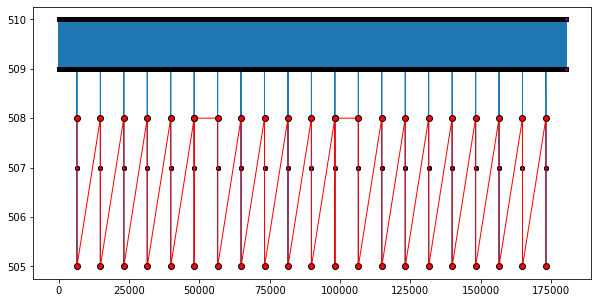

In [21]:
#advanced_trace_filter.plot_similarities(patterns[:10], seed_values[:1])
plot_similarities(patterns, seeds[:1])

In [6]:
def bits_in_int(n, bit_type=1, bits_size=1024):
    count = 0
    while n:
        n &= n - 1
        count += 1
    if bit_type == 0:
        return bits_size - count
    return count

def calculate_similarities(pattern_series, seed_value, bits_size=1024):
    similarities = []
    for i, val in enumerate(pattern_series):
        if i % 10000 == 0:
            print(i, end=',')
        similarity = bits_in_int(val ^ seed_value, bit_type=0, bits_size=bits_size) 
        similarities.append(similarity)
    return similarities

def plot_similarities(pattern_series, seed_values, frequency_threshold=40):
    subplots_count = len(seed_values)
    fig, axs = plt.subplots(subplots_count, 1, figsize=(10, 10))
    if subplots_count == 1:
        axs = [axs]
    for i in range(subplots_count):
        similarities = pd.Series( calculate_similarities(pattern_series, seed_values[i]) )
        # df[f'similarities_{i}'].plot(ax=axs[i], marker='o', markersize=2, linestyle='None', figsize=(10, 5))
        value_counts = similarities.value_counts() 
        indices_to_keep = similarities[ similarities.apply(lambda x: value_counts[x] < frequency_threshold) ].index
        similarities.plot(ax=axs[i], marker='o', markersize=4, linestyle='-', linewidth=1, markerfacecolor='purple', markeredgecolor='black', figsize=(10, 5))
        similarities.loc[indices_to_keep].plot(ax=axs[i], marker='o', markersize=6, linestyle='-', linewidth=1, color='red', markerfacecolor='red', markeredgecolor='black', figsize=(10, 5))
    fig.show()
    plt.show()

In [ ]:
fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little')


In [42]:
chunks_per_item = math.ceil(AXI_DATA_WIDTH/64)
# CLK_LOCATION = PERFORMANCE_EVENTS_COUNT * PERFORMANCE_COUNTER_WIDTH + PERFORMANCE_COUNTERS_OVERFLOW_MAP_WIDTH + PC_WIDTH
# HALTED_CLK_LOCATION = CLK_LOCATION + CLK_COUNTER_WIDTH + INSTR_WIDTH
total_clk_time = 0
total_halted_time = 0
items_transferred = 0

class MODE:
    # these can be used with bitwise operators (need to be careful if new modes are added)
    IDLE = 0
    TRAINING = 0b1
    TESTING = 0b10
    TRAINING_AND_TESTING = 0b11
    
#mode = MODE.TRAINING
mode = MODE.TESTING
#mode = MODE.TRAINING_AND_TESTING

#if mode == MODE.TRAINING:
#    anomaly_detection = Anomaly_Detection(39)

#anomaly_detection = Anomaly_Detection(39)

similarities = []

for i in range(10):
    while items_transferred < 2:
#         dma_rec.transfer(input_buffer)
#         dma_rec.wait()
#         items_transferred = math.floor(dma_rec.transferred * 64 / AXI_DATA_WIDTH / 8)
        items_transferred = get_dma_transfer(input_buffer, dma_rec)
        time.sleep(0.001)
        continue
    
    #events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
    print(items_transferred, end=', ')
    
#     events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
#     df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
#     # all_gp_regs is a list of dicts, it is joined below into the main dataframe
#     df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
#     df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
#     print( df.iloc[:items_transferred] )
    
        
    start = 0
    end = chunks_per_item
    time_checkpoint = time.time()
    for i in range(items_transferred-1):
        fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little')            
        
#         clk_count = (fifo_item >> CLK_LOCATION) & ((1 << 64)-1)
#         halted_clk_count = (fifo_item >> HALTED_CLK_LOCATION) & ((1 << 64)-1)
        
        perf_counters, perf_counters_overflow_map, pc, clk_counter, instr, fifo_full_ticks_count, gp_regs = parse_fifo_item(fifo_item)

        #print(perf_counters)
        if mode & MODE.TESTING:
            similarity = anomaly_detection.get_max_cosine_similarity(perf_counters)
            similarities.append(similarity)
        if mode & MODE.TRAINING:
            anomaly_detection.update_dataset(perf_counters)
            
        #print(perf_counters)
#         if i != 0:
#             total_clk_time += clk_count
#             total_halted_time += halted_clk_count
        total_clk_time += clk_counter
        total_halted_time += fifo_full_ticks_count
        start += chunks_per_item
        end += chunks_per_item
#         print(hex(pc), hex(instr), clk_counter, fifo_full_ticks_count)
    time.sleep(1)
    items_transferred = 0
    print(f'dataset size = {anomaly_detection.get_dataset_size()}', end=', ')
    print(f'{time.time() - time_checkpoint}s')
    

print(f'Total clk_count = {total_clk_time / CLK_SPEED}s')
print(f'Total halted_time = {total_halted_time / CLK_SPEED}s')


    
s = '''    for i in range(PERFORMANCE_EVENTS_COUNT):
        fifo_item, perf_counter = pop_n_bits_value(fifo_item, PERFORMANCE_COUNTER_WIDTH)
        perf_counters.append(perf_counter)
    fifo_item, perf_counters_overflow_map = pop_n_bits_value(fifo_item, PERFORMANCE_COUNTERS_OVERFLOW_MAP_WIDTH)
    fifo_item, pc = pop_n_bits_value(fifo_item, PC_WIDTH)
    fifo_item, clk_counter = pop_n_bits_value(fifo_item, CLK_COUNTER_WIDTH)
    fifo_item, instr = pop_n_bits_value(fifo_item, INSTR_WIDTH)
    fifo_item, fifo_full_ticks_count = pop_n_bits_value(fifo_item, FIFO_FULL_TICKS_COUNT_WIDTH)
'''

14, dataset size = 158, 1.0121643543243408s
2, dataset size = 158, 1.0020756721496582s
2, dataset size = 158, 1.0020813941955566s
26, dataset size = 158, 1.039628028869629s
125, dataset size = 158, 1.1846489906311035s
143, dataset size = 158, 1.2143023014068604s
146, dataset size = 158, 1.2242939472198486s
72, dataset size = 158, 1.1145339012145996s
2, dataset size = 158, 1.002115249633789s
2, dataset size = 158, 1.0033338069915771s
Total clk_count = 368934881418.8157s
Total halted_time = 0.0s


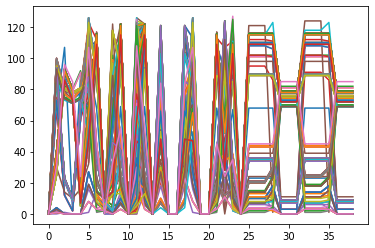

In [55]:
plt.plot(anomaly_detection.dataset.T)

# testing with ecg_baseline.bin

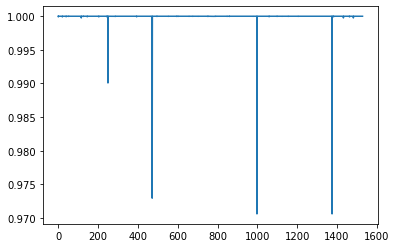

In [30]:
plt.plot(similarities)

# testing with ecg_baseline.bin (after reloading it into memory and resetting processor)

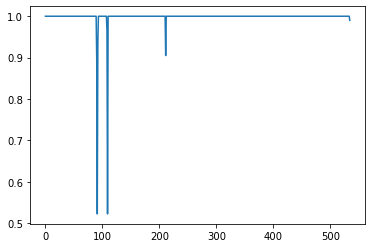

In [35]:
plt.plot(similarities)

# testing with ecg_info_leak.bin

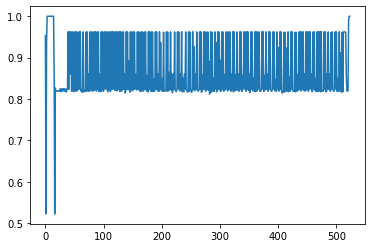

In [43]:
plt.plot(similarities)

In [58]:
anomaly_detection.dataset[:3,:5]

array([[  0.,  66., 107.,   2.,  89.],
       [  0.,  89.,  81.,  79.,  91.],
       [  0.,  90.,  82.,  80.,  92.]])

In [47]:
hex(input_buffer[start])

'0x0'

In [24]:
items_transferred = 50

In [27]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# all_gp_regs is a list of dicts, it is joined below into the main dataframe
df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
df.iloc[:items_transferred]

0.00022792816162109375s
0.00022602081298828125s
0.0001590251922607422s


,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,A0,A1,A2,A3
0,80000764,18446744073709551615,42021923,UNKNOWN,-,0,1000,4128,0,0
1,80000768,1,50398227,ADDI,-,0,1000,4128,0,0
2,FFFFFFFFFFFFFFFF,18446744073709551615,4294967295,UNKNOWN,-,18446744073709551615,18446744073709551615,18446744073709551615,18446744073709551615,18446744073709551615


In [4]:
gpio_rst_n_out.write(0)
cms_ctrl.enable_halting_cpu()
bram_loader.load(PROGRAMS_DIR / 'ECG/ecg_baseline.bin')
df, stdout = run_and_collect("", input_buffer=input_buffer, dont_decode=True, execution_time_limit=15)
gpio_rst_n_out.write(0)

Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=43824, parsing...
Execution time limit (15ms) was reached, tracing is stopped. (execution time=10959.895859999999ms)
All DMA transfers completed, total_items=43824, converting lists to dataframe...
Dataframe is ready


In [8]:
print_performance_stats(df)

normal_run_time = 10.95989586s
halted_time = 0.0s
performance_decrease = 0.0%


# Collecting training data for analysis
Trying to find infrequent patterns (e.g. happening between around 1-100ms)

In [2]:
gpio_rst_n_out.write(0)
cms_ctrl.enable_halting_cpu()
bram_loader.load(PROGRAMS_DIR / 'ECG/ecg_baseline.bin')
df, stdout = run_and_collect("", input_buffer=input_buffer, dont_decode=True, execution_time_limit=15)
gpio_rst_n_out.write(0)

Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=43824, parsing...
execution_time_ms = 5.51846
Initiating DMA transfer i=1
Transfer 2 finished, items_transferred=43824, parsing...
execution_time_ms = 10.9406
Initiating DMA transfer i=2
Transfer 3 finished, items_transferred=43824, parsing...
Execution time limit (15ms) was reached, tracing is stopped. (execution time=16.197960000000002ms)
All DMA transfers completed, total_items=131472, converting lists to dataframe...
Dataframe is ready


In [3]:
df.to_csv('ecg_data.csv')

client_id=0, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=0, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg_baseline"]}}
Calling rpc_load_program with args=['ecg_baseline']
client_id=0, data_str={"RPC":{"function_name":"rpc_run"}}
Calling rpc_run with args=[]


# TCP server

In [8]:
tcp_server.send_to_all(json.dumps({'status_update':{
    'pynq_restarted':True
}}))

client_id=3, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=3, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg_baseline"]}}
Calling rpc_load_program with args=['ecg_baseline']
client_id=3, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=3, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg_info_leak"]}}
Calling rpc_load_program with args=['ecg_info_leak']
Client ('192.168.0.103', 60124) has disconnected
New connection at ID 4 ('192.168.0.103', 50078)
client_id=4, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=4, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg_info_leak"]}}
Calling rpc_load_program with args=['ecg_info_leak']
client_id=4, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=4, da

In [2]:

for k in range(100):
    for j in range(3):
        msg = {}
        msg['add_points'] = {f'test_{j}':[]}
        for i in range(3):
            val = round(random.uniform(0.0,0.1) + 0.2 * (j+0.5), 3)
            msg['add_points'][f'test_{j}'].append(val)
        tcp_server.send_to_all( json.dumps(msg) + '\n' ) 
    print(j)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


# ECG testing (checking sensor values through console DMA)

In [54]:
gpio_rst_n_out.write(0)
bram_loader.load(BASE_DIR / 'ecg.bin')
cms_ctrl.disable_halting_cpu()

df, stdout = run_and_collect(stdin, input_buffer=input_buffer, dont_decode=True)

In [5]:
def parse_ecg_program_output(stdout):
    ''' This program sends 150 '\n' separated ecg sensor values.'''
    values = [int(val[::-1]) for val in stdout.split('\n')[:-1]] # stdout ends with '\n' so -1 is used to ignore it
    return pd.DataFrame(values, columns=['ECG'])

In [ ]:
for i in range(1):
    console_io.send('a')
    time.sleep(0.1)
    stdout = console_io.read(blocking=True)
    print(i, stdout)

In [20]:
df_ecg = parse_ecg_program_output(stdout)
send_sensors_data_to_all_tcp_clients(df_ecg, sensors_to_send=['ECG'])

In [21]:
stdout

'51582\n45372\n07282\n10472\n45682\n14372\n16082\n44182\n20172\n14482\n42672\n82182\n79282\n72372\n09482\n'

In [22]:
console_io.read()

'62572\n25082\n'

New connection at ID 2 ('192.168.0.103', 52899)


In [26]:
console_io.send('a')
start_time = time.time()

while (time.time() - start_time) < 3:
    stdout = console_io.read()
    if stdout:
        print(time.time() - start_time, '   ', stdout)

0.0013704299926757812     87615

0.008449316024780273     54353

0.01275014877319336     29212

0.015386819839477539     92502

0.02564072608947754     49743
40743

0.030405282974243164     29402

0.03536653518676758     05312

0.0403745174407959     39553

0.04530620574951172     66743

0.05030179023742676     42502

0.05529928207397461     29212

0.06015419960021973     88553

0.06521368026733398     20943

0.07058930397033691     31602



In [8]:
#while True:
for i in range(1000):
    console_io.send('a')
    time.sleep(0.1)
    stdout = console_io.read(blocking=True)
    df_ecg = parse_ecg_program_output(stdout)
    send_sensors_data_to_all_tcp_clients(df_ecg, sensors_to_send=['ECG'])
    #time.sleep(0.5)
    print(i, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [30]:
df_ecg

,ECG
0,13342
1,16781
2,16041


## Debugging ECG with libraries

In [48]:
# dma_rec.transfer(input_buffer)
# dma_rec.wait()
# items_transferred = math.floor(dma_rec.transferred * 64 / AXI_DATA_WIDTH / 8)
# items_transferred

43824

In [40]:
# items_transferred = 10

In [41]:
# events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
# df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# # all_gp_regs is a list of dicts, it is joined below into the main dataframe
# df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
# df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
# df

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,A0,A1,A2,A3
0,800001B4,31,4277625059,BLTU,-,20,1000,4128,0,0
1,80000194,1,19,ADDI,-,0,1000,4128,0,0
2,800001B4,31,4277625059,BLTU,-,20,1000,4128,0,0
3,80000194,1,19,ADDI,-,0,1000,4128,0,0
4,800001B4,31,4277625059,BLTU,-,20,1000,4128,0,0
5,80000194,1,19,ADDI,-,0,1000,4128,0,0
6,800001B4,31,4277625059,BLTU,-,20,1000,4128,0,0
7,80000194,1,19,ADDI,-,0,1000,4128,0,0
8,800001B4,31,4277625059,BLTU,-,20,1000,4128,0,0
9,80000194,1,19,ADDI,-,0,1000,4128,0,0


In [52]:
# for i in range(1000):
#     dma_rec.transfer(input_buffer)
#     dma_rec.wait()
#     items_transferred = math.floor(dma_rec.transferred * 64 / AXI_DATA_WIDTH / 8)
#     print(items_transferred)

43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
4382

# Test shadow GPR file

In [2]:
bram_loader.load(BASE_DIR / 'riscv-stack-mission.bin')
df, stdout = run_and_collect("====================A402008000000000", input_buffer=input_buffer, dont_decode=True)

Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=2237, parsing...
All DMA transfers completed, total_items=2237, converting lists to dataframe...
Dataframe is ready


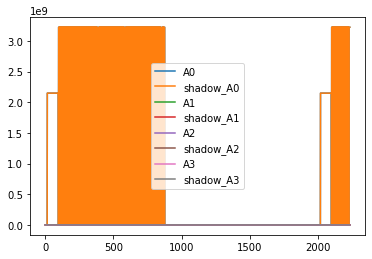

In [6]:
# df[['A0','shadow_A0','A1','shadow_A1','A2','shadow_A2','A3','shadow_A3']].plot()

In [9]:
# df[['A0','A1','A2','A3']].to_csv('A0-A3.csv')
# df[['shadow_A0','shadow_A1','shadow_A2','shadow_A3']].to_csv('A0-A3_shadow.csv')

In [10]:
df[[col for col in df.columns if ('shadow' in col or len(col) == 2)]].iloc[:50]

,pc,A0,A1,A2,A3,shadow_A0,shadow_A1,shadow_A2,shadow_A3
0,1010,0,4128,0,0,0,4128,0,0
1,80000000,0,4128,0,0,0,4128,0,0
2,80000004,0,4128,0,0,0,4128,0,0
3,80000008,0,4128,0,0,0,4128,0,0
4,80000010,0,4128,0,0,0,4128,0,0
5,800005EC,0,4128,0,0,0,4128,0,0
6,800005FC,0,4128,0,0,0,4128,0,0
7,80000324,0,4128,0,0,0,4128,0,0
8,80000328,0,4128,0,0,0,4128,0,0
9,80000338,0,4128,0,0,0,4128,0,0


In [3]:
df.iloc[:20]

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,A0,A1,A2,A3,...,AXI4_Slave__AR_FLIT,AXI4_Slave__R_FLIT,AXI4_Slave__R_FLIT_FINAL,AXI4_Master__AW_FLIT,AXI4_Master__W_FLIT,AXI4_Master__W_FLIT_FINAL,AXI4_Master__B_FLIT,AXI4_Master__AR_FLIT,AXI4_Master__R_FLIT,AXI4_Master__R_FLIT_FINAL
0,1010,570,00028067,JALR,-,0,0,4128,0,0,...,1,8,1,0,0,0,0,1,8,1
1,80000000,35,F14022F3,UNKNOWN,-,0,0,4128,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80000004,1,02029063,BNE,-,0,0,4128,0,0,...,0,0,0,0,0,0,0,0,0,0
3,80000008,1,00001117,AUIPC,-,0,0,4128,0,0,...,0,0,0,0,0,0,0,0,0,0
4,80000010,2,5DC0006F,JAL,-,0,0,4128,0,0,...,0,0,0,0,0,0,0,0,0,0
5,800005EC,35,FF010113,ADDI,-,0,0,4128,0,0,...,0,0,0,0,0,0,0,0,0,0
6,800005FC,35,D29FF0EF,JAL,-,0,0,4128,0,0,...,0,0,0,1,1,1,0,1,0,0
7,80000324,48,F8010113,ADDI,-,0,0,4128,0,0,...,0,0,0,1,1,1,1,0,4,1
8,80000328,1,06113C23,UNKNOWN,-,0,0,4128,0,0,...,0,0,0,0,0,0,0,0,0,0
9,80000338,41,0280006F,JAL,-,0,0,4128,0,0,...,0,0,0,3,3,3,2,0,0,0


# Producing dataset for publication (stack-mission)
stack-mission program is slightly modified version of: 
https://ctsrd-cheri.github.io/cheri-exercises/missions/uninitialized-stack-frame-control-flow/index.html

#### Baseline dataset
Each of program runs below should output "No cookies??" at the end.

In [ ]:


bram_loader.load(BASE_DIR / 'riscv-stack-mission.bin')

program_inputs = [
    'AAAAAAaAAAAaAA0AAAA0AAa0AA0aAA00AA-AA=',
    'aAAAaAaAaAAaaA0AaAA0aAa0aA0aaA00aA-aA=',
    'AaAAAaaAAaAaAa0AAaA0Aaa0Aa0aAa00Aa-Aa=',
    '0AAA0AaA0AAa0A0A0AA00Aa00A0a0A000A-0A=',
    'A0AAA0aAA0AaA00AA0A0A0a0A00aA000A0-A0=',
    'a0AAa0aAa0Aaa00Aa0A0a0a0a00aa000a0-a0=',
    '0aAA0aaA0aAa0a0A0aA00aa00a0a0a000a-0a=',
    '00AA00aA00Aa000A00A000a0000a000000-00=',
    '-AA-aA-Aa-0A-A0-a0-0a-00---=',
    '=AA=aA=Aa=0A=A0=a0=0a=00=-=='
]

for i, stdin in enumerate(program_inputs):
    print(f'Running program with input: "{stdin}"')
    df, stdout = run_and_collect(stdin, input_buffer=input_buffer, dont_decode=True)
    csv_f_name = f'normal_cartesian_product_{i}.csv'
    print(f'Collected {df.shape[0]} items. Saving as "{csv_f_name}"')
    #df.to_csv(str(OUTPUT_DIR / csv_f_name), index=False)
    print(stdout)
    print()

#### Abnormal run
The program should output "Exit successful, yum!" if the input to the file successfully redirects execution flow to the "success" function located at 0x800002A4

In [5]:

#bram_loader.load(BASE_DIR / 'riscv-stack-mission.bin')
stdin = "====================A402008000000000"
print(f'Running program with input: "{stdin}"')
df, stdout = run_and_collect(stdin, input_buffer=input_buffer, dont_decode=True)
csv_f_name = f'stack_mission_compromised_new.csv'
print(f'Collected {df.shape[0]} items. Saving as "{csv_f_name}"')
#df.to_csv(str(OUTPUT_DIR / csv_f_name), index=False)
print('Done, ouptut =', stdout)

Running program with input: "====================A402008000000000"
Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=2237, parsing...
All DMA transfers completed, total_items=2237, converting lists to dataframe...
Dataframe is ready
Collected 2237 items. Saving as "stack_mission_compromised_new.csv"
Done, ouptut = Cookie monster is hungry, provide some cookies!
'-' skips to the next character
XX as two hex digits stores a single cookie
> 
Exit successful, yum!



# Testing DMA-based console I/O

In [7]:
gpio_rst_n_out.write(0)
bram_loader.load(BASE_DIR / 'riscv-console-echo.bin')
cms_ctrl.disable_halting_cpu()
reset_cpu()

In [8]:
console_io.send('hello_board')

In [9]:
console_io.data_available()

True

In [10]:
console_io.read()

'hello_board'

# Testing peripherals/sensors

In [ ]:
gpio_rst_n_out.write(0)
#bram_loader.load(BASE_DIR / 'peripherals_test_7_sensors5.bin')
bram_loader.load(BASE_DIR / 'peripherals_test_16_sensors.bin')
cms_ctrl.disable_halting_cpu()
reset_cpu()

In [22]:
console_io.send('a')

In [4]:
def parse_peripherals_test_program_output(stdout, sensors_count=16, samples=10):
    sensors = ['Potentiometer', 'Light', 'Humidity', 'Vibration', 'Mic', 'Hall', 'Temp', 'ECG', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15']
    ''' This program sends 16 '\n' separated sensor values. It does that 10 times
    after receiving any character through console input. '''
    values = [int(val[::-1]) for val in stdout.split('\n')[:-1]] # stdout ends with '\n' so -1 is used to ignore it
    if len(values) % 16 != 0:
        print(f'values length {len(values)} is not divisible by 16')
        print('Values:')
        print(values)
        print('\nstdout:')
        print(stdout)
    sensor_values = {s:[] for s in sensors}
    for i in range(samples):
        for j in range(sensors_count):
            name = sensors[j]
            val = values[i*sensors_count + j]
            sensor_values[name].append(val)
    return pd.DataFrame(sensor_values)

In [13]:
sensors_to_send = ['Potentiometer', 'Light', 'ECG']
#while True:
for i in range(300):
    console_io.send('a')
    time.sleep(0.1)
    stdout = console_io.read(blocking=True)
    df_sensors = parse_peripherals_test_program_output(stdout)
    send_sensors_data_to_all_tcp_clients(df_sensors, sensors_to_send)
    time.sleep(0.1)
    print(i, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [11]:
df_sensors

,Potentiometer,Light,Humidity,Vibration,Mic,Hall,Temp,ECG,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15
0,37176,20532,21512,23597,22682,27909,25910,27650,21992,21198,21122,43744,42798,42232,42156,42133
1,37154,20543,21486,23590,22712,27905,25884,27577,21951,21201,21140,43746,42797,42224,42145,42124
2,37148,20581,21516,23586,22692,27928,25905,28244,22001,22182,22142,43772,42790,42202,42133,42120
3,37174,20538,21510,23584,22697,27921,25914,27332,21934,21169,21125,43744,42812,42217,42154,42152
4,37156,20566,21498,23590,22699,27920,25884,27984,22000,22190,22136,43753,42792,42231,42139,42104
5,37160,20545,21504,23596,22644,27928,25920,27779,22008,22190,22141,43760,42804,42240,42128,42137
6,37176,20526,21473,23597,22688,27937,25908,27584,21928,21206,21146,43740,42794,42208,42116,42137
7,37142,20546,21484,23584,22709,27904,25907,28466,22017,22196,22158,43801,42816,42208,42144,42135
8,37160,20549,21520,23568,22693,27948,25939,27507,21982,21188,21149,43756,42798,42208,42136,42140
9,37177,20566,21469,23608,22682,27918,25900,28157,22008,22188,22147,43736,42813,42219,42126,42169


# Data collection and performance testing

In [7]:
TLAST_INTERVAL = 3
cms_ctrl.set_tlast_interval(3)

In [3]:
#bram_loader.load(BASE_DIR / 'riscv-example-baremetal-short.bin')
#bram_loader.load(BASE_DIR / 'riscv-stack-mission.bin')
#bram_loader.load(BASE_DIR / 'performance_test_400_calls.bin')

#bram_loader.load(BASE_DIR / 'performance_test.bin')
#bram_loader.load(BASE_DIR / 'riscv-console-echo.bin')


bram_loader.load(BASE_DIR / 'peripheral_test.bin')
#bram_loader.load(BASE_DIR / 'riscv-console-echo.bin')

In [5]:
start_time = time.time()
df, stdout = run_and_collect("800000", input_buffer=input_buffer, dont_decode=True, dont_parse=True, copy_collected=False)
print(time.time() - start_time)

Initiating DMA transfer i=0
Ignoring a single received instruction (most likely WFI)
Transfer 1 finished (not parsing), items_transferred=43824.
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=4244.
All DMA transfers completed (no parsing), total_items=48068. It is assumed that all transfers completed because items_transferred (4244) != TLAST_INTERVAL (43824).
0.12686777114868164


In [19]:
start_time = time.time()
df, stdout = run_and_collect("123", input_buffer=input_buffer, dont_decode=True, dont_parse=False, copy_collected=False)
print(time.time() - start_time)

Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=116, parsing...
All DMA transfers completed, total_items=116, converting lists to dataframe...
Dataframe is ready
0.22438716888427734


In [20]:
df

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,Core__TRAP,Core__BRANCH,Core__JAL,Core__JALR,...,AXI4_Slave__AR_FLIT,AXI4_Slave__R_FLIT,AXI4_Slave__R_FLIT_FINAL,AXI4_Master__AW_FLIT,AXI4_Master__W_FLIT,AXI4_Master__W_FLIT_FINAL,AXI4_Master__B_FLIT,AXI4_Master__AR_FLIT,AXI4_Master__R_FLIT,AXI4_Master__R_FLIT_FINAL
0,1010,316,00028067,JALR,-,0,0,0,0,0,...,1,8,1,0,0,0,0,1,8,1
1,80000000,35,F14022F3,UNKNOWN,-,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,80000004,1,02029063,BNE,-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,80000008,1,00010117,AUIPC,-,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,80000010,2,1880006F,JAL,-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,80000038,1,FE010113,ADDI,-,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
112,80000070,19,00008067,JALR,-,0,0,0,0,0,...,0,0,0,2,2,2,2,0,0,0
113,8000021C,1,00050793,ADDI,-,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
114,8000024C,17,FCF740E3,BLT,-,0,0,0,0,0,...,0,0,0,2,2,2,1,0,0,0


In [5]:
reset_cpu()

In [4]:
console_io.send('800000', end_byte=ord('\n'))

In [6]:
console_io.send('4567890123', end_byte=ord('\n'))

In [6]:
console_io.data_available()

False

In [9]:
console_io.read()

'457913\n'

In [3]:
dma_rec.transfer(input_buffer)

In [4]:
dma_rec.wait()

In [5]:
items_transferred = math.floor(dma_rec.transferred * 64 / AXI_DATA_WIDTH / 8)

In [6]:
items_transferred

43824

In [10]:
input_buffer[:] = 0

In [4]:
cms_ctrl.disable_halting_cpu()

In [9]:
cms_ctrl.enable_halting_cpu()

In [5]:
# program input needs to be available immediately, for that reason a separate reset line is used for processor
# and the console input fifo
#console_io.send('20000', end_byte=ord('\n'))
console_io.send('23', end_byte=ord('\n'))

In [ ]:
start_time = time.time()
df, stdout = run_and_collect("800000", input_buffer=input_buffer, dont_decode=True, dont_parse=False, copy_collected=False)
print(time.time() - start_time)

Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=43824, parsing...


In [11]:
df.iloc[:43824]

AttributeError: 'NoneType' object has no attribute 'iloc'

In [7]:
stdout

''

In [8]:
items_transferred = 5000

In [7]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)


In [9]:
df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# all_gp_regs is a list of dicts, it is joined below into the main dataframe
df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
df

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,A0,A1,A2,A3
0,00001010,570,163943,JALR,-,0,0,4128,0,0
1,80000000,31,4278255891,ADDI,-,0,0,4128,0,0
2,00001010,125,163943,JALR,-,0,0,4128,0,0
3,80000000,1,4278255891,ADDI,-,0,0,4128,0,0
4,00001010,75,163943,JALR,-,0,0,4128,0,0
...,...,...,...,...,...,...,...,...,...,...
43819,80000000,1,4278255891,ADDI,-,0,0,4128,0,0
43820,00001010,75,163943,JALR,-,0,0,4128,0,0
43821,80000000,1,4278255891,ADDI,-,0,0,4128,0,0
43822,00001010,75,163943,JALR,-,0,0,4128,0,0


In [11]:
df[df['instr']!= 0]

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,A0,A1,A2,A3


In [28]:
df[df['instr_names'] == 'WFI']

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,A0,A1,A2,A3


In [17]:
df

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,A0,A1,A2,A3
0,8000021C,1,329619,ADDI,-,0,15376,4128,0,0
1,8000024C,24,4244062435,BLT,-,8,15376,4128,0,0
2,8000020C,1,4265879427,LW,-,0,15376,4128,0,0
3,80000218,4,3793744111,JAL,-,0,125,4128,0,0
4,80000038,1,4261478675,ADDI,-,1,125,4128,0,0
...,...,...,...,...,...,...,...,...,...,...
4240,80000038,1,4261478675,ADDI,-,1,63,4128,0,0
4241,80000070,65,32871,JALR,-,46,3969,4128,0,0
4242,8000021C,1,329619,ADDI,-,0,3969,4128,0,0
4243,8000024C,24,4244062435,BLT,-,8,3969,4128,0,0


In [50]:
df.to_csv('test_2nd_run.csv')

In [11]:
df_times = pd.DataFrame()
df_throughputs = pd.DataFrame()
print(buffer_length)
for new_buffer_length in range(10_000_000, buffer_length*INPUT_BUFFER_DTYPE_SIZE_IN_BYTES+1, 20_000_000):
# 4802099 / 19.326404809951782 * 1024 / 8 / 1000000 * ((39*7+39+64+64+32+4*64)/1024)
    throughputs_with_copying = []
    throughputs_without_copying = []
    
    BUFFER_ITEM_CAPACITY = new_buffer_length // AXI_DATA_WIDTH * 8 
    TLAST_INTERVAL = BUFFER_ITEM_CAPACITY - 100
    cms_ctrl.set_tlast_interval(TLAST_INTERVAL)

    times_with_copying = []
    times_without_copying = []
    inputs = []
    UPPER_RANGE = 900_001 #1_300_001 #1_200_001
    LOWER_RANGE = 100_000
    STEP = 100_000
    for i in range(LOWER_RANGE, UPPER_RANGE, STEP):
        inputs.append(i)
        start_time = time.time()
        df, stdout = run_and_collect(str(i), input_buffer=input_buffer, dont_decode=True, dont_parse=True, copy_collected=False)
        total_time = time.time() - start_time
        times_without_copying.append(total_time)
        print(i, total_time)

        items_sent = i * 6 + 97
        throughputs_without_copying.append(items_sent / total_time * AXI_DATA_WIDTH / 8 / 1_000_000 * (USED_AXI_BITS / AXI_DATA_WIDTH))


    for i in range(LOWER_RANGE, UPPER_RANGE, STEP):
        start_time = time.time()
        df, stdout = run_and_collect(str(i), input_buffer=input_buffer, dont_decode=True, dont_parse=True, copy_collected=True)
        total_time = time.time() - start_time
        times_with_copying.append(total_time)
        print(i, total_time)

        items_sent = i * 6 + 97
        throughputs_with_copying.append(items_sent / total_time * AXI_DATA_WIDTH / 8 / 1_000_000 * (USED_AXI_BITS / AXI_DATA_WIDTH))
        input_buffer_all_transfers_copied = []
        
    df_times[f'Seconds without copying_{new_buffer_length}'] = times_without_copying
    df_times[f'Seconds with copying_{new_buffer_length}'] = times_with_copying
    df_throughputs[f'Throughput without copying_{new_buffer_length}'] = throughputs_without_copying
    df_throughputs[f'Throughput with copying_{new_buffer_length}'] = throughputs_with_copying

#     df_times_throughputs = pd.DataFrame(
#         zip(times_without_copying, times_with_copying, throughputs_without_copying, throughputs_with_copying), 
#         columns=['Seconds without copying', 
#                  'Seconds with copying', 
#                  'Throughput without copying', 
#                  'Throughput with copying'], 
#         index=inputs
#         )



6250000
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=6
Transfer 7 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=7
Transfer 8 finished (not parsing), items_transferred=55957.
All DMA transfers completed (no parsing), total_items=602097. It is assumed that all transfers completed because items_transferred (55957) != TLAST_INTERVAL (78020).
100000 0.3042876720428467
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Initiati

Transfer 13 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=13
Transfer 14 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=14
Transfer 15 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=15
Transfer 16 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=16
Transfer 17 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=17
Transfer 18 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=18
Transfer 19 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=19
Transfer 20 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=20
Transfer 21 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=21
Transfer 22 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=22
Transfer 23 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=23
Transfer 2

Transfer 19 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=19
Transfer 20 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=20
Transfer 21 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=21
Transfer 22 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=22
Transfer 23 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=23
Transfer 24 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=24
Transfer 25 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=25
Transfer 26 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=26
Transfer 27 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=27
Transfer 28 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=28
Transfer 29 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=29
Transfer 3

Transfer 60 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=60
Transfer 61 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=61
Transfer 62 finished (not parsing), items_transferred=40872.
All DMA transfers completed (no parsing), total_items=4800092. It is assumed that all transfers completed because items_transferred (40872) != TLAST_INTERVAL (78020).
800000 1.7052643299102783
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=6
Transfer 7

Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=6
Transfer 7 finished (not

Buffer was copied
Initiating DMA transfer i=12
Transfer 13 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=13
Transfer 14 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=14
Transfer 15 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=15
Transfer 16 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=16
Transfer 17 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=17
Transfer 18 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfe

Buffer was copied
Initiating DMA transfer i=33
Transfer 34 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=34
Transfer 35 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=35
Transfer 36 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=36
Transfer 37 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=37
Transfer 38 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=38
Transfer 39 finished (not parsing), items_transferred=35332.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
All DMA transfers comp

Buffer was copied
All DMA transfers completed (no parsing), total_items=3600092. It is assumed that all transfers completed because items_transferred (11172) != TLAST_INTERVAL (78020).
600000 4.241833448410034
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied


Buffer was copied
Initiating DMA transfer i=51
Transfer 52 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=52
Transfer 53 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=53
Transfer 54 finished (not parsing), items_transferred=65032.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
All DMA transfers completed (no parsing), total_items=4200092. It is assumed that all transfers completed because items_transferred (65032) != TLAST_INTERVAL (78020).
700000 4.872604846954346
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was c

Buffer was copied
Initiating DMA transfer i=48
Transfer 49 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=49
Transfer 50 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=50
Transfer 51 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=51
Transfer 52 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=52
Transfer 53 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=53
Transfer 54 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfe

Buffer was copied
Initiating DMA transfer i=38
Transfer 39 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=39
Transfer 40 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=40
Transfer 41 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=41
Transfer 42 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=42
Transfer 43 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=43
Transfer 44 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfe

Transfer 10 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=10
Transfer 11 finished (not parsing), items_transferred=57412.
All DMA transfers completed (no parsing), total_items=2400092. It is assumed that all transfers completed because items_transferred (57412) != TLAST_INTERVAL (234268).
400000 0.8935260772705078
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=6
Transfer 7 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=7
Tra

Transfer 12 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=12
Transfer 13 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=13
Transfer 14 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=14
Transfer 15 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=15
Transfer 16 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=16
Transfer 17 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=17
Transfer 18 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=18
Transfer 19 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=19
Transfer 20 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=20
Transfer 21 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=21
Transfer 22 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=22

Buffer was copied
Initiating DMA transfer i=11
Transfer 12 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=12
Transfer 13 finished (not parsing), items_transferred=188876.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
All DMA transfers completed (no parsing), total_items=3000092. It is assumed that all transfers completed because items_transferred (188876) != TLAST_INTERVAL (234268).
500000 3.503520965576172
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer 

Buffer was copied
Initiating DMA transfer i=12
Transfer 13 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=13
Transfer 14 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=14
Transfer 15 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=15
Transfer 16 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=16
Transfer 17 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=17
Transfer 18 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA t

Transfer 2 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=6
Transfer 7 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=7
Transfer 8 finished (not parsing), items_transferred=266424.
All DMA transfers completed (no parsing), total_items=3000092. It is assumed that all transfers completed because items_transferred (266424) != TLAST_INTERVAL (390524).
500000 1.0766303539276123
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=2
Tran

Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=6
Transfer 7 finished (not parsing), items_transferred=56948.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
All DMA transfers completed (

Buffer was copied
Initiating DMA transfer i=12
Transfer 13 finished (not parsing), items_transferred=113804.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
All DMA transfers completed (no parsing), total_items=4800092. It is assumed that all transfers completed because items_transferred (113804) != TLAST_INTERVAL (390524).
800000 5.620342493057251
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer wa

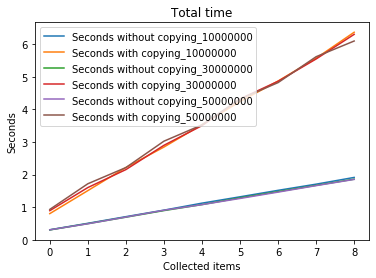

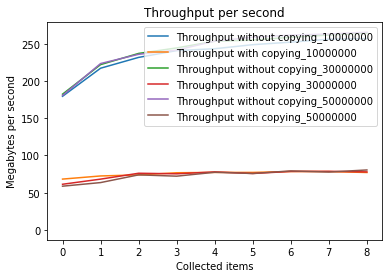

In [12]:
axes = df_times.plot(xlabel='Collected items', ylabel='Seconds', title='Total time')
axes.axhline(y=0, color='white', linestyle='-')
axes = df_throughputs.plot(xlabel='Collected items', ylabel='Megabytes per second', title='Throughput per second')
axes.axhline(y=0, color='white', linestyle='-')

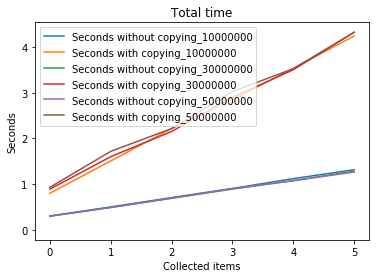

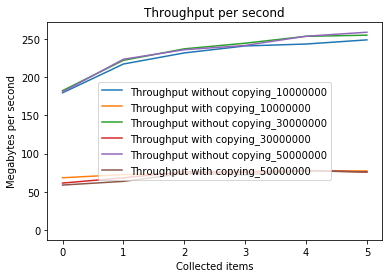

In [13]:
axes = df_times.iloc[:-3].plot(xlabel='Collected items', ylabel='Seconds', title='Total time')
axes.axhline(y=0, color='white', linestyle='-')
axes = df_throughputs.iloc[:-3].plot(xlabel='Collected items', ylabel='Megabytes per second', title='Throughput per second')
axes.axhline(y=0, color='white', linestyle='-')

In [14]:
df_times_throughputs.to_csv('df_times_throughputs.csv', index_label='index')

In [13]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_last_dma_transfer(input_buffer_all_transfers_copied[0], 120000, dont_decode=True)

In [17]:
instr_names[:4]

['JALR', 'UNKNOWN', 'BNE', 'AUIPC']

In [5]:
function_a_addr = '80000038' # from performance_test.bin
getchar_addr = '800000F0' # from performance_test.bin
print('function_a calls =', (df['pc'] == function_a_addr).sum())
print('getchar calls =', (df['pc'] == getchar_addr).sum())

function_a calls = 10000
getchar calls = 5


In [6]:
df[df['pc'] == function_a_addr]

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,Core__TRAP,Core__BRANCH,Core__JAL,Core__JALR,...,AXI4_Slave__AR_FLIT,AXI4_Slave__R_FLIT,AXI4_Slave__R_FLIT_FINAL,AXI4_Master__AW_FLIT,AXI4_Master__W_FLIT,AXI4_Master__W_FLIT_FINAL,AXI4_Master__B_FLIT,AXI4_Master__AR_FLIT,AXI4_Master__R_FLIT,AXI4_Master__R_FLIT_FINAL
69,80000038,4,FE010113,ADDI,"addi x2, x2, -32",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
75,80000038,1,FE010113,ADDI,"addi x2, x2, -32",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
81,80000038,1,FE010113,ADDI,"addi x2, x2, -32",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
87,80000038,1,FE010113,ADDI,"addi x2, x2, -32",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
93,80000038,1,FE010113,ADDI,"addi x2, x2, -32",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18039,80000038,1,FE010113,ADDI,"addi x2, x2, -32",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18045,80000038,1,FE010113,ADDI,"addi x2, x2, -32",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18051,80000038,1,FE010113,ADDI,"addi x2, x2, -32",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18057,80000038,1,FE010113,ADDI,"addi x2, x2, -32",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,Core__TRAP,Core__BRANCH,Core__JAL,Core__JALR,...,AXI4_Slave__AR_FLIT,AXI4_Slave__R_FLIT,AXI4_Slave__R_FLIT_FINAL,AXI4_Master__AW_FLIT,AXI4_Master__W_FLIT,AXI4_Master__W_FLIT_FINAL,AXI4_Master__B_FLIT,AXI4_Master__AR_FLIT,AXI4_Master__R_FLIT,AXI4_Master__R_FLIT_FINAL
0,1010,570,00028067,JALR,"jalr x0, x5, 0",0,0,0,0,0,...,1,8,1,0,0,0,0,1,8,1
1,80000000,35,F14022F3,UNKNOWN,"Cannot decode f14022f3, invalid instruction",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,80000004,1,02029063,BNE,"bne x5, x0, .+32",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,80000008,1,00010117,AUIPC,"auipc x2, 16",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,80000010,2,1880006F,JAL,"jal x0, .+392",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,80000038,1,FE010113,ADDI,"addi x2, x2, -32",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18064,80000070,65,00008067,JALR,"jalr x0, x1, 0",46,0,0,0,0,...,0,0,0,2,2,2,3,0,0,0
18065,8000021C,1,00050793,ADDI,"addi x15, x10, 0",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
18066,8000024C,24,FCF740E3,BLT,"blt x14, x15, .-64",7,0,0,0,0,...,0,0,0,2,2,2,1,0,0,0


In [5]:
items_transferred = -1
dma_transfer_end_time = 0
def worker():
    global items_transferred, dma_transfer_end_time
    items_transferred = get_dma_transfer(input_buffer, dma_rec)#, dont_wait=True)#
    dma_transfer_end_time = time.time()
    print(items_transferred)
    
t = Thread(daemon=True, target=worker)
t.start()

In [8]:
dma_rec.transfer(input_buffer)
#dma_rec.wait()

In [12]:
dma_rec.wait()

KeyboardInterrupt: 

In [13]:
dma_rec.transferred

5609472

In [13]:
print_fifo_data_counts()
before_cpu_reset_time = time.time()
reset_cpu()

gpio_fifo_wr_count = 0
gpio_fifo_rd_count = 0


In [12]:
print_fifo_data_counts()

gpio_fifo_wr_count = 0
gpio_fifo_rd_count = 0


In [8]:
#items_transferred = get_dma_transfer(input_buffer, dma_rec)#, dont_wait=True)

In [8]:
t.is_alive()

False

In [9]:
dma_transfer_end_time - before_cpu_reset_time 

-1676142252.9835927

In [10]:
items_transferred

-1

In [10]:
t.join()

In [14]:
#items_transferred = 35000
items_transferred = 5000


In [41]:
items_transferred = get_dma_transfer(input_buffer, dma_rec)

In [15]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)

In [ ]:
for i, (pc, instr, instr_str, clk_counter, instr_name, fifo_full_ticks_count, gp_regs) in enumerate(zip(pcs, instrs, instr_strings, clk_counters, instr_names, fifo_full_ticks_counts, all_gp_regs)):
    print(f'{i:<4} CLK_DELTA={clk_counter:<14}PC={pc:>8X}    INSTR={instr:>08X}    INSTR_NAME={instr_name:<6}    FIFO_FULL_TICKS_COUNT={fifo_full_ticks_count:<14}\n    A0={gp_regs["A0"]:>08X}    A1={gp_regs["A1"]:>08X}    A2={gp_regs["A2"]:>08X}    A3={gp_regs["A3"]:>08X}    {instr_str}')
    print()

0    CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1    CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2    CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3    CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

4    CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

5    CLK_DELTA=0             PC=       0    INSTR=00000000  

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

117  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

118  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

119  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

120  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

121  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

233  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

234  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

235  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

236  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

237  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

238  CLK_DELTA=0             PC=       0    INSTR=00000000  

349  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

350  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

351  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

352  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

353  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

354  CLK_DELTA=0             PC=       0    INSTR=00000000  

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

463  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

464  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

465  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

466  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

467  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

578  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

579  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

580  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

581  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

582  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

583  CLK_DELTA=0             PC=       0    INSTR=00000000  

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

709  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

710  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

711  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

712  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

713  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

830  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

831  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

832  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

833  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

834  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

947  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

948  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

949  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

950  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

951  CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

952  CLK_DELTA=0             PC=       0    INSTR=00000000  

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1065 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1066 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1067 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1068 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1069 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1184 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1185 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1186 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1187 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1188 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1301 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1302 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1303 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1304 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1305 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

1412 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1413 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1414 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1415 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1416 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1417 CLK_DELTA=0             PC=       0    INSTR=00000000  

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1535 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1536 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1537 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1538 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1539 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

1661 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1662 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1663 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1664 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1665 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1666 CLK_DELTA=0             PC=       0    INSTR=00000000  

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1783 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1784 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1785 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1786 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1787 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1898 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1899 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1900 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1901 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

1902 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

2012 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2013 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2014 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2015 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2016 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2017 CLK_DELTA=0             PC=       0    INSTR=00000000  

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2135 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2136 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2137 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2138 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2139 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2255 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2256 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2257 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2258 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2259 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

2378 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2379 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2380 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2381 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2382 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2383 CLK_DELTA=0             PC=       0    INSTR=00000000  

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2497 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2498 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2499 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2500 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2501 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2615 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2616 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2617 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2618 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2619 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000


2736 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2737 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2738 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2739 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2740 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2741 CLK_DELTA=0             PC=       0    INSTR=00000000 

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2862 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2863 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2864 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2865 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2866 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

2984 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2985 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2986 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2987 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2988 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

2989 CLK_DELTA=0             PC=       0    INSTR=00000000  

3102 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3103 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3104 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3105 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3106 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3107 CLK_DELTA=0             PC=       0    INSTR=00000000  


3222 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3223 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3224 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3225 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3226 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3227 CLK_DELTA=0             PC=       0    INSTR=00000000 

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3345 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3346 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3347 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3348 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3349 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

3462 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3463 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3464 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3465 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3466 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3467 CLK_DELTA=0             PC=       0    INSTR=00000000  


3587 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3588 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3589 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3590 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3591 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3592 CLK_DELTA=0             PC=       0    INSTR=00000000 

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3717 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3718 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3719 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3720 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3721 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

3841 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3842 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3843 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3844 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3845 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3846 CLK_DELTA=0             PC=       0    INSTR=00000000  

    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3956 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3957 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3958 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3959 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000    -

3960 CLK_DELTA=0             PC=       0    INSTR=00000000    INSTR_NAME=UNKNOWN    FIFO_FULL_TICKS_COUNT=0             
    A0=00000000    A1=00000000    A2=00000000    A3=00000000

In [37]:
for i, (pc, instr, instr_str, clk_counter, instr_name, fifo_full_ticks_count, gp_regs) in enumerate(zip(pcs, instrs, instr_strings, clk_counters, instr_names, fifo_full_ticks_counts, all_gp_regs)):
    if i > 31240:
        print(f'{i:<4} CLK_DELTA={clk_counter:<14}PC={pc:>8X}    INSTR={instr:>08X}    INSTR_NAME={instr_name:<6}    FIFO_FULL_TICKS_COUNT={fifo_full_ticks_count:<14}\n    A0={gp_regs["A0"]:>08X}    A1={gp_regs["A1"]:>08X}    A2={gp_regs["A2"]:>08X}    A3={gp_regs["A3"]:>08X}    {instr_str}')
        print()
    if i > 31260:
        break

31241 CLK_DELTA=1             PC=8000021C    INSTR=00050793    INSTR_NAME=ADDI      FIFO_FULL_TICKS_COUNT=0             
    A0=000014D1    A1=00001020    A2=00000000    A3=00000000    -

31242 CLK_DELTA=24            PC=8000024C    INSTR=FCF740E3    INSTR_NAME=BLT       FIFO_FULL_TICKS_COUNT=7             
    A0=000014D1    A1=00001020    A2=00000000    A3=00000000    -

31243 CLK_DELTA=1             PC=8000020C    INSTR=FE442783    INSTR_NAME=LW        FIFO_FULL_TICKS_COUNT=0             
    A0=000014D1    A1=00001020    A2=00000000    A3=00000000    -

31244 CLK_DELTA=4             PC=80000218    INSTR=E21FF0EF    INSTR_NAME=JAL       FIFO_FULL_TICKS_COUNT=0             
    A0=0000004A    A1=00001020    A2=00000000    A3=00000000    -

31245 CLK_DELTA=1             PC=80000038    INSTR=FE010113    INSTR_NAME=ADDI      FIFO_FULL_TICKS_COUNT=0             
    A0=0000004A    A1=00001020    A2=00000000    A3=00000000    -

31246 CLK_DELTA=65            PC=80000070    INSTR=00008067 

In [11]:
df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# all_gp_regs is a list of dicts, it is joined below into the main dataframe
df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
df[:20]

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,A0,A1,A2,A3
0,00000000,0,0,UNKNOWN,-,0,0,0,0,0
1,00000000,0,0,UNKNOWN,-,0,0,0,0,0
2,00000000,0,0,UNKNOWN,-,0,0,0,0,0
3,00000000,0,0,UNKNOWN,-,0,0,0,0,0
4,00000000,0,0,UNKNOWN,-,0,0,0,0,0
5,00000000,0,0,UNKNOWN,-,0,0,0,0,0
6,00000000,0,0,UNKNOWN,-,0,0,0,0,0
7,00000000,0,0,UNKNOWN,-,0,0,0,0,0
8,00000000,0,0,UNKNOWN,-,0,0,0,0,0
9,00000000,0,0,UNKNOWN,-,0,0,0,0,0


In [8]:
print_performance_stats(df)

normal_run_time = 0.0s
halted_time = 0.0s
performance_decrease = nan%


<ipython-input-1-19643f5913a0>:389: RuntimeWarning: invalid value encountered in double_scalars
  performance_decrease = 100.0 - normal_run_time / (normal_run_time + halted_time) * 100


In [14]:
dma_transfer_end_time - before_cpu_reset_time 

0.05956768989562988

In [14]:
df[df['instr']!=0].iloc[:30]

,pc,clk_counter,instr,instr_names,instr_strings,fifo_full_ticks_counts,A0,A1,A2,A3
0,00001010,570,163943,JALR,-,0,0,4128,0,0
1,80000000,35,4047512307,UNKNOWN,-,0,0,4128,0,0
2,80000004,1,33722467,BNE,-,0,0,4128,0,0
3,80000008,1,65815,AUIPC,-,0,0,4128,0,0
4,80000010,2,411041903,JAL,-,0,0,4128,0,0
5,80000198,35,4261478675,ADDI,-,0,0,4128,0,0
6,800001B0,10,58720367,JAL,-,0,0,4128,0,0
7,800001E8,51,4037013743,JAL,-,0,0,4128,0,0
8,80000104,75,4213174511,JAL,-,0,0,4128,0,0
9,800000B4,38,4278255891,ADDI,-,0,0,4128,0,0


In [10]:
for instr in instrs: 
    name = get_riscv_instruction_name(instr)
    print(name)

JALR
UNKNOWN
BNE
AUIPC
JAL
ADDI
JAL
ADDI
UNKNOWN
JAL
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
AUIPC
JALR
JAL
ADDI
UNKNOWN
JAL
ADDI
JAL
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
J

In [42]:
halted_times = []
normal_run_times = []
total_run_times = []
performance_decreases = []
performances = []
items_counts = []
bytes_per_second_list = []
#i = 100


start_point = 25000
i = start_point
#while i < 30_000:
while i < items_transferred:
    halted_time, normal_run_time, performance_decrease = get_performance_stats(df.iloc[start_point:i])
    halted_times.append(halted_time)
    normal_run_times.append(normal_run_time)
    performance_decreases.append(performance_decrease)
    total_run_time = normal_run_time + halted_time
    total_run_times.append(total_run_time)
    items_counts.append(i-start_point)
    performances.append(100 - performance_decrease)
    
    bytes_per_second_list.append(((i - start_point) * AXI_DATA_WIDTH) / total_run_time // 8)
    #print(i, halted_time, normal_run_time, performance_decrease)
    print(i)
    i = i + 50
    
df_perf = pd.DataFrame(zip(halted_times, normal_run_times, total_run_times, performance_decreases, performances, bytes_per_second_list),
                      columns=['Halted', 'Normal', 'With PYNQ wrapper', 'Performance decrease', 'Performance', 'Bytes per second'], 
                      index=items_counts)
    

<ipython-input-1-4f462425ee7c>:315: RuntimeWarning: invalid value encountered in double_scalars
  performance_decrease = 100.0 - normal_run_time / (normal_run_time + halted_time) * 100
<ipython-input-42-79a8d2176c3a>:24: RuntimeWarning: invalid value encountered in double_scalars
  bytes_per_second_list.append(((i - start_point) * AXI_DATA_WIDTH) / total_run_time // 8)


25000
25050
25100
25150
25200
25250
25300
25350
25400
25450
25500
25550
25600
25650
25700
25750
25800
25850
25900
25950
26000
26050
26100
26150
26200
26250
26300
26350
26400
26450
26500
26550
26600
26650
26700
26750
26800
26850
26900
26950
27000
27050
27100
27150
27200
27250
27300
27350
27400
27450
27500
27550
27600
27650
27700
27750
27800
27850
27900
27950
28000
28050
28100
28150
28200
28250
28300
28350
28400
28450
28500
28550
28600
28650
28700
28750
28800
28850
28900
28950
29000
29050
29100
29150
29200
29250
29300
29350
29400
29450
29500
29550
29600
29650
29700
29750
29800
29850
29900
29950
30000
30050


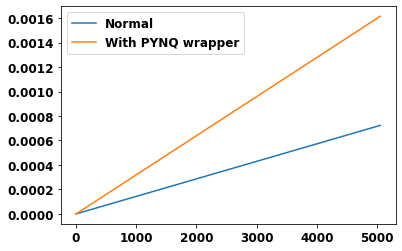

In [43]:
df_perf.drop(columns=['Performance decrease', 'Performance', 'Halted', 'Bytes per second']).plot()

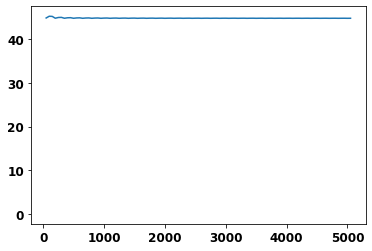

In [44]:
plt.axhline(y=0, color='white', linestyle='-')
df_perf['Performance'].plot()

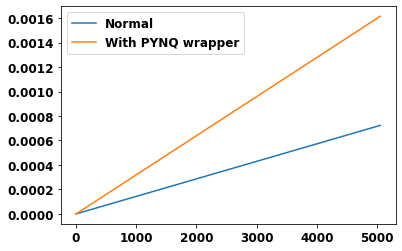

In [45]:
df_perf.loc[0:7500].drop(columns=['Performance decrease', 'Performance', 'Halted', 'Bytes per second']).plot()

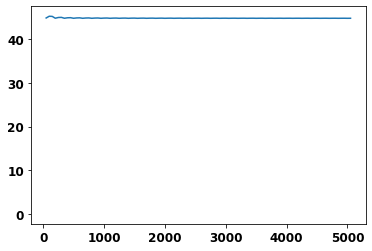

In [46]:
plt.axhline(y=0, color='white', linestyle='-')
df_perf['Performance'].loc[0:7500].plot()

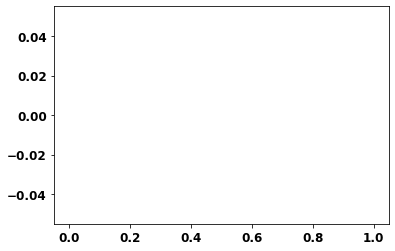

In [47]:
plt.axhline(y=0, color='white', linestyle='-')
df_perf['Bytes per second'].loc[29000:30001].plot()

In [48]:
df_perf['Bytes per second'].iloc[-1]

400188207.0

In [24]:
df_perf.to_csv('performance_stats.csv', index_label='index')

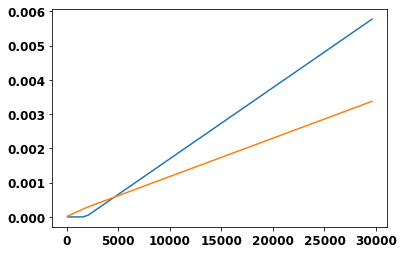

In [65]:
plt.plot(items_counts, halted_times, label='Halted')
plt.plot(items_counts, normal_run_times, label='Normal')
#plt.plot(items_counts, performance_penalties, label='Performance penalty')
#plt.legend()
#plt.show()

In [29]:
#import matplotlib.pyplot as plt

In [11]:
# print performance counters for the first 10 datapoints/instructions from data above
df = pd.DataFrame(events, columns=event_names)
df.iloc[:20]

,Core__TRAP,Core__BRANCH,Core__JAL,Core__JALR,Core__AUIPC,Core__LOAD,Core__STORE,Core__SERIAL_SHIFT,Core__LOAD_WAIT,Core__STORE_WAIT,...,AXI4_Slave__AR_FLIT,AXI4_Slave__R_FLIT,AXI4_Slave__R_FLIT_FINAL,AXI4_Master__AW_FLIT,AXI4_Master__W_FLIT,AXI4_Master__W_FLIT_FINAL,AXI4_Master__B_FLIT,AXI4_Master__AR_FLIT,AXI4_Master__R_FLIT,AXI4_Master__R_FLIT_FINAL
0,0,0,0,0,1,1,0,0,21,0,...,1,8,1,0,0,0,0,1,8,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,2,0,0,2,...,0,0,0,1,1,1,0,1,0,0
7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,4,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,3,0,0,3,...,0,0,0,3,3,3,2,0,0,0


In [12]:
for eo in events_overflows:
    if eo: 
        print(eo)

In [13]:
event_names

['Core__TRAP',
 'Core__BRANCH',
 'Core__JAL',
 'Core__JALR',
 'Core__AUIPC',
 'Core__LOAD',
 'Core__STORE',
 'Core__SERIAL_SHIFT',
 'Core__LOAD_WAIT',
 'Core__STORE_WAIT',
 'Core__F_BUSY_NO_CONSUME',
 'Core__1_BUSY_NO_CONSUME',
 'Core__2_BUSY_NO_CONSUME',
 'Core__INTERRUPT',
 'L1I__LD',
 'L1I__LD_MISS',
 'L1I__LD_MISS_LAT',
 'L1I__TLB',
 'L1D__LD',
 'L1D__LD_MISS',
 'L1D__LD_MISS_LAT',
 'L1D__ST',
 'L1D__TLB',
 'TGC__READ',
 'TGC__READ_MISS',
 'AXI4_Slave__AW_FLIT',
 'AXI4_Slave__W_FLIT',
 'AXI4_Slave__W_FLIT_FINAL',
 'AXI4_Slave__B_FLIT',
 'AXI4_Slave__AR_FLIT',
 'AXI4_Slave__R_FLIT',
 'AXI4_Slave__R_FLIT_FINAL',
 'AXI4_Master__AW_FLIT',
 'AXI4_Master__W_FLIT',
 'AXI4_Master__W_FLIT_FINAL',
 'AXI4_Master__B_FLIT',
 'AXI4_Master__AR_FLIT',
 'AXI4_Master__R_FLIT',
 'AXI4_Master__R_FLIT_FINAL']

In [14]:
# event name format is "CATEGORY__NAME"
df.mean(axis=0).sort_values(ascending=False)[:-1]

L1I__TLB                     3.943674
L1I__LD                      3.943674
L1D__TLB                     1.585789
Core__1_BUSY_NO_CONSUME      1.224437
L1D__LD                      0.996534
Core__LOAD                   0.996534
Core__2_BUSY_NO_CONSUME      0.751300
Core__F_BUSY_NO_CONSUME      0.738302
L1I__LD_MISS_LAT             0.738302
Core__STORE_WAIT             0.710572
AXI4_Slave__W_FLIT           0.589255
AXI4_Slave__W_FLIT_FINAL     0.589255
AXI4_Slave__B_FLIT           0.589255
AXI4_Master__AW_FLIT         0.589255
AXI4_Master__W_FLIT          0.589255
L1D__ST                      0.589255
AXI4_Slave__AW_FLIT          0.589255
AXI4_Master__W_FLIT_FINAL    0.589255
AXI4_Master__B_FLIT          0.589255
Core__STORE                  0.589255
TGC__READ                    0.474003
Core__LOAD_WAIT              0.441075
L1D__LD_MISS_LAT             0.370017
Core__BRANCH                 0.173310
Core__JAL                    0.169844
Core__JALR                   0.160312
Core__AUIPC 

In [15]:
def select_performance_counters(df):
    #hardcoded_ones = ['Core__TRAP', 'Core__INTERRUPT']
    df_max = df.max(axis=0)
    return df_max[df_max > 0].index.tolist()

select_performance_counters(df)

['Core__BRANCH',
 'Core__JAL',
 'Core__JALR',
 'Core__AUIPC',
 'Core__LOAD',
 'Core__STORE',
 'Core__SERIAL_SHIFT',
 'Core__LOAD_WAIT',
 'Core__STORE_WAIT',
 'Core__F_BUSY_NO_CONSUME',
 'Core__1_BUSY_NO_CONSUME',
 'Core__2_BUSY_NO_CONSUME',
 'L1I__LD',
 'L1I__LD_MISS',
 'L1I__LD_MISS_LAT',
 'L1I__TLB',
 'L1D__LD',
 'L1D__LD_MISS',
 'L1D__LD_MISS_LAT',
 'L1D__ST',
 'L1D__TLB',
 'TGC__READ',
 'TGC__READ_MISS',
 'AXI4_Slave__AW_FLIT',
 'AXI4_Slave__W_FLIT',
 'AXI4_Slave__W_FLIT_FINAL',
 'AXI4_Slave__B_FLIT',
 'AXI4_Slave__AR_FLIT',
 'AXI4_Slave__R_FLIT',
 'AXI4_Slave__R_FLIT_FINAL',
 'AXI4_Master__AW_FLIT',
 'AXI4_Master__W_FLIT',
 'AXI4_Master__W_FLIT_FINAL',
 'AXI4_Master__B_FLIT',
 'AXI4_Master__AR_FLIT',
 'AXI4_Master__R_FLIT',
 'AXI4_Master__R_FLIT_FINAL']

In [16]:
df.max(axis=0).sort_values(ascending=False)[:-1]
df['Core__LOAD_WAIT'].sort_values()[-30:]

371       0
422       0
385       0
384       0
383       0
382       0
381       0
380       0
374       0
379       0
421       0
377       0
376       0
375       0
378       0
416       0
983       7
937       7
881       7
877      14
0        21
979      22
933      25
775      36
11       40
97       42
15       50
387      52
1074     70
93      116
Name: Core__LOAD_WAIT, dtype: int64

In [14]:
console_io.data_available()

False

In [5]:
console_io.read()

'===================A40200800000000\n'

In [37]:
console_io.send('BCD', end_byte=ord('\n'))

In [20]:
#console_io.send('AAAA')

In [21]:
# import matplotlib.pyplot as plt
# plt.plot(pcs)
# plt.show()